<a href="https://colab.research.google.com/github/Leonard2310/TrendAnalysis/blob/main/code/TrendAnalysisISBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trend Analysis of Time Series with Dynamic Interface in the Agritech Domain
Analisi dei Trend di Serie Storiche con Interfaccia Dinamica nel Dominio Agritech
Il problema che stiamo affrontando riguarda la previsione del numero di infestanti (insetti) catturati o della loro insorgenza, utilizzando una combinazione di dati meteorologici e informazioni sull'insorgenza degli stessi infestanti in intervalli di tempo precedenti. Questo tipo di analisi si inserisce nell'ambito dell'analisi predittiva applicata a dati temporali e ambientali.

### Variabile Target:
  **Problema di Regressione:**  
   La **variabile target** in questo caso è il **numero di insetti catturati**. Si tratta di un problema di regressione, in cui l'obiettivo è prevedere una quantità continua, ossia il numero totale di infestanti catturati in un determinato intervallo di tempo.

### Strumenti e Tecniche:
Per affrontare questo problema, utilizzeremo **Python** insieme alle librerie più adatte per l'analisi e la modellazione dei dati, tra cui **Streamlit** per creare una **dashboard interattiva**, che permetta di visualizzare i risultati e le previsioni in modo dinamico e accessibile.

### Obiettivo Finale:
L'obiettivo finale è sviluppare un modello predittivo che possa prevedere con precisione il numero di infestanti catturati (problema di regressione) in base ai dati meteorologici e alle osservazioni precedenti. La dashboard creata con Streamlit fornirà un'interfaccia utente semplice per esplorare le previsioni e visualizzare le tendenze delle catture nel tempo.

# Drive Linking
È stato effettuato un collegamento al Drive per il caricamento dei dati direttamente dal cloud. Questo approccio consente di accedere facilmente ai dataset archiviati in remoto, garantendo una gestione più flessibile e scalabile dei dati necessari per l'addestramento e le previsioni, riducendo al contempo il bisogno di archiviazione locale.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')                                                   # Indirizzo base

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library Import
Per il corretto funzionamento del progetto, sono state importate tutte le librerie necessarie, tra cui quelle per il caricamento e la gestione dei dati, l'elaborazione delle serie temporali, l'addestramento dei modelli  e la visualizzazione.

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import keras

# Per l'analisi delle serie temporali
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Per i test statistici
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest, ks_2samp, gaussian_kde

# Per il clustering e la riduzione dimensionale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from matplotlib.dates import DateFormatter

# Per i modelli di machine learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

#Per i modelli statistici
import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Path
Il percorso dei file contenuti nel Drive è stato configurato in modo da consentire l'accesso diretto ai dati necessari per il progetto.

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ISBI/Project/Dataset'
WEATHER_DATA = DATA_PATH + '/Weather'
CAPTURE_DATA = DATA_PATH + '/Capture'
NEW_WEATHER_DATA = DATA_PATH + '/New Weather'
NEW_CAPTURE_DATA = DATA_PATH + '/New Capture'
SYNTETIC_WEATHER_DATA = DATA_PATH + '/Synthetic Weather'
JOINED_DATA = DATA_PATH + '/Joined Data'

# Data Import
Nel corso del progetto, abbiamo affrontato la necessità di convertire i file da formato Excel (HTML) a CSV per rendere i dati più accessibili e compatibili con strumenti di elaborazione automatizzata. Inoltre, i valori numerici presenti nei dati originali erano rappresentati come stringhe con la virgola utilizzata come separatore decimale. Abbiamo quindi implementato una conversione da string a float, adottando il punto come delimitatore decimale.

In [ ]:
def process_csv_files(input_folder, output_folder, weather):
    """
    Processa i file CSV in una cartella. Rimuove la prima riga di ogni file e
    usa solo i valori della terza riga come intestazione dove presenti.

    Parametri:
    input_folder (str): Cartella contenente i file CSV da processare.
    output_folder (str): Cartella dove salvare i file processati.
    weather (bool): Flag che indica se utilizzare la terza riga come intestazione o meno.
    """
    # Creare la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV senza intestazione
            df = pd.read_csv(file_path, header=None)

            if weather:
                # Usa i valori della terza riga come intestazione, se presenti
                new_header = [
                    df.iloc[2, i] if pd.notna(df.iloc[2, i]) else df.iloc[1, i]
                    for i in range(len(df.columns))
                ]

                # Elimina le prime tre righe (intestazione originale inclusa)
                df = df.iloc[3:].reset_index(drop=True)

                # Imposta la nuova intestazione
                df.columns = new_header
            else:
                # Elimina la prima riga e usa la seconda riga come intestazione
                df = df.iloc[1:].reset_index(drop=True)

                # Imposta la seconda riga come intestazione
                df.columns = df.iloc[0]
                df = df[1:].reset_index(drop=True)

            # Salva il file processato con la nuova intestazione
            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=False, header=True)
            print(f"File processato e salvato: {output_path}")

In [ ]:
process_csv_files(WEATHER_DATA, NEW_WEATHER_DATA, weather=True)

File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 1).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 2).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 1).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 2).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 3).csv


In [ ]:
df = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 1).csv")

df

DateTime Media Temperatura   low  high Media Umidità
0     05.07.2024 15:00:00             31,65  31,1  32,2         37,08
1     05.07.2024 16:00:00             31,45    31  32,2         33,55
2     05.07.2024 17:00:00             31,66  31,2  32,1         34,98
3     05.07.2024 18:00:00             30,08  29,2  30,8         42,39
4     05.07.2024 19:00:00             28,78  26,5  29,6         47,54
...                   ...               ...   ...   ...           ...
1163  23.08.2024 02:00:00             19,57  19,5  19,8         87,25
1164  23.08.2024 03:00:00             19,92  19,7  20,2         86,89
1165  23.08.2024 04:00:00             19,57    19  19,8         88,57
1166  23.08.2024 05:00:00             18,58  18,4  18,9         92,14
1167  23.08.2024 06:00:00             18,36  18,3  18,4          93,3

[1168 rows x 5 columns]

In [ ]:
process_csv_files(CAPTURE_DATA, NEW_CAPTURE_DATA, weather=False)

File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 3).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 1).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 2).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Cicalino 1).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Cicalino 2).csv


In [ ]:
df = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Cicalino 1).csv")

df

DateTime  Numero di insetti  Nuove catture (per evento)  \
0   06.07.2024 06:01:00                0.0                         0.0   
1   07.07.2024 06:04:00                0.0                         0.0   
2   08.07.2024 06:03:00                0.0                         0.0   
3   09.07.2024 06:05:00                0.0                         0.0   
4   09.07.2024 06:13:59                NaN                         NaN   
5   10.07.2024 06:03:00                0.0                         0.0   
6   11.07.2024 06:01:00                0.0                         0.0   
7   12.07.2024 06:05:00                0.0                         0.0   
8   13.07.2024 06:02:00                0.0                         0.0   
9   14.07.2024 06:01:00                1.0                         1.0   
10  15.07.2024 06:04:00                1.0                         0.0   
11  16.07.2024 06:03:00                2.0                         1.0   
12  16.07.2024 06:12:59                NaN                         NaN   
13  17.07.2024 06:02:00                1.0                         1.0   
14  18.07.2024 06:01:00                1.0                         0.0   
15  19.07.2024 06:04:00                1.0                         0.0   
16  20.07.2024 06:02:00                1.0                         0.0   
17  20.07.2024 06:11:59                NaN                         NaN   
18  21.07.2024 06:02:00                1.0                         1.0   
19  22.07.2024 06:00:00                2.0                         1.0   
20  23.07.2024 06:04:00                0.0                         0.0   
21  24.07.2024 06:02:00                0.0                         0.0   
22  25.07.2024 06:01:00                1.0                         1.0   
23  26.07.2024 06:01:00                1.0                         0.0   
24  27.07.2024 06:05:00                1.0                         0.0   
25  28.07.2024 06:03:00                3.0                         2.0   
26  28.07.2024 06:12:59                NaN                         NaN   
27  29.07.2024 06:04:00                0.0                         0.0   
28  30.07.2024 06:02:00                0.0                         0.0   
29  31.07.2024 06:00:00                0.0                         0.0   
30  01.08.2024 06:04:00                0.0                         0.0   
31  02.08.2024 06:03:00                0.0                         0.0   
32  02.08.2024 06:12:59                NaN                         NaN   
33  03.08.2024 06:03:00                0.0                         0.0   
34  03.08.2024 06:13:59                NaN                         NaN   
35  04.08.2024 06:04:00                0.0                         0.0   
36  05.08.2024 06:01:00                0.0                         0.0   
37  06.08.2024 06:00:00                1.0                         1.0   
38  07.08.2024 06:04:00                1.0                         0.0   
39  08.08.2024 06:03:00                1.0                         0.0   
40  09.08.2024 06:01:00                1.0                         0.0   
41  09.08.2024 06:10:59                NaN                         NaN   
42  10.08.2024 06:00:00                0.0                         0.0   
43  11.08.2024 06:04:00                0.0                         0.0   
44  12.08.2024 06:03:00                0.0                         0.0   
45  13.08.2024 06:03:00                0.0                         0.0   
46  14.08.2024 06:01:00                0.0                         0.0   
47  15.08.2024 06:00:00                0.0                         0.0   
48  15.08.2024 06:10:59                NaN                         NaN   
49  16.08.2024 06:00:00                0.0                         0.0   
50  17.08.2024 06:04:00                0.0                         0.0   
51  18.08.2024 06:03:00                0.0                         0.0   
52  19.08.2024 06:02:00                0.0                         0.0   
53  20.08.2024 06:0

In [ ]:
def convert_columns_to_float(input_folder, output_folder):
    """
    Processa tutti i file CSV in una directory: converte tutte le colonne (escluse la prima)
    in valori float sostituendo la virgola con il punto.

    Parametri:
    input_folder (str): Cartella contenente i file CSV da processare.
    output_folder (str): Cartella dove salvare i file processati.
    """
    # Creare la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV
            df = pd.read_csv(file_path)

            # Converti tutte le colonne tranne la prima
            for col in df.columns[1:]:
                # Sostituire la virgola con il punto e convertire in float
                df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

            # Salva il file processato
            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=False)
            print(f"File processato e salvato: {output_path}")

In [ ]:
convert_columns_to_float(NEW_WEATHER_DATA, NEW_WEATHER_DATA)

File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 2).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 1).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 3).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 2).csv
File processato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 1).csv


In [ ]:
df = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 1).csv")

df

DateTime  Media Temperatura   low  high  Media Umidità
0     05.07.2024 15:00:00              31.65  31.1  32.2          37.08
1     05.07.2024 16:00:00              31.45  31.0  32.2          33.55
2     05.07.2024 17:00:00              31.66  31.2  32.1          34.98
3     05.07.2024 18:00:00              30.08  29.2  30.8          42.39
4     05.07.2024 19:00:00              28.78  26.5  29.6          47.54
...                   ...                ...   ...   ...            ...
1163  23.08.2024 02:00:00              19.57  19.5  19.8          87.25
1164  23.08.2024 03:00:00              19.92  19.7  20.2          86.89
1165  23.08.2024 04:00:00              19.57  19.0  19.8          88.57
1166  23.08.2024 05:00:00              18.58  18.4  18.9          92.14
1167  23.08.2024 06:00:00              18.36  18.3  18.4          93.30

[1168 rows x 5 columns]

# Data Visualization
Durante l'analisi esplorativa dei dati, abbiamo esaminato le distribuzioni delle variabili meteorologiche associate ai siti di Cicalino e Imola. Le analisi statistiche hanno evidenziato una significativa discordanza tra le distribuzioni complessive dei due siti principali, suggerendo differenze sostanziali nei pattern climatici delle due località. Tuttavia, all'interno dei sottogruppi, le distribuzioni di Cicalino 1 e Cicalino 2, così come quelle di Imola 1, Imola 2 e Imola 3, hanno mostrato una notevole omogeneità, indicando una coerenza interna tra i rispettivi siti.
Durante la fase di analisi del target, è stata esaminata la frequenza delle catture di insetti rispetto ai casi di non cattura. I dati hanno mostrato che, per Cicalino, le rilevazioni di cattura sono più frequenti, mentre per Imola le osservazioni relative alle catture risultano meno numerose. Tuttavia, in entrambi i casi, l'assenza di cattura risulta essere la condizione predominante. Questo risultato è statisticamente giustificato, poiché gli insetti vengono catturati in numero limitato, rendendo gli eventi di cattura rari rispetto ai casi di non cattura.

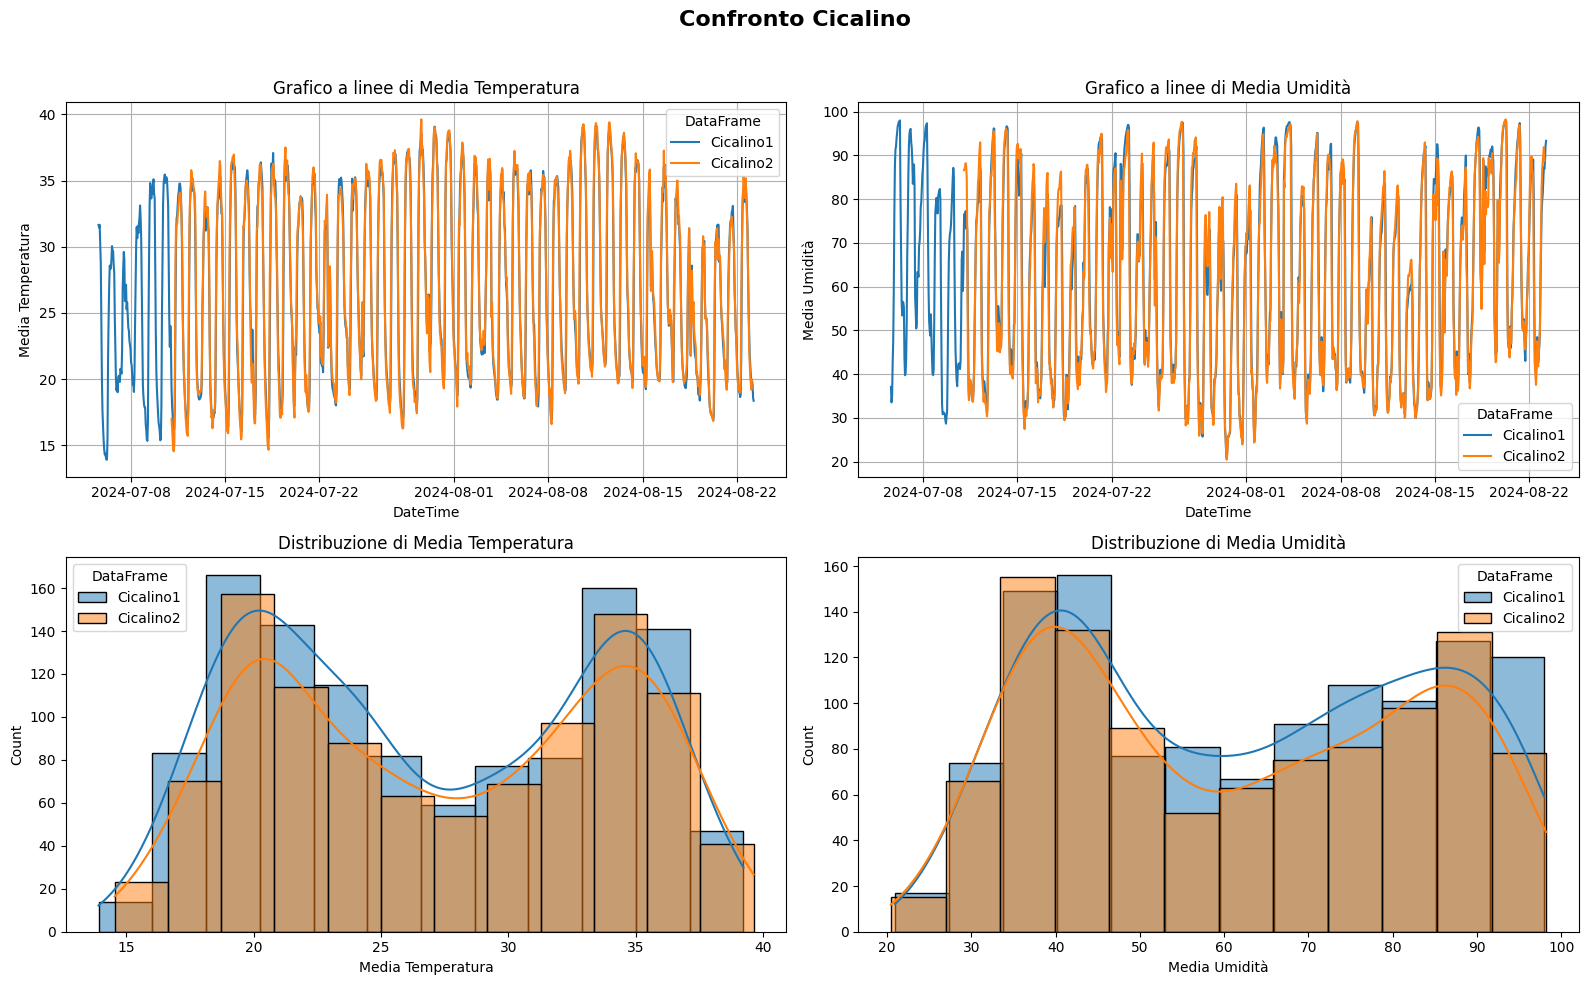

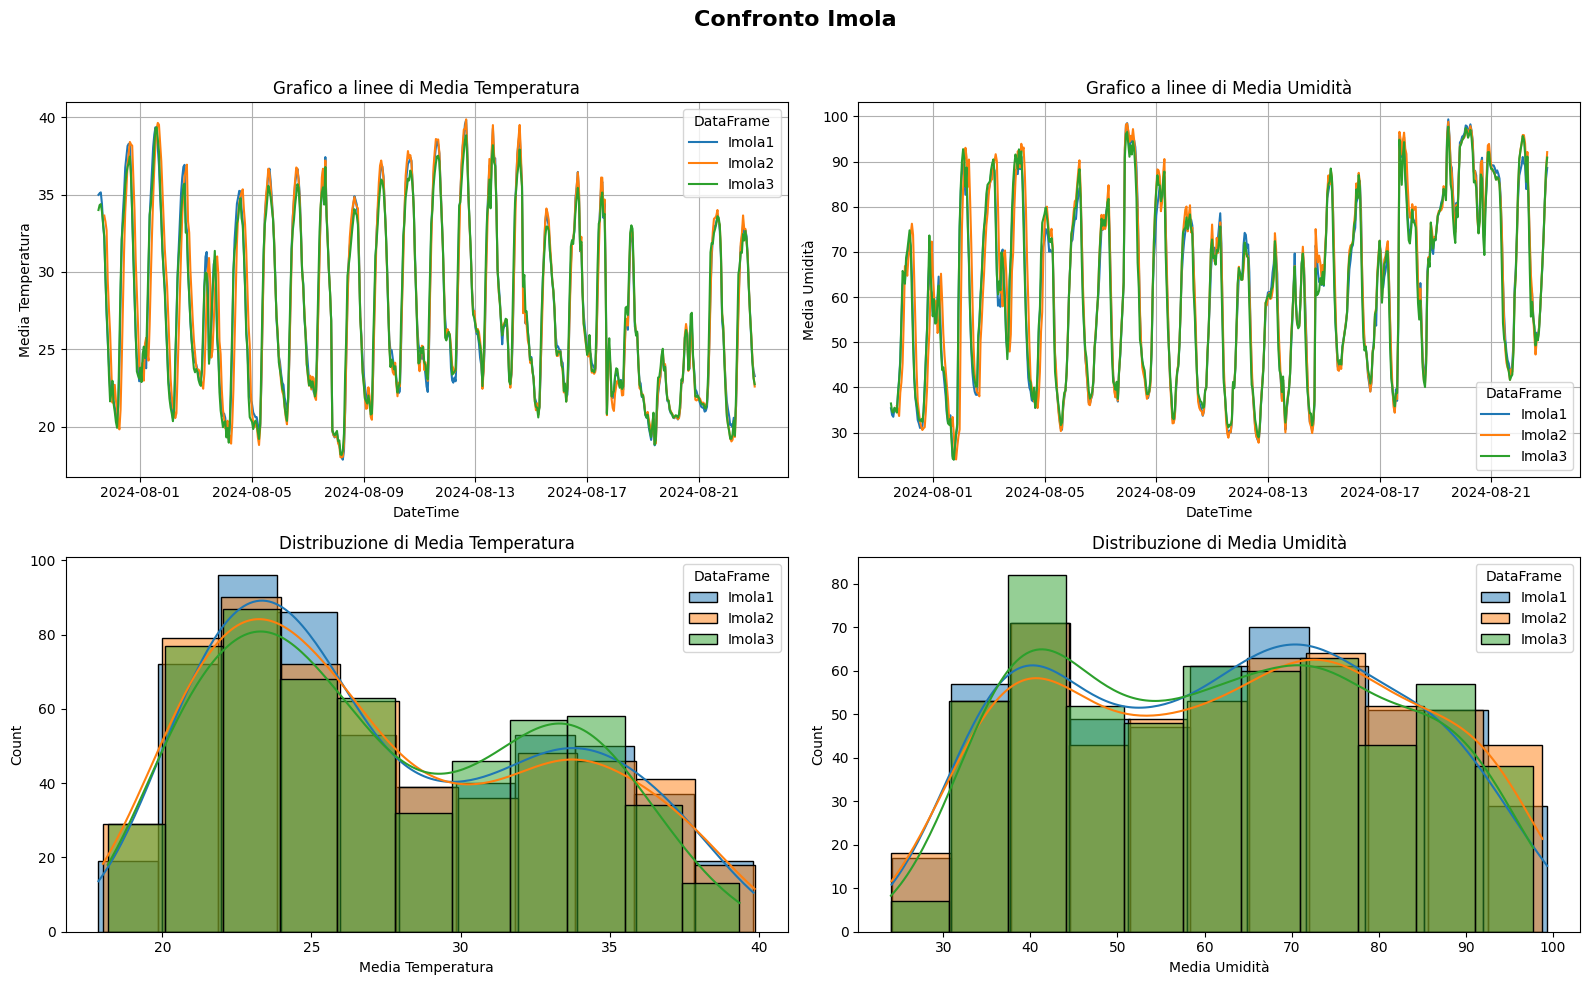

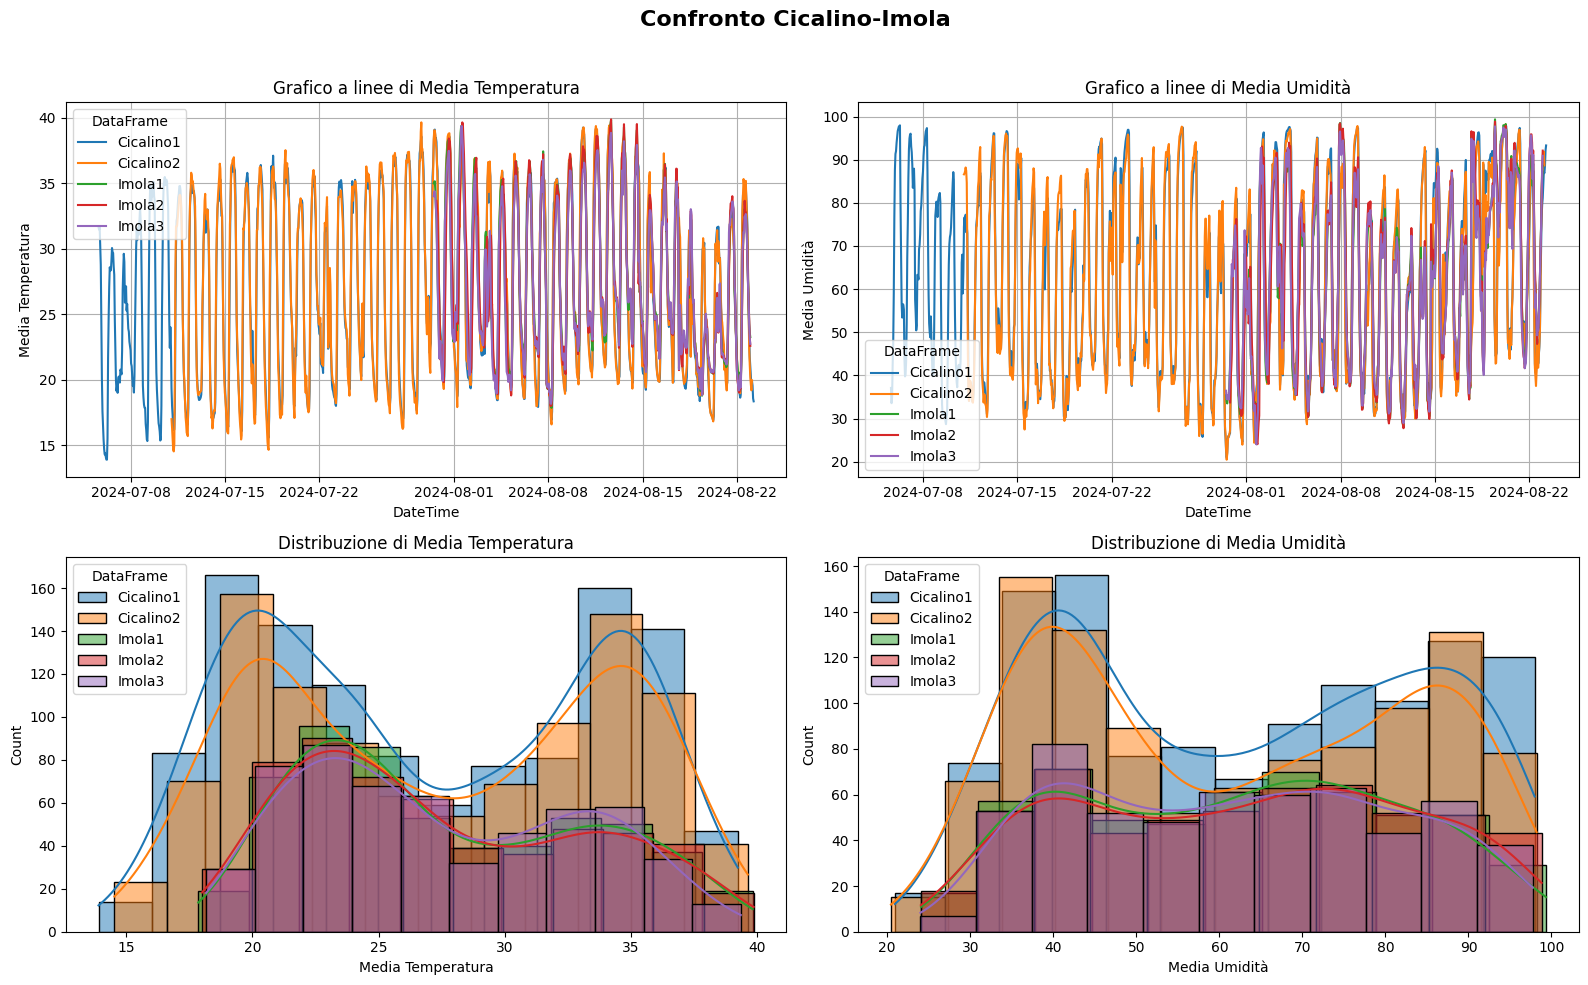

In [ ]:
#@title ##Investigazione dei Dati

def plot_line_and_distribution(dfs, date_col, columns_to_plot, figsize=(16, 10), date_format='%d.%m.%Y %H:%M:%S', plot_title="Grafici", legend_labels=None):
    """
    Traccia grafici a linee e grafici di distribuzione delle colonne specificate nei dataframe forniti.
    I grafici vengono tracciati su una griglia 2x2, con i grafici a linee sulla prima riga e i grafici di distribuzione sulla seconda riga.

    Parametri:
    dfs (list): Lista di DataFrame pandas.
    date_col (str): Nome della colonna contenente la data.
    columns_to_plot (list): Lista dei nomi delle colonne da tracciare.
    figsize (tuple): Dimensione della figura (larghezza, altezza).
    date_format (str): Il formato della colonna data (il valore predefinito è '%d.%m.%Y %H:%M:%S').
    plot_title (str): Titolo per l'intero grafico.
    legend_labels (list): Lista di etichette personalizzate per i DataFrame nella legenda. Deve avere la stessa lunghezza di `dfs`.
    """

    # Verifica se sono state fornite etichette personalizzate per la legenda e se corrispondono al numero di DataFrame
    if legend_labels is None:
        legend_labels = [f"DF{i+1}" for i in range(len(dfs))]
    elif len(legend_labels) != len(dfs):
        raise ValueError("Il numero di etichette nella legenda deve corrispondere al numero di DataFrame.")

    # Converte la colonna data in datetime in tutti i dataframe e la imposta come indice
    for df in dfs:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], format=date_format)
            df.set_index(date_col, inplace=True)

    # Verifica se le colonne specificate esistono in tutti i dataframe
    for col in columns_to_plot:
        for i, df in enumerate(dfs):
            if col not in df.columns:
                raise ValueError(f"La colonna '{col}' non è stata trovata nel DataFrame {i+1}.")

    # Assicura che vengano fornite almeno due colonne per la griglia 2x2
    if len(columns_to_plot) < 2:
        raise ValueError("Devono essere specificate almeno due colonne per il grafico.")

    # Seleziona le prime due colonne da tracciare
    selected_columns = columns_to_plot[:2]

    # Crea la figura e gli assi per una griglia 2x2
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(plot_title, fontsize=16, weight='bold')  # Aggiunge il titolo principale

    # Traccia i grafici a linee e i grafici di distribuzione
    for i, col in enumerate(selected_columns):
        # Grafico a linee
        ax_line = axs[0, i]
        for j, df in enumerate(dfs):
            sns.lineplot(data=df, x=df.index, y=col, ax=ax_line, label=legend_labels[j])
        ax_line.set_title(f'Grafico a linee di {col}')
        ax_line.legend(title="DataFrame")
        ax_line.grid(True)

        # Grafico di distribuzione
        ax_dist = axs[1, i]
        for j, df in enumerate(dfs):
            sns.histplot(df[col], kde=True, ax=ax_dist, label=legend_labels[j])
        ax_dist.set_title(f'Distribuzione di {col}')
        ax_dist.legend(title="DataFrame")

    # Regola il layout e visualizza il grafico
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Regola il layout per fare spazio al titolo principale
    plt.show()

df_WC1 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 1).csv")
df_WC2 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 2).csv")
df_WI1 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Imola 1).csv")
df_WI2 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Imola 2).csv")
df_WI3 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Imola 3).csv")
df_CC1 = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Cicalino 1).csv")
df_CC2 = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Cicalino 2).csv")
df_CI1 = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Imola 1).csv")
df_CI2 = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Imola 2).csv")
df_CI3 = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Imola 3).csv")

columns_to_plot = ['Media Temperatura', 'Media Umidità']
legend_labels_cicalino = ['Cicalino1', 'Cicalino2']
legend_labels_imola = ['Imola1', 'Imola2', 'Imola3']
legend_labels = legend_labels_cicalino + legend_labels_imola

plot_line_and_distribution([df_WC1, df_WC2], 'DateTime', columns_to_plot, plot_title='Confronto Cicalino', legend_labels= legend_labels_cicalino)
plot_line_and_distribution([df_WI1, df_WI2, df_WI3], 'DateTime', columns_to_plot, plot_title='Confronto Imola', legend_labels= legend_labels_imola)
plot_line_and_distribution([df_WC1, df_WC2, df_WI1, df_WI2, df_WI3], 'DateTime', columns_to_plot, plot_title='Confronto Cicalino-Imola', legend_labels= legend_labels)

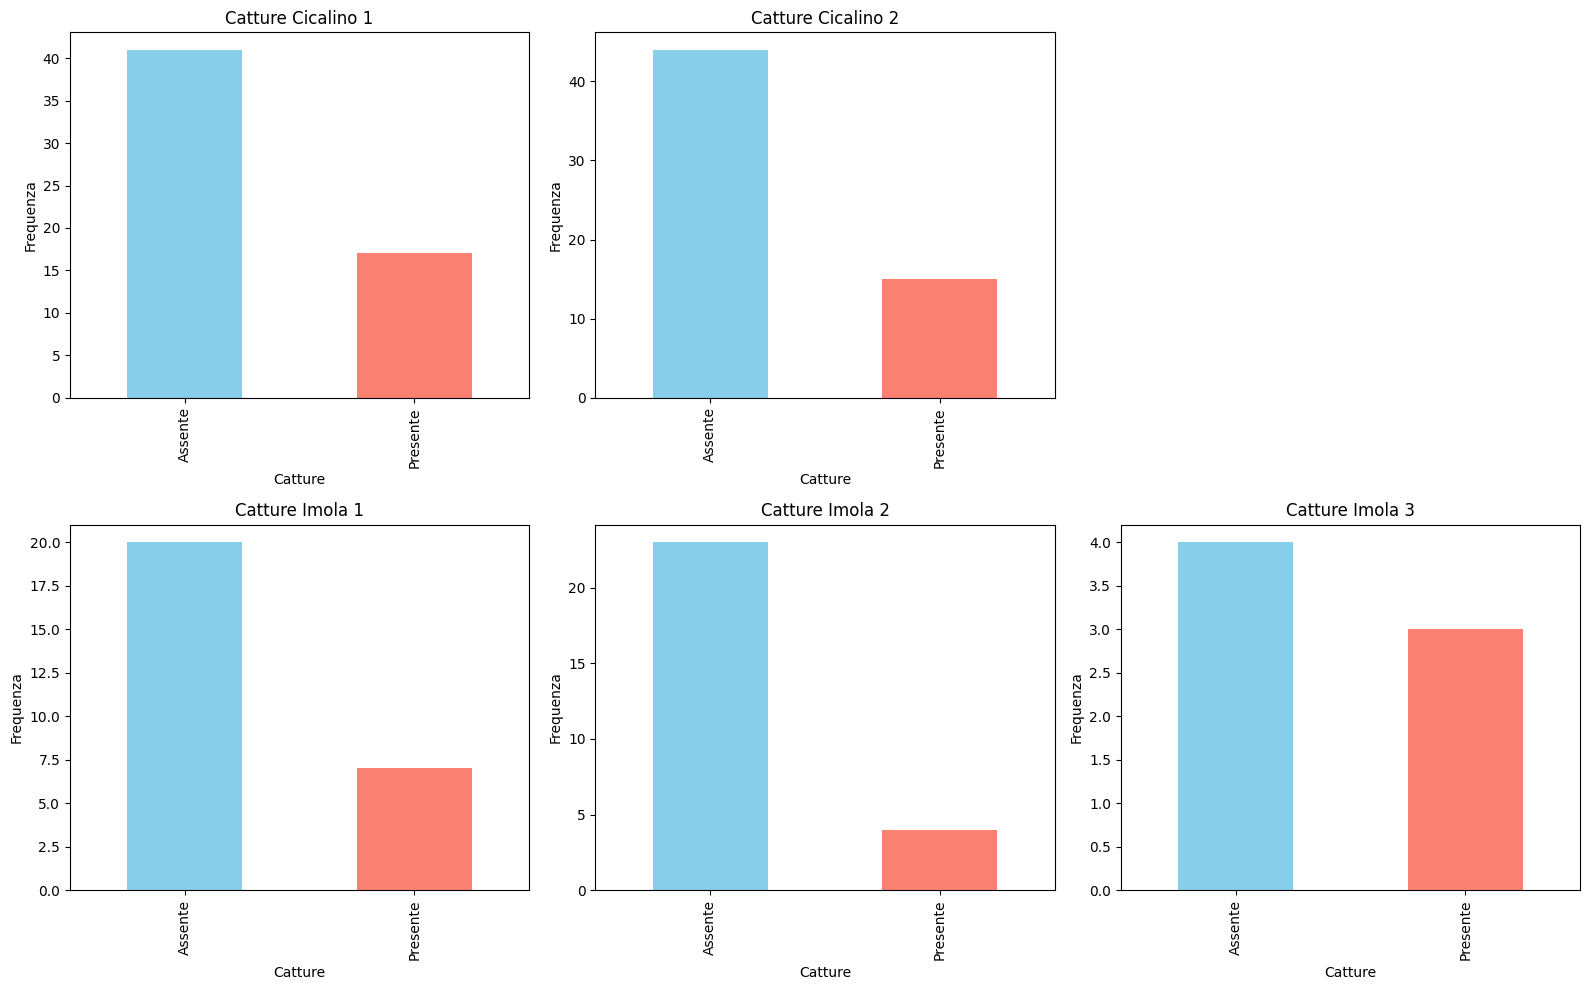

In [ ]:
#@title ##Target Analysis
def plot_new_catches_histogram(df, catch_column='Nuove catture (per evento)', title='', ax=None):
    """
    Traccia un istogramma che mostra la presenza o l'assenza di nuove catture.

    Parametri:
    df (pandas.DataFrame): Il dataframe contenente i dati.
    catch_column (str): Il nome della colonna che indica le nuove catture.
    title (str): Titolo del grafico.
    ax (matplotlib.axes.Axes): Oggetto Axes per il grafico.
    """
    # Crea una nuova colonna per 'Presente'/'Assente' in base al valore della colonna delle catture
    df['New Catches Present'] = df[catch_column].apply(lambda x: 'Assente' if x == 0 else 'Presente')

    # Traccia l'istogramma sull'oggetto ax fornito
    if ax is not None:
        df['New Catches Present'].value_counts().plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
        ax.set_title(title)
        ax.set_xlabel('Catture')
        ax.set_ylabel('Frequenza')

fig, axs = plt.subplots(2, 3, figsize=(16, 10))

plot_new_catches_histogram(df_CC1, title='Catture Cicalino 1', ax=axs[0, 0])
plot_new_catches_histogram(df_CC2, title='Catture Cicalino 2', ax=axs[0, 1])
plot_new_catches_histogram(df_CI1, title='Catture Imola 1', ax=axs[1, 0])
plot_new_catches_histogram(df_CI2, title='Catture Imola 2', ax=axs[1, 1])
plot_new_catches_histogram(df_CI3, title='Catture Imola 3', ax=axs[1, 2])

axs[0, 2].axis('off')

plt.tight_layout()
plt.show()

# Preprocessing e Feature Engineering
La preparazione dei dati è stata essenziale per garantire un'analisi accurata. Per i dati delle catture, sono state rimosse colonne e righe non rilevanti. Per i dati meteo, è stata applicata una riduzione di dimensionalità eliminando le colonne fortemente correlate ad altre variabili, garantendo la conservazione delle informazioni principali grazie ad analisi di correlazione e PCA. Dato che il dataset meteorologico aveva granularità oraria, mentre quello delle catture di insetti era giornaliere sono state create nuove feature sintetiche. Successivamente è stato fatto un join dei dati metereologici e delle catture corrispondenti.


## Capture Data
Nel processo di preparazione dei dati per i CSV delle catture, abbiamo eseguito diverse operazioni di pulizia per rimuovere informazioni non pertinenti. In primo luogo, abbiamo eliminato le colonne "Recensito" e "Numero di insetti" poiché non rilevanti ai fini dell'analisi. Successivamente, abbiamo rimosso le righe contenenti il valore "Cleaning", dato che rappresentavano dati non utili per il contesto del progetto. Infine, la colonna "Evento" è stata eliminata, poiché priva di significato una volta completata la rimozione delle righe associate al valore "Cleaning". Queste operazioni ci hanno permesso di ottenere un dataset più pulito e focalizzato.

In [ ]:
def capture_data_cleaner(input_folder, output_folder):
    """
    Processa tutti i file CSV della variabile target: filtra le righe di Cleaning e le colonne di Numero di insetti, Recensito, Evento

    :param input_folder: Cartella contenente i file CSV da processare.
    :param output_folder: Cartella dove salvare i file processati.
    """
    # Creare la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV
            df = pd.read_csv(file_path)

            # Droppa le righe con "Cleaning"
            df = df[df["Evento"] != "Cleaning"]

            # Aggiungi la colonna 'Numero di insetti catturati' che è la somma cumulativa
            df['Numero di insetti catturati'] = df['Nuove catture (per evento)'].cumsum()

            # Aggiungi la colonna 'Cattura presente' che sarà 1 se 'Nuove catture (per evento)' è diverso da 0, altrimenti 0
            df['Cattura presente'] = df['Nuove catture (per evento)'].apply(lambda x: 1 if x != 0 else 0)

            # Elimina le colonne non necessarie
            df = df.drop(columns=['Numero di insetti', 'Recensito', 'Evento'])

            #Estrae la data dal DateTime eliminando l'ora
            df['DateTime'] = df['DateTime'].str.split(' ').str[0]

            #Converte il formato di DateTime in %y/%m/%d
            df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d.%m.%Y').dt.strftime('%Y-%m-%d')

            # Salva il file processato
            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=False)
            print(f"File preprocessato e salvato: {output_path}")

In [ ]:
capture_data_cleaner(NEW_CAPTURE_DATA, NEW_CAPTURE_DATA)

File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 1).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Cicalino 2).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 3).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Imola 2).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Capture/grafico-delle-catture (Cicalino 1).csv


In [ ]:
df = pd.read_csv(NEW_CAPTURE_DATA + "/grafico-delle-catture (Imola 3).csv")

df

DateTime  Nuove catture (per evento)  Numero di insetti catturati  \
0  2024-08-17                           0                            0   
1  2024-08-18                           0                            0   
2  2024-08-19                           0                            0   
3  2024-08-20                           1                            1   
4  2024-08-21                           0                            1   
5  2024-08-22                           1                            2   
6  2024-08-23                           1                            3   

   Cattura presente  
0                 0  
1                 0  
2                 0  
3                 1  
4                 0  
5                 1  
6                 1

## Weather Data
Per i CSV relativi al meteo, è stato adottato un approccio analitico per ridurre la dimensionalità e ottimizzare le informazioni da utilizzare nelle analisi successive. In primo luogo, sono state rimosse le colonne "low" e "high" poiché mostravano una forte correlazione con altre variabili. Questa scelta è stata validata attraverso analisi di correlazione e PCA condotte con JMP, garantendo così che la loro eliminazione non comportasse una perdita significativa di informazione. Inoltre, abbiamo eliminato i giorni che non presentavano tutte e 24 le ore di rilevazione, al fine di evitare stime aggregate su giorni incompleti, che avrebbero potuto introdurre incoerenze nella successiva fase di clustering.

In [ ]:
def weather_data_cleaner(input_folder, output_folder):
    """
    Processa tutti i file CSV della variabile target: filtra le colonne di low e high

    :param input_folder: Cartella contenente i file CSV da processare.
    :param output_folder: Cartella dove salvare i file processati.
    """
    # Creare la cartella di output se non esiste
    os.makedirs(output_folder, exist_ok=True)

    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV
            df = pd.read_csv(file_path)

            # Elimina le colonne non necessarie
            df = df.drop(columns=['low', 'high'])

            # Salva il file processato
            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=False)
            print(f"File preprocessato e salvato: {output_path}")

In [ ]:
weather_data_cleaner(NEW_WEATHER_DATA, NEW_WEATHER_DATA)

File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 2).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 1).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 3).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 2).csv
File preprocessato e salvato: /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 1).csv


In [ ]:
df = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 1).csv")

df

DateTime  Media Temperatura  Media Umidità
0     05.07.2024 15:00:00              31.65          37.08
1     05.07.2024 16:00:00              31.45          33.55
2     05.07.2024 17:00:00              31.66          34.98
3     05.07.2024 18:00:00              30.08          42.39
4     05.07.2024 19:00:00              28.78          47.54
...                   ...                ...            ...
1163  23.08.2024 02:00:00              19.57          87.25
1164  23.08.2024 03:00:00              19.92          86.89
1165  23.08.2024 04:00:00              19.57          88.57
1166  23.08.2024 05:00:00              18.58          92.14
1167  23.08.2024 06:00:00              18.36          93.30

[1168 rows x 3 columns]

In [ ]:
def remove_incomplete_days(input_folder, output_folder, datetime_column):
    """
    Rimuove i giorni incompleti da tutti i file CSV in una cartella di input e salva i file filtrati in una cartella di output.

    Un giorno è considerato completo se contiene tutte le 24 ore (da 0 a 23).

    :param input_folder: Percorso della cartella contenente i file CSV di input
    :param output_folder: Percorso della cartella dove verranno salvati i file CSV filtrati
    :param datetime_column: Nome della colonna contenente i timestamp nel formato 'd.m.y H:M:S'
    """
    # Assicurati che la cartella di output esista
    os.makedirs(output_folder, exist_ok=True)

    # Ottieni tutti i file CSV nella cartella di input
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file)

        # Carica il file CSV in un DataFrame
        df = pd.read_csv(input_path)

        # Converte la colonna datetime nel formato datetime di pandas
        df[datetime_column] = pd.to_datetime(df[datetime_column], format='%d.%m.%Y %H:%M:%S')

        # Estrai la data e l'ora in colonne separate
        df['Date'] = df[datetime_column].dt.date
        df['Hour'] = df[datetime_column].dt.hour

        # Raggruppa per data e verifica che il numero di ore uniche sia esattamente 24
        complete_days = df.groupby('Date')['Hour'].nunique().apply(lambda x: x == 24)

        # Filtra il DataFrame per includere solo i giorni completi
        valid_days = complete_days[complete_days].index
        filtered_df = df[df['Date'].isin(valid_days)]

        # Rimuovi le colonne temporanee 'Date' e 'Hour'
        filtered_df = filtered_df.drop(columns=['Date', 'Hour'])

        # Rimuovi la conversione automatica della data durante il salvataggio
        # Usa il formato originale per la colonna datetime
        filtered_df[datetime_column] = filtered_df[datetime_column].dt.strftime('%d.%m.%Y %H:%M:%S')

        # Salva il DataFrame filtrato nella cartella di output
        filtered_df.to_csv(output_path, index=False)

        print(f"Processato: {file} -> Salvato in {output_path}")


In [ ]:
remove_incomplete_days(NEW_WEATHER_DATA, NEW_WEATHER_DATA, 'DateTime')

Processato: dati-meteo-storici (Cicalino 2).csv -> Salvato in /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 2).csv
Processato: dati-meteo-storici (Cicalino 1).csv -> Salvato in /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 1).csv
Processato: dati-meteo-storici (Imola 3).csv -> Salvato in /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 3).csv
Processato: dati-meteo-storici (Imola 2).csv -> Salvato in /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 2).csv
Processato: dati-meteo-storici (Imola 1).csv -> Salvato in /content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 1).csv


In [ ]:
df_WI2 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Imola 2).csv")
df_WI2

DateTime  Media Temperatura  Media Umidità
0    31.07.2024 00:00:00              21.55          66.85
1    31.07.2024 01:00:00              21.83          66.76
2    31.07.2024 02:00:00              22.70          64.72
3    31.07.2024 03:00:00              21.69          68.60
4    31.07.2024 04:00:00              21.10          70.59
..                   ...                ...            ...
547  22.08.2024 19:00:00              29.05          62.79
548  22.08.2024 20:00:00              27.23          68.24
549  22.08.2024 21:00:00              26.02          73.82
550  22.08.2024 22:00:00              24.50          81.22
551  22.08.2024 23:00:00              23.28          88.14

[552 rows x 3 columns]

Abbiamo effettuato un analisi per controllare la presenza di eventuali valori nulli all'interno dei csv.

In [ ]:
# Ottieni tutti i file CSV nella cartella di input
csv_files = [f for f in os.listdir(NEW_WEATHER_DATA) if f.endswith('.csv')]

for file in csv_files:
  input_path = os.path.join(NEW_WEATHER_DATA, file)
  # Carica il file CSV in un DataFrame
  df = pd.read_csv(input_path)
  sum = df.isnull().sum()
  print(input_path)
  print(sum)

/content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 2).csv
DateTime             0
Media Temperatura    0
Media Umidità        0
dtype: int64
/content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Cicalino 1).csv
DateTime             0
Media Temperatura    0
Media Umidità        0
dtype: int64
/content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 3).csv
DateTime             0
Media Temperatura    0
Media Umidità        0
dtype: int64
/content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 2).csv
DateTime             0
Media Temperatura    0
Media Umidità        0
dtype: int64
/content/drive/MyDrive/ISBI/Project/Dataset/New Weather/dati-meteo-storici (Imola 1).csv
DateTime             0
Media Temperatura    0
Media Umidità        0
dtype: int64


## Clustering
È stato osservato che il dataset meteo presentava una granularità oraria, mentre quello relativo alle catture di insetti aveva una risoluzione giornaliera. Per allineare i dati, anziché effettuare una semplice media giornaliera delle variabili meteorologiche, sono state create feature sintetiche basate su intervalli temporali orari. Questi intervalli sono stati definiti utilizzando un approccio basato su finestre mobili senza sovrapposizioni. La definizione degli intervalli è stata ottenuta tramite un'analisi di clustering.

In primo luogo, il clustering gerarchico sulle variabili temperatura e umidità ha evidenziato la presenza di due cluster principali, corrispondenti a due fasce temporali principali: mattina e notte. Successivamente, il metodo k-means ha consentito di affinare ulteriormente la segmentazione degli intervalli orari all’interno dei cluster individuati. Per ciascun cluster è stata calcolata la media di temperatura e umidità, queste metriche sono state aggiunte al dataset come nuove feature sintetiche con risoluzione giornaliera.

In [ ]:
def hierarchical_clustering(df, columns, max_clusters=10, flag='False', best_num_clusters = 2):
    """
    Esegue un clustering gerarchico multivariato sulle colonne specificate del DataFrame.

    :param df: DataFrame che contiene i dati da clusterizzare.
    :param columns: Lista dei nomi delle colonne su cui eseguire il clustering.
    :param max_clusters: Numero massimo di cluster da testare.
    :return: Un DataFrame con i cluster assegnati e il numero ottimale di cluster trovato.
    """
    # Normalizzare i dati
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df[columns])

    # Calcolare il linkage
    Z = linkage(data_scaled, method='ward')

    # Visualizzare il dendrogramma senza le etichette sull'asse x
    plt.figure(figsize=(10, 6))
    dendrogram(Z, no_labels=True)
    plt.title('Dendrogramma del Clustering Gerarchico')
    plt.xlabel('Indici dei campioni')
    plt.ylabel('Distanza')
    plt.show()

    if not flag:
      # Determinare il numero ottimale di cluster con il criterio della silhouette
      best_silhouette = -1

      for n_clusters in range(2, max_clusters + 1):
          labels = fcluster(Z, n_clusters, criterion='maxclust')
          silhouette_avg = silhouette_score(data_scaled, labels)
          if silhouette_avg > best_silhouette:
              best_silhouette = silhouette_avg
              best_num_clusters = n_clusters

    # Assegnare i cluster al DataFrame
    df['Cluster'] = fcluster(Z, best_num_clusters, criterion='maxclust')

    print(f"Numero ottimale di cluster: {best_num_clusters}")
    return df, best_num_clusters

In [ ]:
df_WC1 = pd.read_csv(NEW_WEATHER_DATA + "/dati-meteo-storici (Cicalino 1).csv")

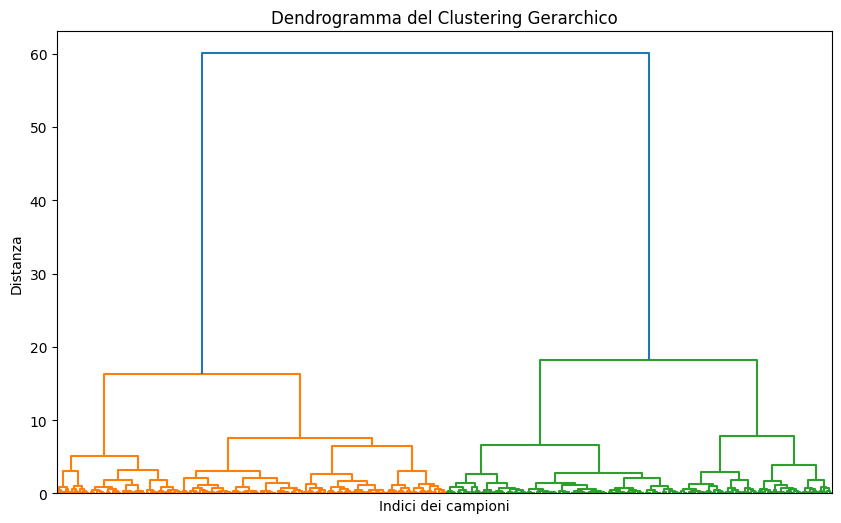

Numero ottimale di cluster: 2


In [ ]:
# Supponiamo che il DataFrame sia df con le colonne 'Media Temperature' e 'Media Umidità'
df_cleaned, optimal_clusters = hierarchical_clustering(df_WC1, ['Media Temperatura', 'Media Umidità'], flag='False', best_num_clusters=2)

In [ ]:
df_cleaned

DateTime  Media Temperatura  Media Umidità  Cluster
0     06.07.2024 00:00:00              15.44          92.00        1
1     06.07.2024 01:00:00              14.72          93.90        1
2     06.07.2024 02:00:00              14.31          95.22        1
3     06.07.2024 03:00:00              14.39          96.63        1
4     06.07.2024 04:00:00              14.11          97.14        1
...                   ...                ...            ...      ...
1147  22.08.2024 19:00:00              31.46          49.94        2
1148  22.08.2024 20:00:00              27.95          60.85        2
1149  22.08.2024 21:00:00              25.26          69.31        1
1150  22.08.2024 22:00:00              23.35          76.70        1
1151  22.08.2024 23:00:00              21.74          79.54        1

[1152 rows x 4 columns]

In [ ]:
def find_intervals_to_cover_day(df, cluster_column='Cluster', time_column='DateTime', temp_column='Media Temperatura', humidity_column='Media Umidità', n_clusters=2, format='%d.%m.%Y %H:%M:%S'):
    """
    Trova gli intervalli di ore che coprono l'intera giornata, raggruppando le ore in cluster basati su medie di temperatura e umidità.

    :param df: DataFrame contenente i dati, con colonne per la data, la temperatura e l'umidità.
    :param cluster_column: Colonna che rappresenta i cluster (default: 'Cluster').
    :param time_column: Colonna con i dati temporali (default: 'DateTime').
    :param temp_column: Colonna con i valori di temperatura (default: 'Media Temperatura').
    :param humidity_column: Colonna con i valori di umidità (default: 'Media Umidità').
    :param n_clusters: Numero di cluster da creare (default: 2).
    :return: Un dizionario con i cluster come chiavi e una lista di intervalli di ore come valori.
    """
    # Converti la colonna DateTime in formato datetime se non lo è già
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column], format=format)

    # Convertiamo la colonna DateTime nel formato datetime
    df[time_column] = pd.to_datetime(df[time_column], format=format)

    # Aggiungiamo la colonna dell'ora
    df['Hour'] = df[time_column].dt.hour

    # Estraiamo le ore uniche
    hours = np.arange(24)

    # Creiamo un array di ore e le loro medie di temperatura e umidità
    hourly_averages = []
    for hour in hours:
        hourly_data = df[df['Hour'] == hour]
        avg_temp_of_hour = hourly_data[temp_column].mean()
        avg_humidity_of_hour = hourly_data[humidity_column].mean()
        hourly_averages.append([avg_temp_of_hour, avg_humidity_of_hour])

        # Stampa le medie per l'ora
        print(f"Ore {hour}: Media Temperatura = {avg_temp_of_hour:.2f}, Media Umidità = {avg_humidity_of_hour:.2f}")

    # Applichiamo K-means per creare i cluster
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(hourly_averages)
    labels = kmeans.labels_

    # Calcola il Silhouette Score
    silhouette_avg = silhouette_score(hourly_averages, labels)
    print(f"\nSilhouette Score per n_clusters = {n_clusters}: {silhouette_avg:.3f}\n")

    # Ora raggruppiamo le ore in base ai cluster
    intervals_dict = {}
    for cluster in range(n_clusters):
        # Troviamo le ore appartenenti a ciascun cluster
        cluster_hours = [hours[i] for i in range(len(hours)) if labels[i] == cluster]

        # Ordinare le ore all'interno del cluster
        cluster_hours.sort()

        # Creiamo intervalli contigui per il cluster
        intervals = []
        start_hour = cluster_hours[0]
        for i in range(1, len(cluster_hours)):
            if cluster_hours[i] != cluster_hours[i - 1] + 1:
                intervals.append((start_hour, cluster_hours[i - 1] + 1))
                start_hour = cluster_hours[i]
        intervals.append((start_hour, cluster_hours[-1] + 1))

        intervals_dict[cluster] = intervals

    print("")

    # Stampa gli intervalli per ogni cluster
    for cluster, intervals in intervals_dict.items():
        print(f"Intervalli scelti per il cluster {cluster}: {intervals}")

    return intervals_dict


In [ ]:
def calculate_averages_for_intervals(df, intervals_dict):
    """
    Calcola le medie e le deviazioni standard della temperatura e dell'umidità per ciascun cluster, basandosi sugli intervalli di ore.

    :param df: DataFrame contenente i dati, con colonne per la data, la temperatura, l'umidità e l'ora.
    :param intervals_dict: Dizionario che associa a ciascun cluster una lista di intervalli di ore.
    :return: Un DataFrame con le medie e le deviazioni standard per ogni cluster, per ciascun giorno.
    """

    # Crea un DataFrame vuoto per memorizzare i risultati
    result_df = pd.DataFrame()

    # Per ogni cluster, calcoliamo la media della temperatura, umidità e la deviazione standard
    for cluster, intervals in intervals_dict.items():
        print(f"\nCalcolando medie e deviazioni standard per il cluster {cluster}...")

        # Estraiamo tutte le ore che coprono gli intervalli per il cluster
        hours_to_consider = []
        for interval in intervals:
            start_hour, end_hour = interval
            hours_to_consider.extend(range(start_hour, end_hour))  # Estendiamo l'intervallo di ore

        # Filtriamo i dati per ottenere solo le righe con le ore da considerare
        filtered_df = df[df['Hour'].isin(hours_to_consider)]

        # Ora, calcoliamo la media e la deviazione standard della temperatura e dell'umidità per tutti i giorni, per il cluster
        temp_avg = filtered_df.groupby(filtered_df['DateTime'].dt.date)['Media Temperatura'].mean()  # Media per tutti i giorni
        humidity_avg = filtered_df.groupby(filtered_df['DateTime'].dt.date)['Media Umidità'].mean()  # Media per tutti i giorni

        #temp_std = filtered_df.groupby(filtered_df['DateTime'].dt.date)['Media Temperatura'].std()  # Deviazione standard per la temperatura
        #humidity_std = filtered_df.groupby(filtered_df['DateTime'].dt.date)['Media Umidità'].std()  # Deviazione standard per l'umidità

        # Aggiungiamo i risultati per il cluster al DataFrame
        result_df[f'Temperatura Media {cluster+1}'] = temp_avg
        #result_df[f'Temperatura Std {cluster+1}'] = temp_std
        result_df[f'Umidità Media {cluster+1}'] = humidity_avg
        #result_df[f'Umidità Std {cluster+1}'] = humidity_std

        # Stampa le medie e deviazioni standard
        #print(f"Media Temperatura per il cluster {cluster}: {temp_avg.mean()} (Deviazione Standard: {temp_std.mean()})")
        #print(f"Media Umidità per il cluster {cluster}: {humidity_avg.mean()} (Deviazione Standard: {humidity_std.mean()})")

    # Riordiniamo le colonne per metterla prima
    cols = [col for col in result_df.columns]
    result_df = result_df[cols]

    return result_df

In [ ]:
intervals = find_intervals_to_cover_day(df_cleaned, n_clusters = optimal_clusters)
final_data = calculate_averages_for_intervals(df_cleaned, intervals_dict=intervals)

final_data

Ore 0: Media Temperatura = 21.25, Media Umidità = 79.33
Ore 1: Media Temperatura = 20.61, Media Umidità = 80.79
Ore 2: Media Temperatura = 20.05, Media Umidità = 81.79
Ore 3: Media Temperatura = 19.45, Media Umidità = 83.45
Ore 4: Media Temperatura = 19.05, Media Umidità = 84.98
Ore 5: Media Temperatura = 18.87, Media Umidità = 85.71
Ore 6: Media Temperatura = 18.67, Media Umidità = 86.57
Ore 7: Media Temperatura = 19.35, Media Umidità = 86.64
Ore 8: Media Temperatura = 23.64, Media Umidità = 74.37
Ore 9: Media Temperatura = 29.54, Media Umidità = 54.21
Ore 10: Media Temperatura = 32.59, Media Umidità = 44.65
Ore 11: Media Temperatura = 33.97, Media Umidità = 40.83
Ore 12: Media Temperatura = 34.44, Media Umidità = 39.45
Ore 13: Media Temperatura = 34.60, Media Umidità = 39.93
Ore 14: Media Temperatura = 34.51, Media Umidità = 41.53
Ore 15: Media Temperatura = 34.42, Media Umidità = 41.98
Ore 16: Media Temperatura = 34.43, Media Umidità = 41.65
Ore 17: Media Temperatura = 34.03, Media 

Temperatura Media 1  Umidità Media 1  Temperatura Media 2  \
DateTime                                                                
2024-07-06            28.068333        52.681667            16.616667   
2024-07-07            26.240000        64.672500            20.795833   
2024-07-08            30.686667        49.985833            20.651667   
2024-07-09            33.271667        32.854167            18.468333   
2024-07-10            33.679167        43.350833            19.140833   
2024-07-11            32.833333        38.302500            19.691667   
2024-07-12            33.193333        37.624167            19.145833   
2024-07-13            31.214167        52.790000            19.769167   
2024-07-14            32.699167        47.706667            19.221667   
2024-07-15            34.477500        35.708333            19.474167   
2024-07-16            33.145000        39.220000            19.781667   
2024-07-17            34.110000        38.890833            21.219167   
2024-07-18            34.335000        34.755000            19.773333   
2024-07-19            34.434167        43.116667            20.999167   
2024-07-20            32.104167        47.380833            21.555000   
2024-07-21            32.616667        49.168333            20.586667   
2024-07-22            28.247500        63.349167            21.897500   
2024-07-23            33.306667        45.502500            20.568333   
2024-07-24            33.236667        48.804167            22.595833   
2024-07-25            33.949167        40.075000            22.727500   
2024-07-26            34.170000        44.441667            20.898333   
2024-07-27            34.748333        37.346667            20.170000   
2024-07-28            35.249167        33.715000            19.473333   
2024-07-29            35.884167        37.537500            21.323333   
2024-07-30            36.613333        26.705833            24.790000   
2024-07-31            36.546667        33.418333            23.012500   
2024-08-01            34.630000        35.536667            21.489167   
2024-08-02            33.523333        51.492500            21.490833   
2024-08-03            31.971667        56.064167            22.197500   
2024-08-04            32.770000        44.685833            21.260000   
2024-08-05            34.538333        38.614167            22.015000   
2024-08-06            33.661667        45.076667            21.244167   
2024-08-07            33.302500        44.164167            20.627500   
2024-08-08            33.519167        42.588333            20.432500   
2024-08-09            34.421667        42.286667            21.840833   
2024-08-10            36.728333        36.771667            22.729167   
2024-08-11            36.665833        38.329167            22.982500   
2024-08-12            36.652500        35.270000            23.081667   
2024-08-13            35.848333        36.585833            22.134167   
2024-08-14            34.394167        41.500000            21.684167   
2024-08-15            30.205833        51.722500            21.390833   
2024-08-16            33.016667        44.371667            21.729167   
2024-08-17            31.480833        49.146667            22.907500   
2024-08-18            26.132500        74.983333            20.554167   
2024-08-19            26.468333        62.549167            19.575833   
2024-08-20            29.415000        53.370833            19.177500   
2024-08-21            30.771667        53.205000            21.834167   
2024-08-22            32.665833        46.699167            20.821667   

            Umidità Media 2  
DateTime                     
2024-07-06        91.813333  
2024-07-07        88.785000  
2024-07-08        88.301667  
2024-07-09        74.440000  
2024-07-10        74.536667  
2024-07-11        70.470000  
2024-07-12        77.866667  
2024-07-13        85.484167  
2024-07-14        89.750833  
2024-07-15        78.523333  
2

## Preprocessing Application
Applicazione del preprocessing a tutti i csv.

In [ ]:
def preprocess_csv_files(input_folder, output_folder, max_clusters=10, flag='False', best_num_clusters=2):
    """
    Elabora i file CSV nella cartella di input, applicando il clustering gerarchico, trovando gli intervalli temporali
    e calcolando le medie per ogni intervallo. I risultati vengono salvati nella cartella di output.

    Parametri:
    input_folder (str): Cartella contenente i file CSV da elaborare.
    output_folder (str): Cartella in cui salvare i file elaborati.
    max_clusters (int): Numero massimo di cluster da considerare nel clustering gerarchico.
    flag (str): Flag per determinare il comportamento del clustering.
    best_num_clusters (int): Numero ottimale di cluster da utilizzare.
    """
    # Controlla se la cartella di output esiste, se no la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Elenco dei file CSV nella cartella di input
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        df = pd.read_csv(file_path)

        # Esegui il clustering gerarchico
        df_clustered, optimal_clusters = hierarchical_clustering(df, ['Media Temperatura', 'Media Umidità'], max_clusters, flag, best_num_clusters)

        # Trova gli intervalli per coprire la giornata
        intervals_dict = find_intervals_to_cover_day(df_clustered, n_clusters=optimal_clusters)

        # Calcola le medie e deviazioni standard per ogni intervallo
        result_df = calculate_averages_for_intervals(df_clustered, intervals_dict)

        # Salva il risultato in un nuovo CSV nella cartella di output
        output_file_path = os.path.join(output_folder, f"{file}")
        result_df.to_csv(output_file_path, index=True)
        print(f"File elaborato e salvato come: {output_file_path}")

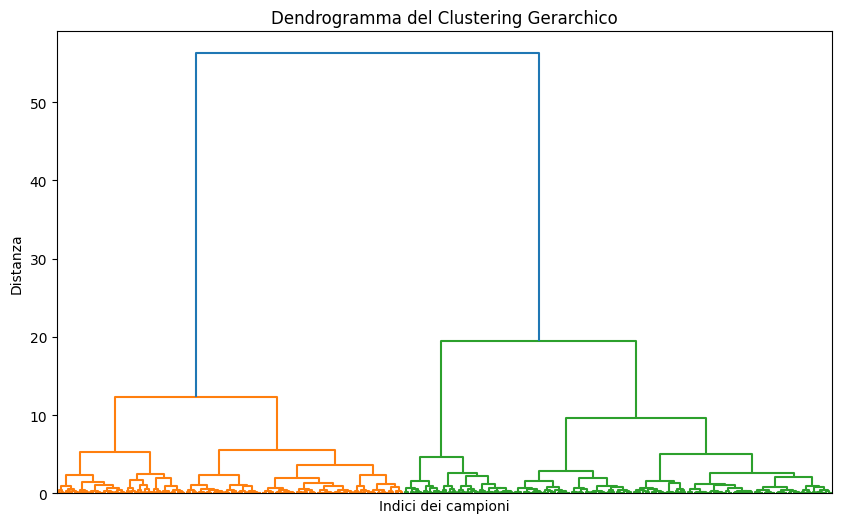

Numero ottimale di cluster: 2
Ore 0: Media Temperatura = 21.31, Media Umidità = 80.00
Ore 1: Media Temperatura = 20.85, Media Umidità = 80.81
Ore 2: Media Temperatura = 20.18, Media Umidità = 82.41
Ore 3: Media Temperatura = 19.59, Media Umidità = 84.30
Ore 4: Media Temperatura = 19.17, Media Umidità = 85.94
Ore 5: Media Temperatura = 19.04, Media Umidità = 86.75
Ore 6: Media Temperatura = 18.74, Media Umidità = 88.11
Ore 7: Media Temperatura = 21.04, Media Umidità = 81.92
Ore 8: Media Temperatura = 26.86, Media Umidità = 61.61
Ore 9: Media Temperatura = 30.57, Media Umidità = 50.36
Ore 10: Media Temperatura = 32.79, Media Umidità = 43.71
Ore 11: Media Temperatura = 34.25, Media Umidità = 39.76
Ore 12: Media Temperatura = 35.23, Media Umidità = 37.62
Ore 13: Media Temperatura = 35.41, Media Umidità = 38.12
Ore 14: Media Temperatura = 35.28, Media Umidità = 39.74
Ore 15: Media Temperatura = 35.15, Media Umidità = 40.68
Ore 16: Media Temperatura = 34.71, Media Umidità = 41.13
Ore 17: Med

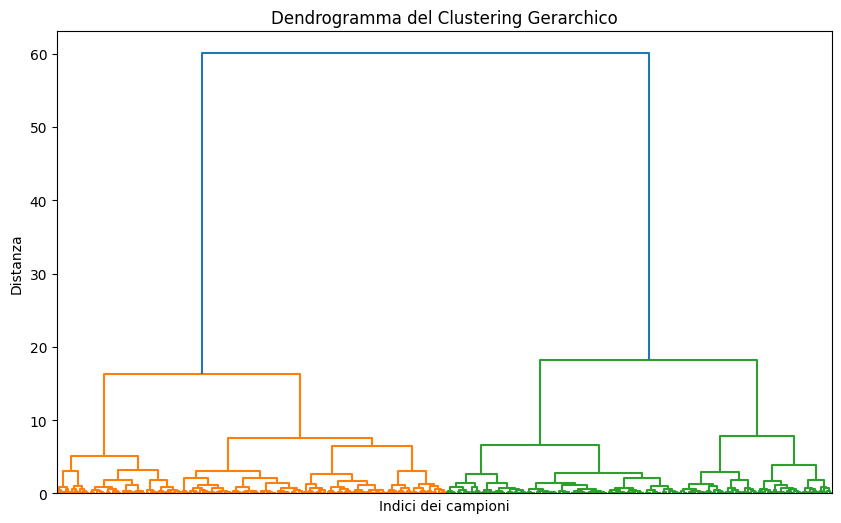

Numero ottimale di cluster: 2
Ore 0: Media Temperatura = 21.25, Media Umidità = 79.33
Ore 1: Media Temperatura = 20.61, Media Umidità = 80.79
Ore 2: Media Temperatura = 20.05, Media Umidità = 81.79
Ore 3: Media Temperatura = 19.45, Media Umidità = 83.45
Ore 4: Media Temperatura = 19.05, Media Umidità = 84.98
Ore 5: Media Temperatura = 18.87, Media Umidità = 85.71
Ore 6: Media Temperatura = 18.67, Media Umidità = 86.57
Ore 7: Media Temperatura = 19.35, Media Umidità = 86.64
Ore 8: Media Temperatura = 23.64, Media Umidità = 74.37
Ore 9: Media Temperatura = 29.54, Media Umidità = 54.21
Ore 10: Media Temperatura = 32.59, Media Umidità = 44.65
Ore 11: Media Temperatura = 33.97, Media Umidità = 40.83
Ore 12: Media Temperatura = 34.44, Media Umidità = 39.45
Ore 13: Media Temperatura = 34.60, Media Umidità = 39.93
Ore 14: Media Temperatura = 34.51, Media Umidità = 41.53
Ore 15: Media Temperatura = 34.42, Media Umidità = 41.98
Ore 16: Media Temperatura = 34.43, Media Umidità = 41.65
Ore 17: Med

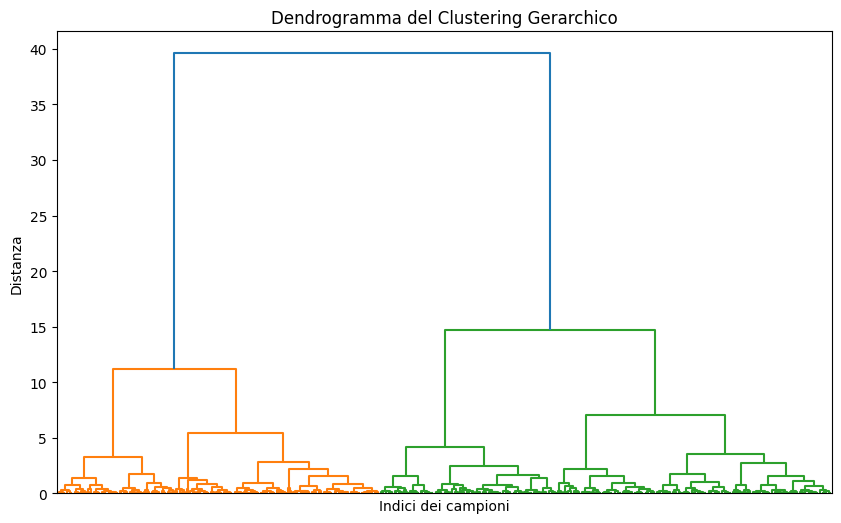

Numero ottimale di cluster: 2
Ore 0: Media Temperatura = 23.32, Media Umidità = 75.22
Ore 1: Media Temperatura = 23.01, Media Umidità = 75.94
Ore 2: Media Temperatura = 22.86, Media Umidità = 76.27
Ore 3: Media Temperatura = 22.53, Media Umidità = 77.12
Ore 4: Media Temperatura = 22.03, Media Umidità = 78.57
Ore 5: Media Temperatura = 21.96, Media Umidità = 79.08
Ore 6: Media Temperatura = 22.24, Media Umidità = 77.90
Ore 7: Media Temperatura = 23.16, Media Umidità = 75.33
Ore 8: Media Temperatura = 26.13, Media Umidità = 65.10
Ore 9: Media Temperatura = 28.75, Media Umidità = 57.32
Ore 10: Media Temperatura = 30.88, Media Umidità = 51.63
Ore 11: Media Temperatura = 31.50, Media Umidità = 50.06
Ore 12: Media Temperatura = 32.66, Media Umidità = 46.83
Ore 13: Media Temperatura = 33.42, Media Umidità = 44.41
Ore 14: Media Temperatura = 33.97, Media Umidità = 42.91
Ore 15: Media Temperatura = 34.03, Media Umidità = 42.70
Ore 16: Media Temperatura = 33.56, Media Umidità = 43.93
Ore 17: Med

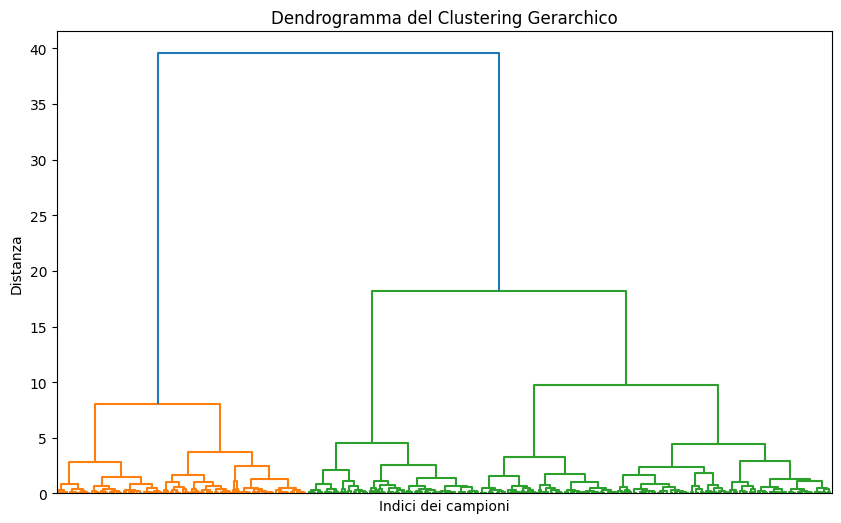

Numero ottimale di cluster: 2
Ore 0: Media Temperatura = 23.27, Media Umidità = 75.75
Ore 1: Media Temperatura = 22.95, Media Umidità = 76.99
Ore 2: Media Temperatura = 22.87, Media Umidità = 76.98
Ore 3: Media Temperatura = 22.47, Media Umidità = 78.09
Ore 4: Media Temperatura = 22.08, Media Umidità = 79.43
Ore 5: Media Temperatura = 21.83, Media Umidità = 79.86
Ore 6: Media Temperatura = 21.33, Media Umidità = 81.30
Ore 7: Media Temperatura = 21.69, Media Umidità = 81.09
Ore 8: Media Temperatura = 23.94, Media Umidità = 72.94
Ore 9: Media Temperatura = 26.77, Media Umidità = 63.92
Ore 10: Media Temperatura = 29.32, Media Umidità = 56.65
Ore 11: Media Temperatura = 31.64, Media Umidità = 50.61
Ore 12: Media Temperatura = 33.40, Media Umidità = 45.77
Ore 13: Media Temperatura = 34.04, Media Umidità = 43.86
Ore 14: Media Temperatura = 34.63, Media Umidità = 42.42
Ore 15: Media Temperatura = 34.78, Media Umidità = 41.95
Ore 16: Media Temperatura = 34.21, Media Umidità = 43.32
Ore 17: Med

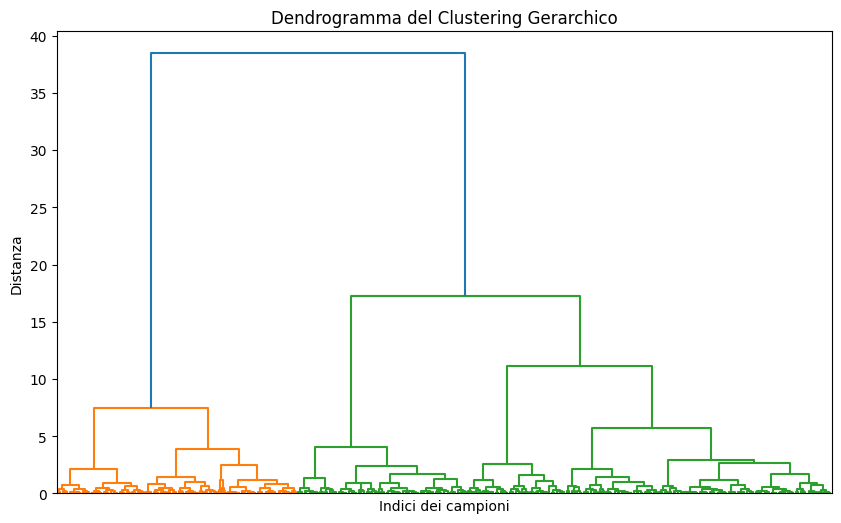

Numero ottimale di cluster: 2
Ore 0: Media Temperatura = 23.57, Media Umidità = 74.13
Ore 1: Media Temperatura = 23.15, Media Umidità = 75.31
Ore 2: Media Temperatura = 22.89, Media Umidità = 76.10
Ore 3: Media Temperatura = 22.60, Media Umidità = 76.73
Ore 4: Media Temperatura = 22.15, Media Umidità = 77.87
Ore 5: Media Temperatura = 21.88, Media Umidità = 79.14
Ore 6: Media Temperatura = 22.07, Media Umidità = 78.47
Ore 7: Media Temperatura = 22.82, Media Umidità = 76.35
Ore 8: Media Temperatura = 24.99, Media Umidità = 69.59
Ore 9: Media Temperatura = 28.06, Media Umidità = 59.97
Ore 10: Media Temperatura = 30.46, Media Umidità = 53.51
Ore 11: Media Temperatura = 31.82, Media Umidità = 50.29
Ore 12: Media Temperatura = 33.21, Media Umidità = 46.63
Ore 13: Media Temperatura = 34.02, Media Umidità = 44.13
Ore 14: Media Temperatura = 34.53, Media Umidità = 42.61
Ore 15: Media Temperatura = 34.61, Media Umidità = 42.46
Ore 16: Media Temperatura = 33.80, Media Umidità = 44.04
Ore 17: Med

In [ ]:
preprocess_csv_files(NEW_WEATHER_DATA, SYNTETIC_WEATHER_DATA, flag='False', best_num_clusters=2)

## Datasets Join
Dopo aver ridotto la granularità dei dati metereologici tramite clustering, la fase di preprocessing si è conclusa con l'operazione di join dei dati meteorologici e dei dati delle catture, effettuata sulla base delle date corrispondenti.  

In [ ]:
def join_csv_folders(weather_folder, capture_folder, output_folder):
    """
    Unisce i file CSV da due cartelle diverse sulla base di un nome comune e li salva in una cartella di output.

    Parametri:
    weather_folder (str): Percorso della cartella contenente i file CSV dei dati meteo.
    capture_folder (str): Percorso della cartella contenente i file CSV dei dati delle catture.
    output_folder (str): Percorso della cartella dove salvare i file CSV risultanti.
    """

    # Controlla se la cartella di output esiste, se no la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Elenco dei file nelle due cartelle
    weather_files = os.listdir(weather_folder)
    capture_files = os.listdir(capture_folder)

    # Identificazione dei file con nomi comuni
    for weather_file in weather_files:
        # Estrai il nome base dal file di weather
        base_name = weather_file.split("(")[-1].split(")")[0].strip()
        # Cerca il file corrispondente nella cartella delle catture
        capture_file = next((f for f in capture_files if base_name in f), None)

        if capture_file:
            # Costruisci i percorsi completi
            weather_path = os.path.join(weather_folder, weather_file)
            capture_path = os.path.join(capture_folder, capture_file)

            try:
                # Leggi i CSV
                df_weather = pd.read_csv(weather_path)
                df_capture = pd.read_csv(capture_path)

                # Unisci i dataset
                joined_df = pd.merge(df_weather, df_capture, on='DateTime')

                # Salva il risultato
                output_path = os.path.join(output_folder, f"joined_{base_name}.csv")
                joined_df.to_csv(output_path, index=False)
                print(f"File salvato: {output_path}")
            except Exception as e:
                print(f"Errore durante il join per {base_name}: {e}")
        else:
            print(f"Nessun file corrispondente trovato per {weather_file}")

In [ ]:
join_csv_folders(SYNTETIC_WEATHER_DATA, NEW_CAPTURE_DATA, JOINED_DATA)

File salvato: /content/drive/MyDrive/ISBI/Project/Dataset/Joined Data/joined_Imola 3.csv
File salvato: /content/drive/MyDrive/ISBI/Project/Dataset/Joined Data/joined_Cicalino 1.csv
File salvato: /content/drive/MyDrive/ISBI/Project/Dataset/Joined Data/joined_Cicalino 2.csv
File salvato: /content/drive/MyDrive/ISBI/Project/Dataset/Joined Data/joined_Imola 1.csv
File salvato: /content/drive/MyDrive/ISBI/Project/Dataset/Joined Data/joined_Imola 2.csv


In [ ]:
df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 1.csv")

df.head()

DateTime  Temperatura Media 1  Umidità Media 1  Temperatura Media 2  \
0  2024-07-06            16.616667        91.813333            28.068333   
1  2024-07-07            20.795833        88.785000            26.240000   
2  2024-07-08            20.651667        88.301667            30.686667   
3  2024-07-09            18.468333        74.440000            33.271667   
4  2024-07-10            19.140833        74.536667            33.679167   

   Umidità Media 2  Nuove catture (per evento)  Numero di insetti catturati  \
0        52.681667                         0.0                          0.0   
1        64.672500                         0.0                          0.0   
2        49.985833                         0.0                          0.0   
3        32.854167                         0.0                          0.0   
4        43.350833                         0.0                          0.0   

   Cattura presente  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

# Exploratory Data Analysis
La fase di analisi esplorativa dei dati (EDA) è stata posizionata dopo il preprocessing, poiché senza dati consistenti, l'unione non avrebbe permesso una rappresentazione adeguata. L'analisi delle relazioni tra le variabili è stata condotta tramite scatter plot, con la grandezza dei punti rappresentante le catture di insetti.

L'analisi esplorativa ha incluso visualizzazioni grafiche come i violin plots, che mostrano la distribuzione delle variabili numeriche, e la matrice di correlazione, che evidenzia le relazioni tra le variabili con tre diverse metriche (Pearson, Spearman e Kendall). È stata condotta un'analisi dell'autocorrelazione (ACF) per studiare la dipendenza tra le osservazioni correnti e quelle passate, seguita dall'analisi della funzione di Autocorrelazione Parziale (PACF) per isolare la correlazione diretta tra le osservazioni a ritardi intermedi.

L'analisi della stazionarietà della serie storica, effettuata tramite il test ADF, ha permesso di verificare la presenza di radici unitarie, determinando se la serie fosse stazionaria. Successivamente, è stata effettuata una decomposizione della stagionalità settimanale dei dati, originariamente mensili, per identificare eventuali cicli stagionali brevi che influenzassero le catture degli insetti.

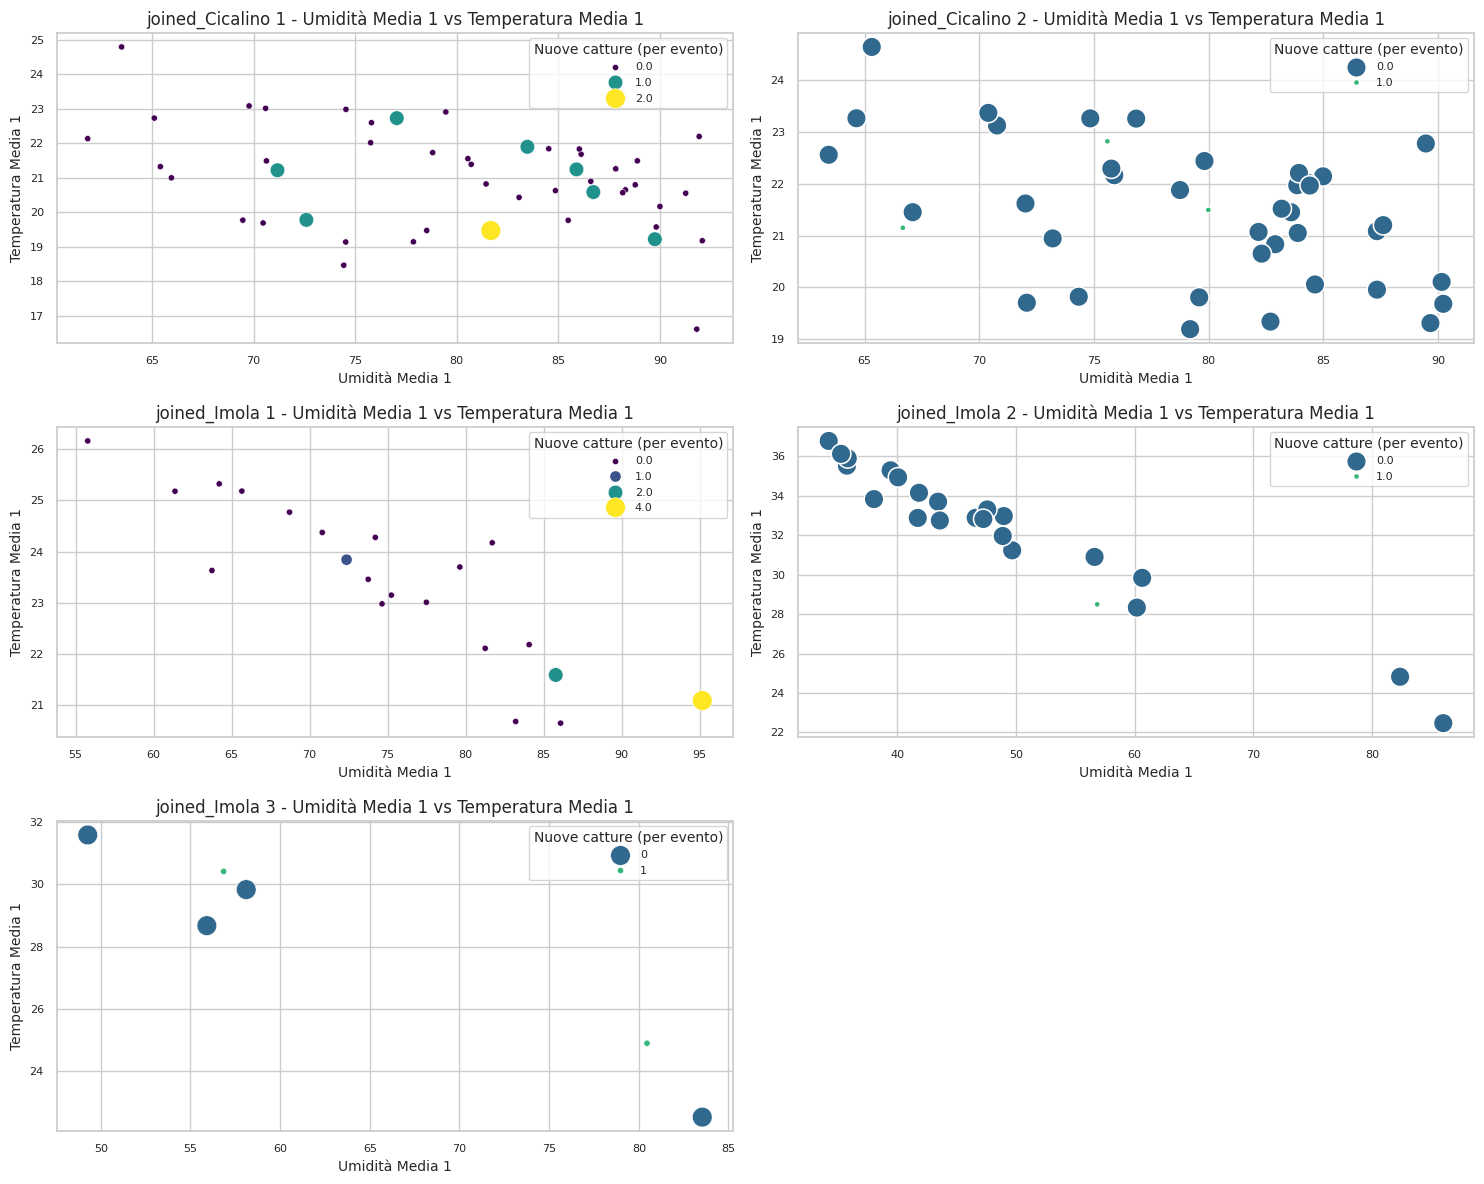

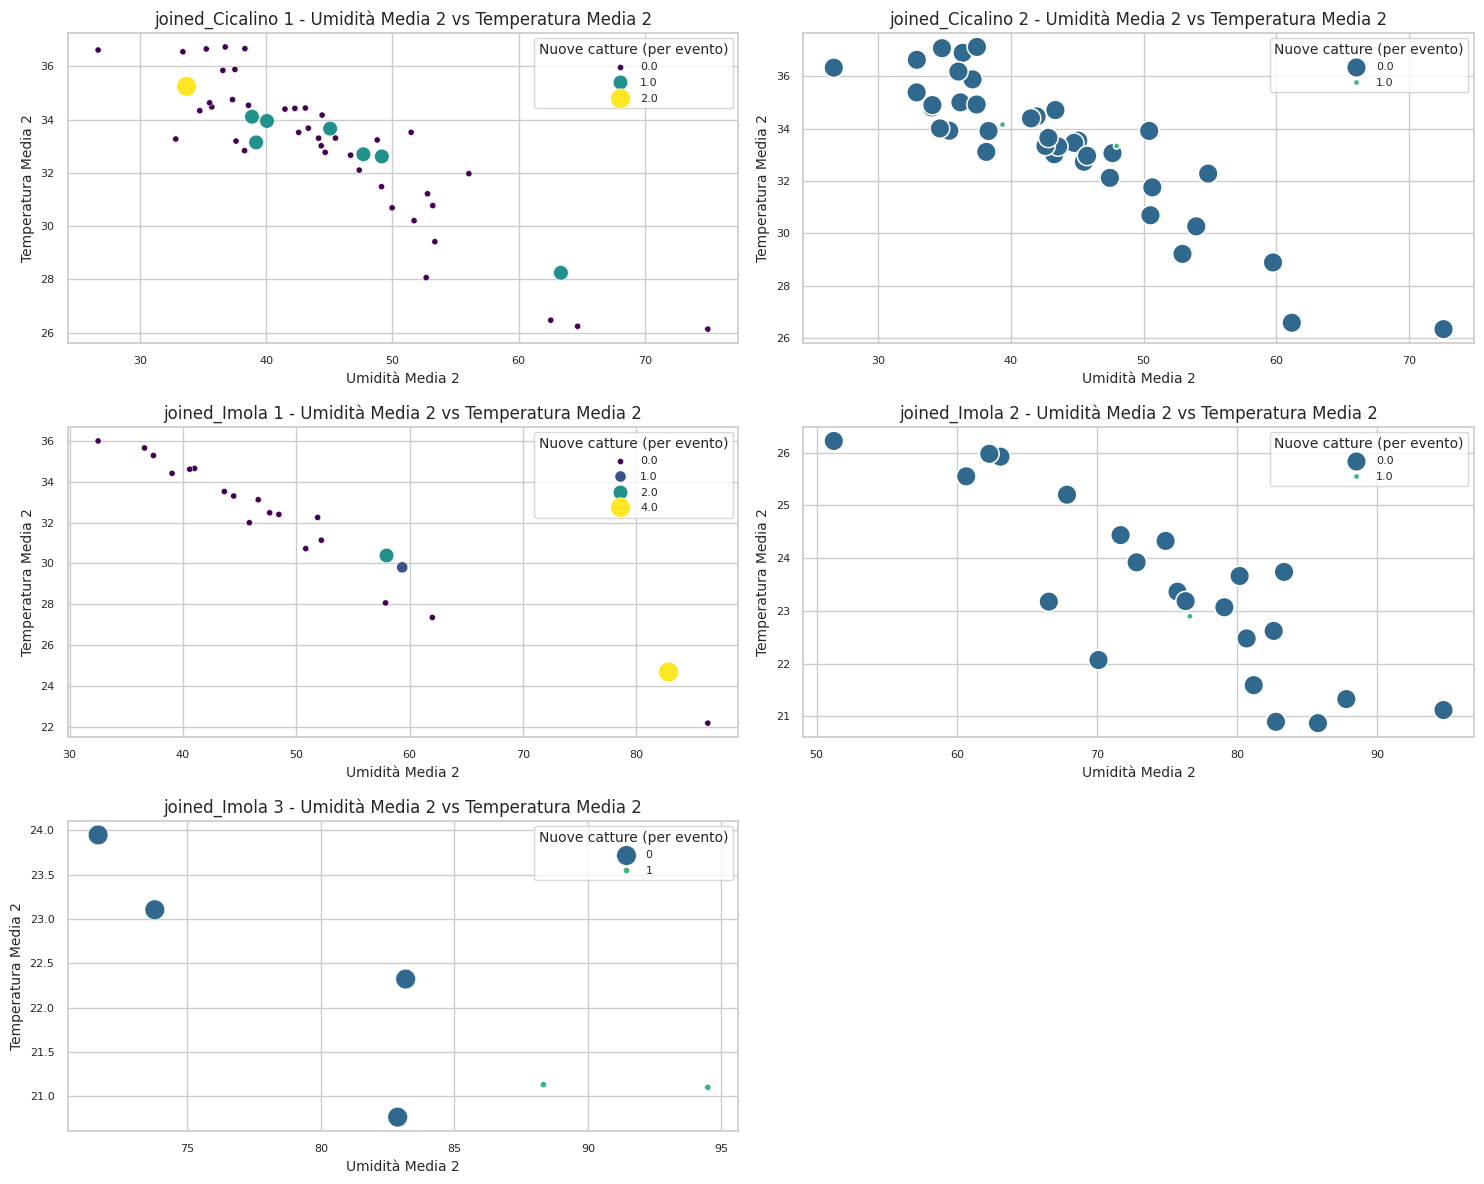

In [ ]:
#@title ## Explore Variable Relationship

sns.set_theme(style="whitegrid")

def plot_scatter_with_size(df, x_col, y_col, size_col, ax, title):
    """
    Crea un grafico a dispersione utilizzando due colonne di un dataframe,
    con la dimensione dei punti determinata da una terza colonna.

    Parametri:
    df (pandas.DataFrame): Il dataframe da plottare.
    x_col (str): Nome della colonna per l'asse x.
    y_col (str): Nome della colonna per l'asse y.
    size_col (str): Nome della colonna per determinare la dimensione dei punti.
    ax (matplotlib.axes.Axes): L'asse del subplot su cui disegnare il grafico a dispersione.
    title (str): Titolo da visualizzare sul grafico.
    """
    # Scatter plot con Seaborn
    scatter = sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        size=size_col,
        sizes=(20, 200),
        hue=size_col,
        palette="viridis",
        ax=ax
    )
    # Titolo e etichette degli assi
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(x_col, fontsize=10)
    ax.set_ylabel(y_col, fontsize=10)
    ax.tick_params(axis='both', labelsize=8)

    # Aggiungi la leggenda
    legend = ax.legend(
        title=size_col,
        loc='upper right',
        fontsize=8,
        title_fontsize=10
    )
    legend.set_frame_on(True)  # Cornice per la leggenda

def plot_all_csv_in_folder(folder_path, x_col, y_col, size_col):
    """
    Legge tutti i file CSV in una cartella e crea grafici a dispersione disposti in una griglia 3x2.

    Parametri:
    folder_path (str): Percorso della cartella contenente i file CSV.
    x_col (str): Nome della colonna per l'asse x.
    y_col (str): Nome della colonna per l'asse y.
    size_col (str): Nome della colonna per determinare la dimensione dei punti.
    """
    # Ottieni e ordina tutti i file CSV per nome
    csv_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.csv')])

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, file in enumerate(csv_files):
        if i >= len(axes):
            break

        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        # Verifica che tutte le colonne necessarie siano presenti
        if all(col in df.columns for col in [x_col, y_col, size_col]):
            # Usa il nome del file come parte del titolo
            file_title = file.split('.')[0]
            plot_scatter_with_size(df, x_col, y_col, size_col, axes[i], title=f'{file_title} - {x_col} vs {y_col}')
        else:
            # Mostra un messaggio di errore per le colonne mancanti
            axes[i].text(0.5, 0.5, 'Missing Columns', ha='center', va='center', fontsize=12, color='red')
            axes[i].set_title(f'{file} (Error)', fontsize=10)
            axes[i].axis('off')

    # Rimuovi subplot inutilizzati
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_csv_in_folder(JOINED_DATA, 'Umidità Media 1', 'Temperatura Media 1', 'Nuove catture (per evento)')
plot_all_csv_in_folder(JOINED_DATA, 'Umidità Media 2', 'Temperatura Media 2', 'Nuove catture (per evento)')

## Exploratory Cross-sectional Data Analysis
Analizzando i dati specifici di Cicalino 1, emerge che la Temperatura Media 1 mostra una correlazione moderata positiva con il Numero di insetti catturati (0.59, Pearson), mentre Umidità Media 1 e Umidità Media 2 presentano una forte correlazione positiva (0.74, Spearman). È interessante notare anche una correlazione negativa tra Umidità Media 1 e Temperatura Media 2 (-0.48, Kendall). Infine, il Numero di insetti catturati ha una distribuzione ristretta, concentrata prevalentemente tra i valori di 10 e 20.  Inoltre, è da segnalare un valore anomalo nei dati di Imola 1, in cui si osserva una correlazione molto elevata e negativa tra Temperatura Media 1 e Umidità Media 1 (-0.90, Kendall). Questa correlazione anomala potrebbe essere spiegata da una condizione particolare di microclima locale o da eventi meteorologici eccezionali, come un’improvvisa variazione di temperatura che potrebbe aver ridotto rapidamente l'umidità nell'aria.


In [ ]:
#@title ## Dataset Statistics

def dataset_statistics(df, columns = ['Temperatura Media 1', 'Umidità Media 1', 'Temperatura Media 2', 'Umidità Media 2', 'Numero di insetti catturati']):
    """
    Analizza le proprietà statistiche di un dataframe 'df'.
    Return: sommari statistici comprensivi di statistiche estese e risultati del test Augmented Dickey-Fuller.
    """
    numeric_df = df[columns]
    stats = numeric_df.describe(percentiles=[.25, .5, .75]).T
    stats['Skewness'] = numeric_df.skew()
    stats['Variance'] = numeric_df.var()
    stats['IQR'] = stats['75%'] - stats['25%']  # Range Interquartile

    # Esecuzione del test Augmented Dickey-Fuller su ciascuna colonna numerica.
    adf_results = {}
    for column in numeric_df.columns:
        adf_test = adfuller(numeric_df[column].dropna())
        adf_results[column] = {
            'ADF Statistic': adf_test[0],
            'p-value': adf_test[1],
            'Critical Values': adf_test[4]
        }

    # Merge dei risultati del test di ADF nel dataframe
    adf_df = pd.DataFrame(adf_results).T
    adf_df = adf_df[['ADF Statistic', 'p-value']]
    stats = pd.concat([stats, adf_df], axis=1)

    return stats

def analyze_all_csv_in_folder(folder_path):
    """
    Applica la funzione dataset_statistics a tutti i file CSV in una cartella.

    Parametri:
    folder_path (str): Percorso della cartella contenente i file CSV.

    Return:
    dict: Un dizionario dove le chiavi sono i nomi dei file e i valori sono i DataFrame delle statistiche.
    """
    results = {}

    csv_files = sorted([file for file in os.listdir(folder_path) if file.endswith('.csv')])

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path)
            # Applicazione delle statistiche
            stats = dataset_statistics(df)
            results[file] = stats
        except Exception as e:
            print(f"Error processing {file}: {e}")

    return results

results = analyze_all_csv_in_folder(JOINED_DATA)

# Visualizzare ogni tabella con il titolo corrispondente
for file_name, stats in results.items():
    print(f"=== Statistics for {file_name} ===")
    display(stats)
    print("\n")

=== Statistics for joined_Cicalino 1.csv ===


count       mean       std        min        25%  \
Temperatura Media 1           48.0  20.990573  1.464674  16.616667  19.779583   
Umidità Media 1               48.0  79.982674  8.616827  61.839167  73.980000   
Temperatura Media 2           48.0  32.955087  2.658936  26.132500  32.071042   
Umidità Media 2               48.0  44.669132  9.415920  26.705833  37.602500   
Numero di insetti catturati   48.0   5.791667  3.524735   0.000000   3.000000   

                                   50%        75%        max  Skewness  \
Temperatura Media 1          21.109167  21.855000  24.790000 -0.231971   
Umidità Media 1              81.077083  86.998125  92.084167 -0.413336   
Temperatura Media 2          33.304583  34.445000  36.728333 -1.020538   
Umidità Media 2              43.757500  49.372708  74.983333  0.962479   
Numero di insetti catturati   8.000000   9.000000   9.000000 -0.641159   

                              Variance        IQR ADF Statistic   p-value  
Temperatura Media 1           2.145269   2.075417     -4.633081  0.000112  
Umidità Media 1              74.249707  13.018125     -4.583273  0.000139  
Temperatura Media 2           7.069939   2.373958     -3.134989   0.02407  
Umidità Media 2              88.659558  11.770208     -3.764913  0.003287  
Numero di insetti catturati  12.423759   6.000000     -1.900606  0.331776



=== Statistics for joined_Cicalino 2.csv ===


count       mean       std        min        25%  \
Temperatura Media 1           42.0  21.519345  1.325837  19.192500  20.695417   
Umidità Media 1               42.0  79.086131  7.416460  63.434167  74.459583   
Temperatura Media 2           42.0  33.457758  2.479204  26.345000  32.796042   
Umidità Media 2               42.0  43.356032  8.884586  26.655000  36.550833   
Numero di insetti catturati   42.0   3.047619  1.560994   0.000000   2.000000   

                                   50%        75%        max  Skewness  \
Temperatura Media 1          21.505833  22.401667  24.640833  0.020070   
Umidità Media 1              79.897917  84.196042  90.224167 -0.467936   
Temperatura Media 2          33.784167  34.882292  37.125000 -1.120014   
Umidità Media 2              42.712917  47.603958  72.591667  1.008053   
Numero di insetti catturati   4.000000   4.000000   4.000000 -1.254181   

                              Variance        IQR ADF Statistic   p-value  
Temperatura Media 1           1.757843   1.706250     -3.447577   0.00944  
Umidità Media 1              55.003878   9.736458     -4.588116  0.000136  
Temperatura Media 2           6.146451   2.086250     -2.637017  0.085585  
Umidità Media 2              78.935873  11.053125     -3.383414  0.011537  
Numero di insetti catturati   2.436702   2.000000     -3.629067  0.005229



=== Statistics for joined_Imola 1.csv ===


count       mean        std        min  \
Temperatura Media 1           21.0  23.404762   1.571483  20.645833   
Umidità Media 1               21.0  74.999167   9.642934  55.781667   
Temperatura Media 2           21.0  31.619206   3.594644  22.193333   
Umidità Media 2               21.0  50.718571  13.765829  32.515000   
Numero di insetti catturati   21.0   0.952381   2.036570   0.000000   

                                   25%        50%        75%        max  \
Temperatura Media 1          22.180833  23.630833  24.374167  26.163333   
Umidità Media 1              68.716667  74.645833  81.710000  95.175833   
Temperatura Media 2          30.388333  32.397500  34.403333  35.990000   
Umidità Media 2              41.025000  47.648333  57.869167  86.295000   
Numero di insetti catturati   0.000000   0.000000   1.000000   7.000000   

                             Skewness    Variance        IQR ADF Statistic  \
Temperatura Media 1         -0.283394    2.469558   2.193333     -2.631602   
Umidità Media 1             -0.040947   92.986183  12.993333      -2.19167   
Temperatura Media 2         -1.201436   12.921468   4.015000     -2.219662   
Umidità Media 2              1.385127  189.498046  16.844167     -3.455343   
Numero di insetti catturati  2.229996    4.147619   1.000000      1.399921   

                              p-value  
Temperatura Media 1           0.08664  
Umidità Media 1              0.209282  
Temperatura Media 2          0.199187  
Umidità Media 2              0.009211  
Numero di insetti catturati  0.997114



=== Statistics for joined_Imola 2.csv ===


count       mean        std        min  \
Temperatura Media 1           23.0  32.254704   3.542239  22.473636   
Umidità Media 1               23.0  48.725059  13.625801  34.216364   
Temperatura Media 2           23.0  23.375117   1.656308  20.871538   
Umidità Media 2               23.0  75.144749  10.026698  51.221538   
Numero di insetti catturati   23.0   0.217391   0.421741   0.000000   

                                   25%        50%        75%        max  \
Temperatura Media 1          31.065000  32.882727  34.540455  36.776364   
Umidità Media 1              39.745455  46.600000  53.145455  86.000000   
Temperatura Media 2          22.273077  23.184615  24.381923  26.222308   
Umidità Media 2              68.992308  76.333846  81.910000  94.743846   
Numero di insetti catturati   0.000000   0.000000   0.000000   1.000000   

                             Skewness    Variance        IQR ADF Statistic  \
Temperatura Media 1         -1.322550   12.547459   3.475455     -4.630982   
Umidità Media 1              1.585724  185.662444  13.400000     -3.628885   
Temperatura Media 2          0.173305    2.743356   2.108846     -3.186234   
Umidità Media 2             -0.444433  100.534668  12.917692      -3.08653   
Numero di insetti catturati  1.467838    0.177866   0.000000     -0.462497   

                              p-value  
Temperatura Media 1          0.000113  
Umidità Media 1              0.005232  
Temperatura Media 2          0.020795  
Umidità Media 2              0.027566  
Numero di insetti catturati  0.899129



=== Statistics for joined_Imola 3.csv ===


count       mean        std        min  \
Temperatura Media 1            6.0  27.990278   3.519517  22.534167   
Umidità Media 1                6.0  64.021944  14.288571  49.269167   
Temperatura Media 2            6.0  22.063611   1.279109  20.766667   
Umidità Media 2                6.0  82.382222   8.624617  71.654167   
Numero di insetti catturati    6.0   0.666667   0.816497   0.000000   

                                   25%        50%        75%        max  \
Temperatura Media 1          25.846875  29.252917  30.268333  31.583333   
Umidità Media 1              56.145417  57.478750  74.868958  83.538333   
Temperatura Media 2          21.110625  21.728333  22.910417  23.949167   
Umidità Media 2              76.051250  83.022083  87.039792  94.488333   
Numero di insetti catturati   0.000000   0.500000   1.000000   2.000000   

                             Skewness    Variance        IQR ADF Statistic  \
Temperatura Media 1         -0.857637   12.387001   4.421458     -6.909632   
Umidità Media 1              0.776594  204.163250  18.723542    -35.697317   
Temperatura Media 2          0.570425    1.636120   1.799792     -4.046837   
Umidità Media 2              0.053014   74.384018  10.988542     -1.445444   
Numero di insetti catturati  0.857321    0.666667   1.000000       0.57735   

                              p-value  
Temperatura Media 1               0.0  
Umidità Media 1                   0.0  
Temperatura Media 2          0.001184  
Umidità Media 2              0.560306  
Numero di insetti catturati  0.987044

Generazione delle visualizzazioni per il file: joined_Cicalino 1.csv


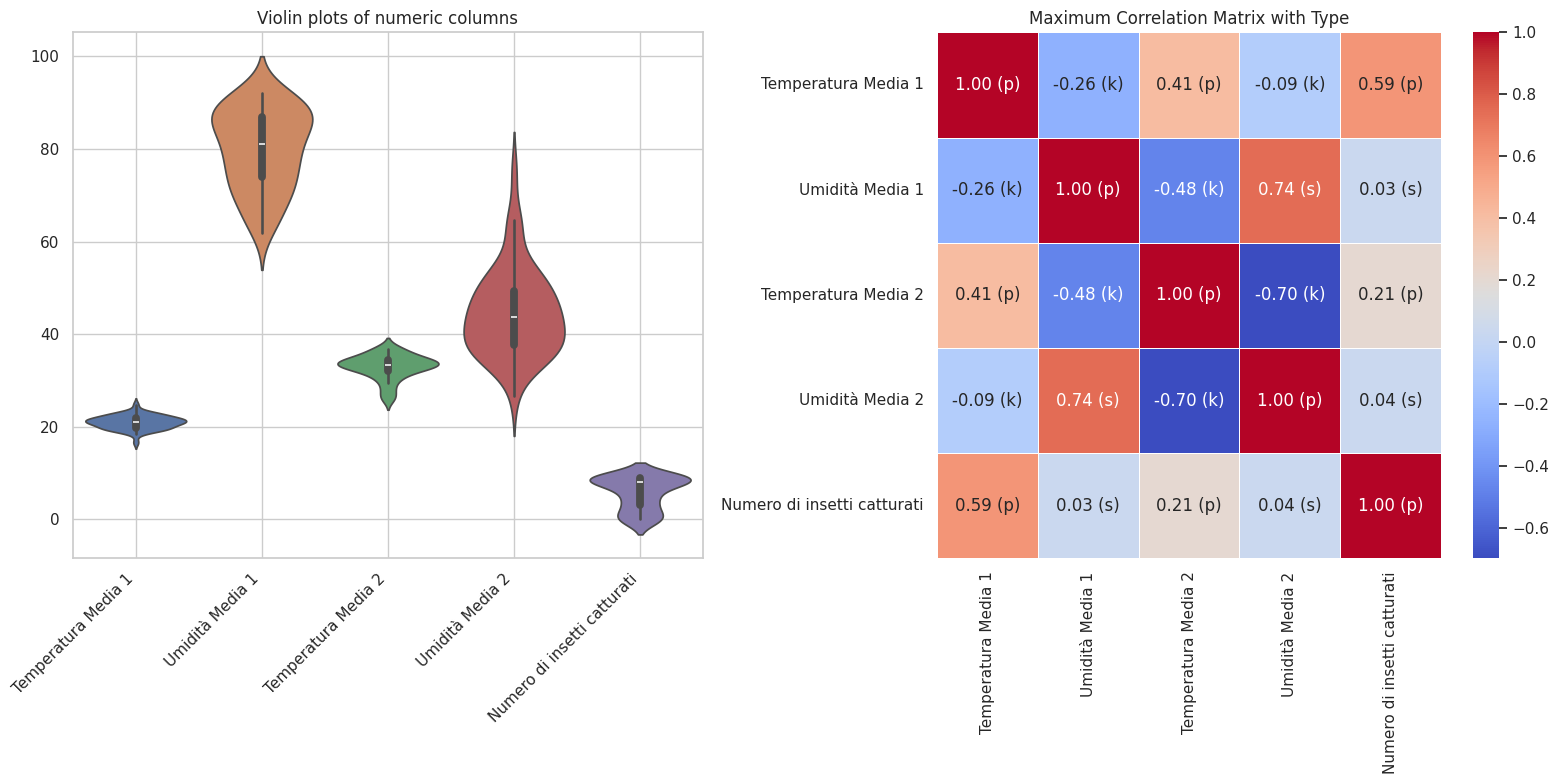




Generazione delle visualizzazioni per il file: joined_Cicalino 2.csv


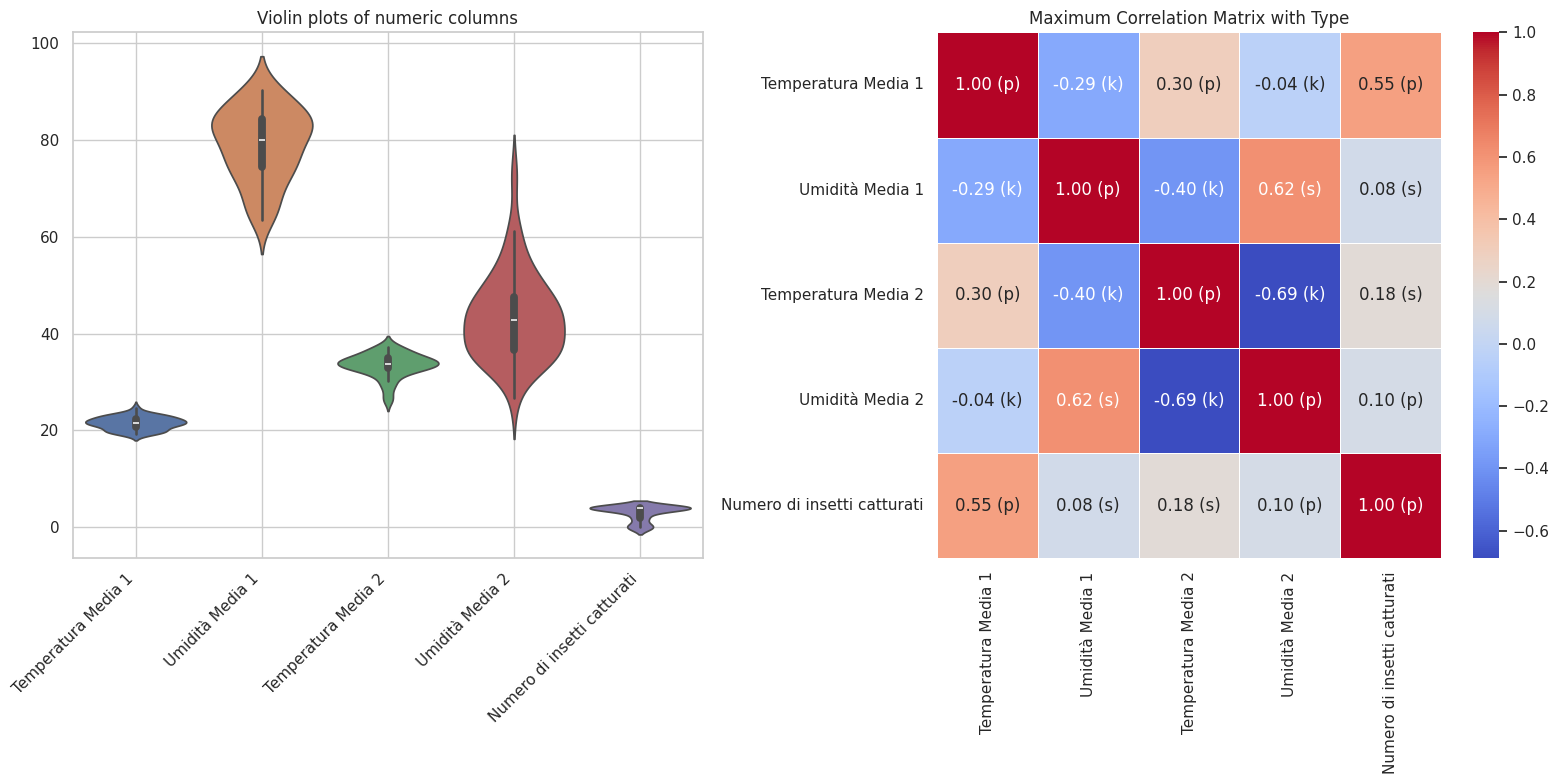




Generazione delle visualizzazioni per il file: joined_Imola 1.csv


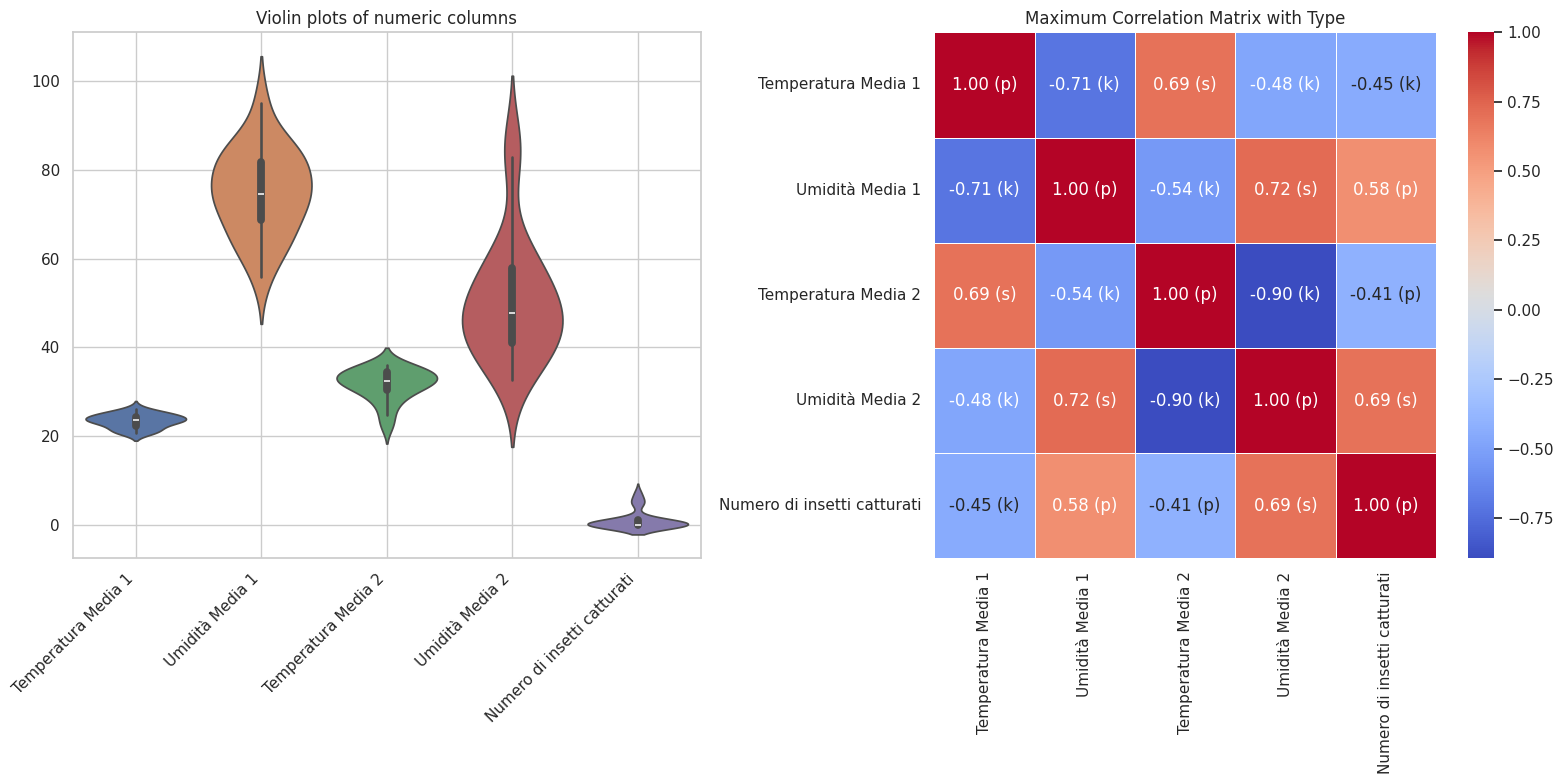




Generazione delle visualizzazioni per il file: joined_Imola 2.csv


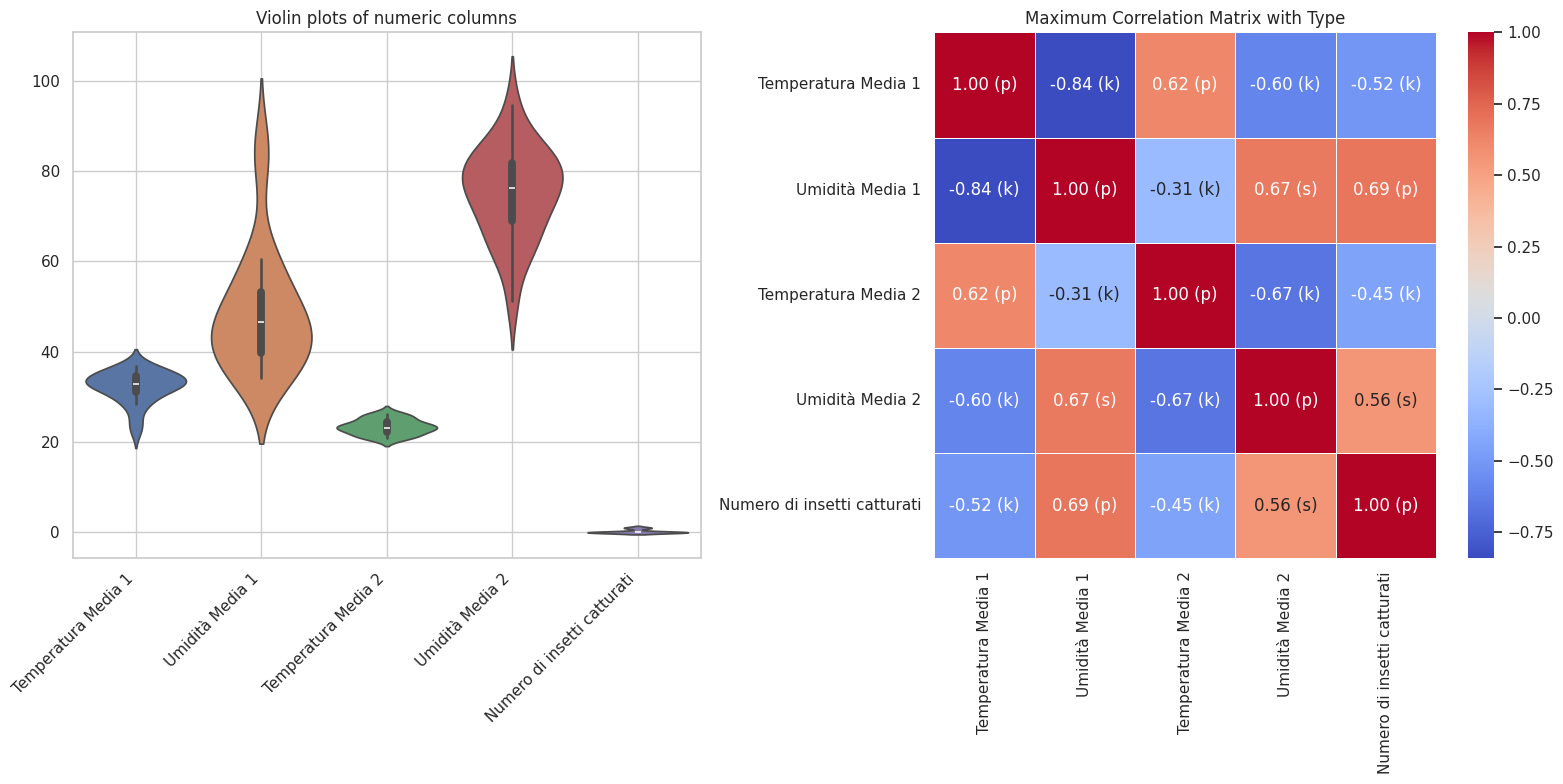




Generazione delle visualizzazioni per il file: joined_Imola 3.csv


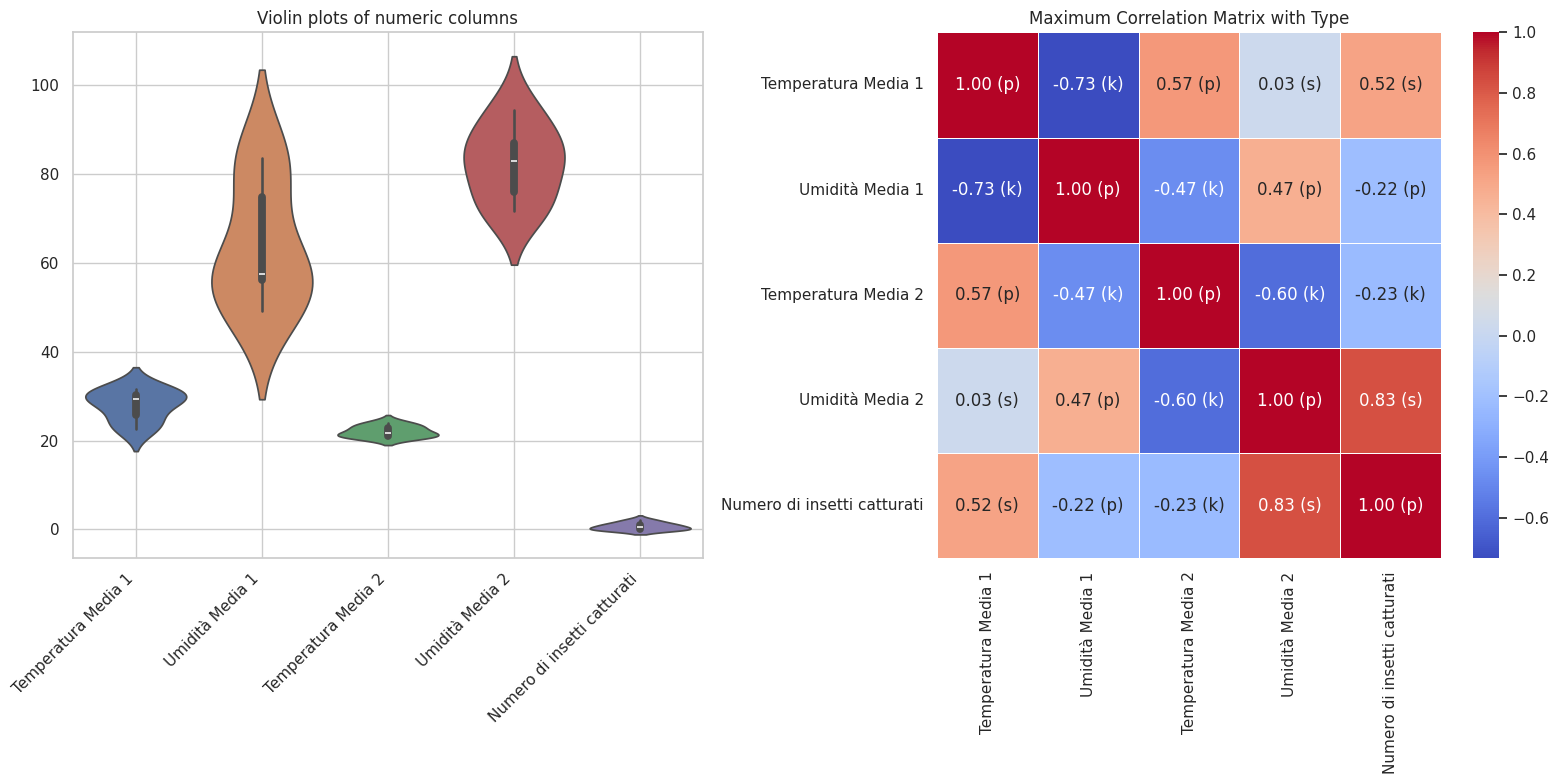

In [ ]:
#@title ## Correlation Matrix

def max_correlation_matrix_with_type(df):
    """
    Calcola la matrice di correlazione massima tra i metodi Pearson, Spearman e Kendall,
    e restituisce anche il tipo di correlazione per ogni coppia di variabili.

    Parametri:
    df (pandas.DataFrame): DataFrame contenente i dati numerici su cui calcolare la matrice di correlazione.

    Ritorno:
    max_corr (pandas.DataFrame): Matrice di correlazione con i valori massimi tra i metodi Pearson, Spearman e Kendall.
    corr_type (pandas.DataFrame): Matrice che indica quale tipo di correlazione ha prodotto il valore massimo ('p', 's', 'k').
    """
    # Calcola le correlazioni con tre metodi diversi
    pearson_corr = df.corr(method='pearson')
    spearman_corr = df.corr(method='spearman')
    kendall_corr = df.corr(method='kendall')

    # Inizializza la matrice di correlazione massima e la matrice dei tipi di correlazione
    max_corr = pearson_corr.copy()
    corr_type = pd.DataFrame(index=pearson_corr.index, columns=pearson_corr.columns)

    # Determina la correlazione massima e il relativo tipo
    for row in pearson_corr.index:
        for col in pearson_corr.columns:
            max_value = max(pearson_corr.at[row, col], spearman_corr.at[row, col], kendall_corr.at[row, col])
            max_corr.at[row, col] = max_value
            if max_value == pearson_corr.at[row, col]:
                corr_type.at[row, col] = 'p'  # Pearson
            elif max_value == spearman_corr.at[row, col]:
                corr_type.at[row, col] = 's'  # Spearman
            else:
                corr_type.at[row, col] = 'k'  # Kendall

    return max_corr, corr_type

def calculate_vif(df):
    """
    Calcola il Variance Inflation Factor (VIF) per ciascuna variabile nel DataFrame.

    Parametri:
    df (pandas.DataFrame): DataFrame contenente i dati numerici su cui calcolare il VIF.

    Ritorno:
    vif_data (pandas.DataFrame): DataFrame contenente il nome delle feature e i valori di VIF corrispondenti.
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def create_grid_visualizations(df, exclude_columns=['Cattura presente', 'Nuove catture (per evento)']):
    """
    Crea visualizzazioni a griglia con un violin plot per tutte le colonne numeriche
    e una heatmap della matrice di correlazione massima con annotazioni del tipo di correlazione.

    Parametri:
    df (pandas.DataFrame): DataFrame contenente i dati su cui creare le visualizzazioni.
    exclude_columns (list): Lista di colonne da escludere dal DataFrame prima di creare le visualizzazioni.

    Ritorno:
    None: La funzione mostra direttamente le visualizzazioni.
    """
    if exclude_columns:
        # Rimuove le colonne specificate
        df = df.drop(columns=exclude_columns, errors='ignore')

    # Seleziona solo le colonne numeriche
    numeric_df = df.select_dtypes(include=[np.number])

    # Crea i sottotitoli per le visualizzazioni
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # Solo 2 subplot invece di 4

    # Violin plot per tutte le colonne numeriche
    sns.violinplot(data=numeric_df, ax=axs[0])
    axs[0].set_title(f'Violin plots of numeric columns')
    axs[0].grid(True)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

    # Matrice di correlazione massima con annotazioni del tipo
    max_corr, corr_type = max_correlation_matrix_with_type(numeric_df)
    annot = np.array([['{:.2f} ({})'.format(max_corr.iloc[i, j], corr_type.iloc[i, j]) for j in range(len(max_corr.columns))] for i in range(len(max_corr))])
    sns.heatmap(max_corr, annot=annot, cmap='coolwarm', fmt='', linewidths=.5, ax=axs[1])
    axs[1].set_title(f'Maximum Correlation Matrix with Type')

    # Ottimizza il layout per le visualizzazioni
    plt.tight_layout()
    plt.show()

# Esegui la visualizzazione per tutti i file CSV
csv_files = [f for f in os.listdir(JOINED_DATA) if f.endswith('.csv')]
csv_files.sort()

for filename in csv_files:
    file_path = os.path.join(JOINED_DATA, filename)
    df = pd.read_csv(file_path)
    print(f"Generazione delle visualizzazioni per il file: {filename}")
    create_grid_visualizations(df)
    print("\n\n")

Escludiamo dalle successive analisi e predizioni il dataset di Imola 3 per scarsità di dati target.

Generazione delle visualizzazioni per il file: joined_Cicalino 1.csv


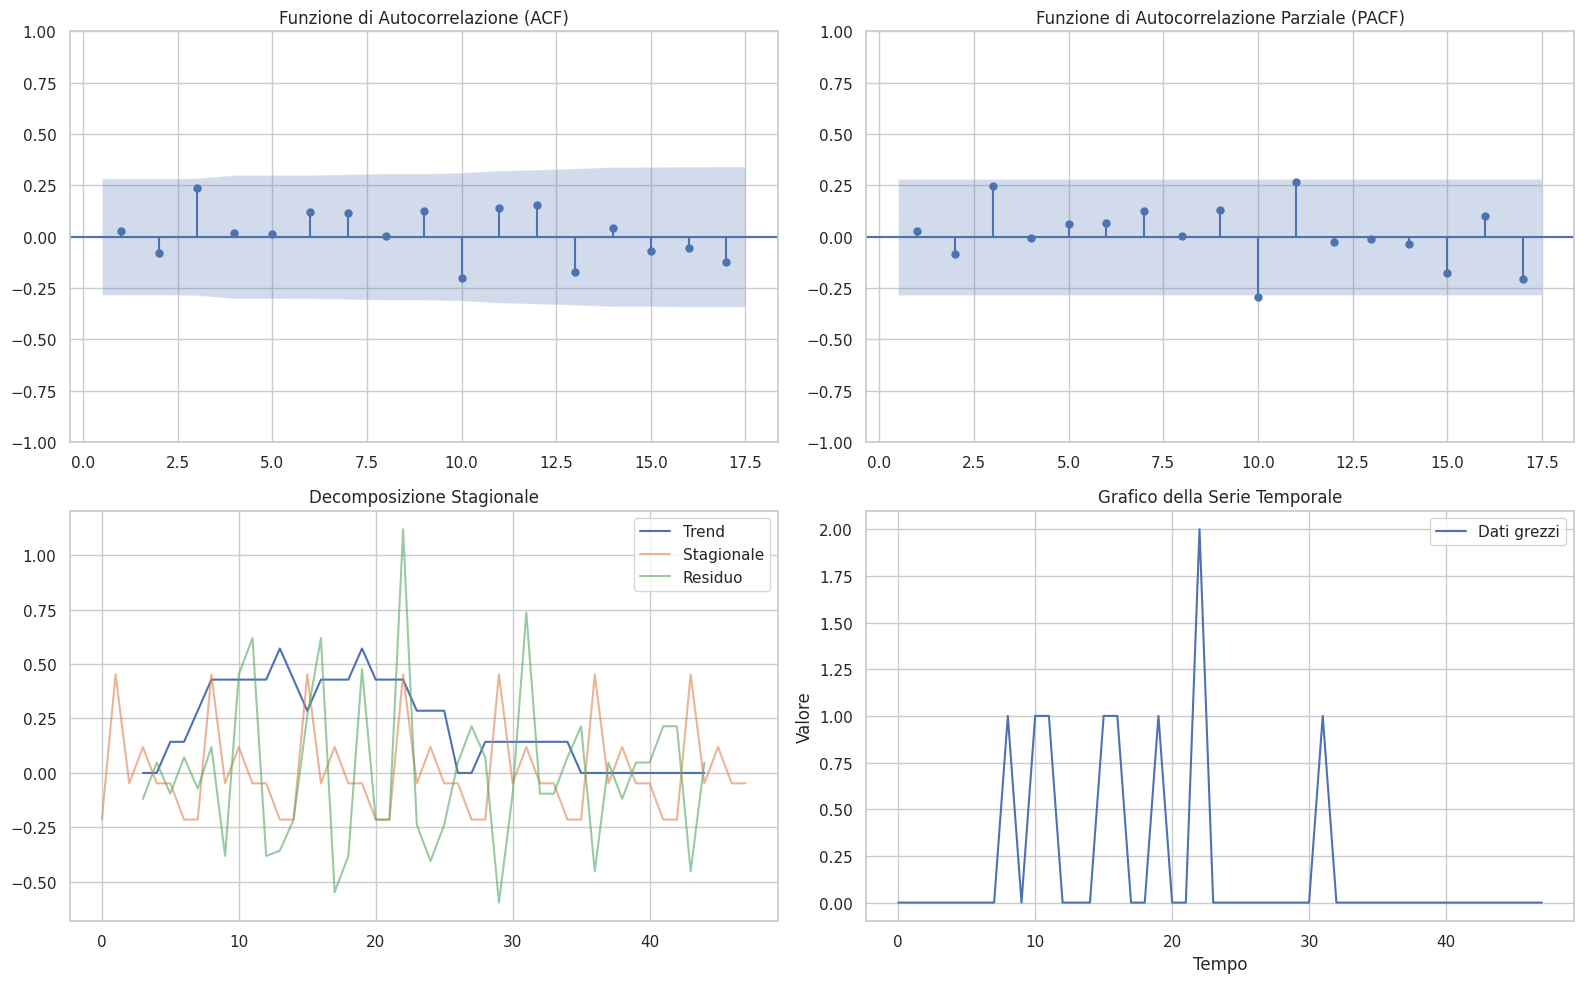

ADF Statistic: -3.0256275971555957, p-value: 0.03256943144650129



Generazione delle visualizzazioni per il file: joined_Cicalino 2.csv


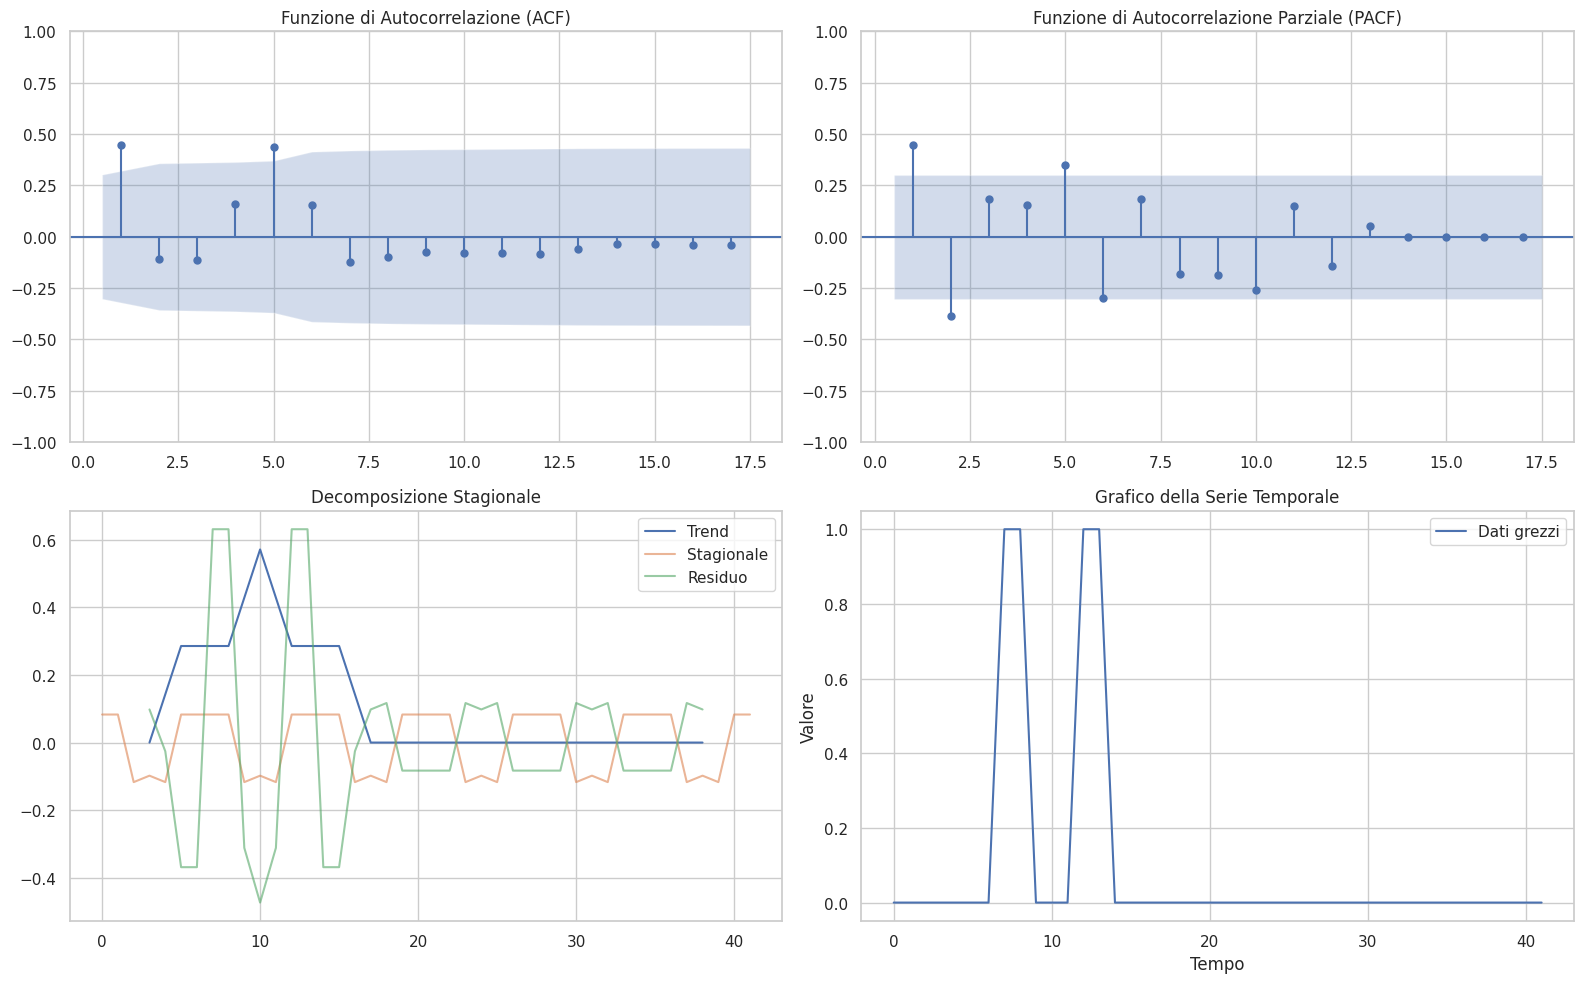

ADF Statistic: -2.78528976918539, p-value: 0.06040593685511135



Generazione delle visualizzazioni per il file: joined_Imola 1.csv


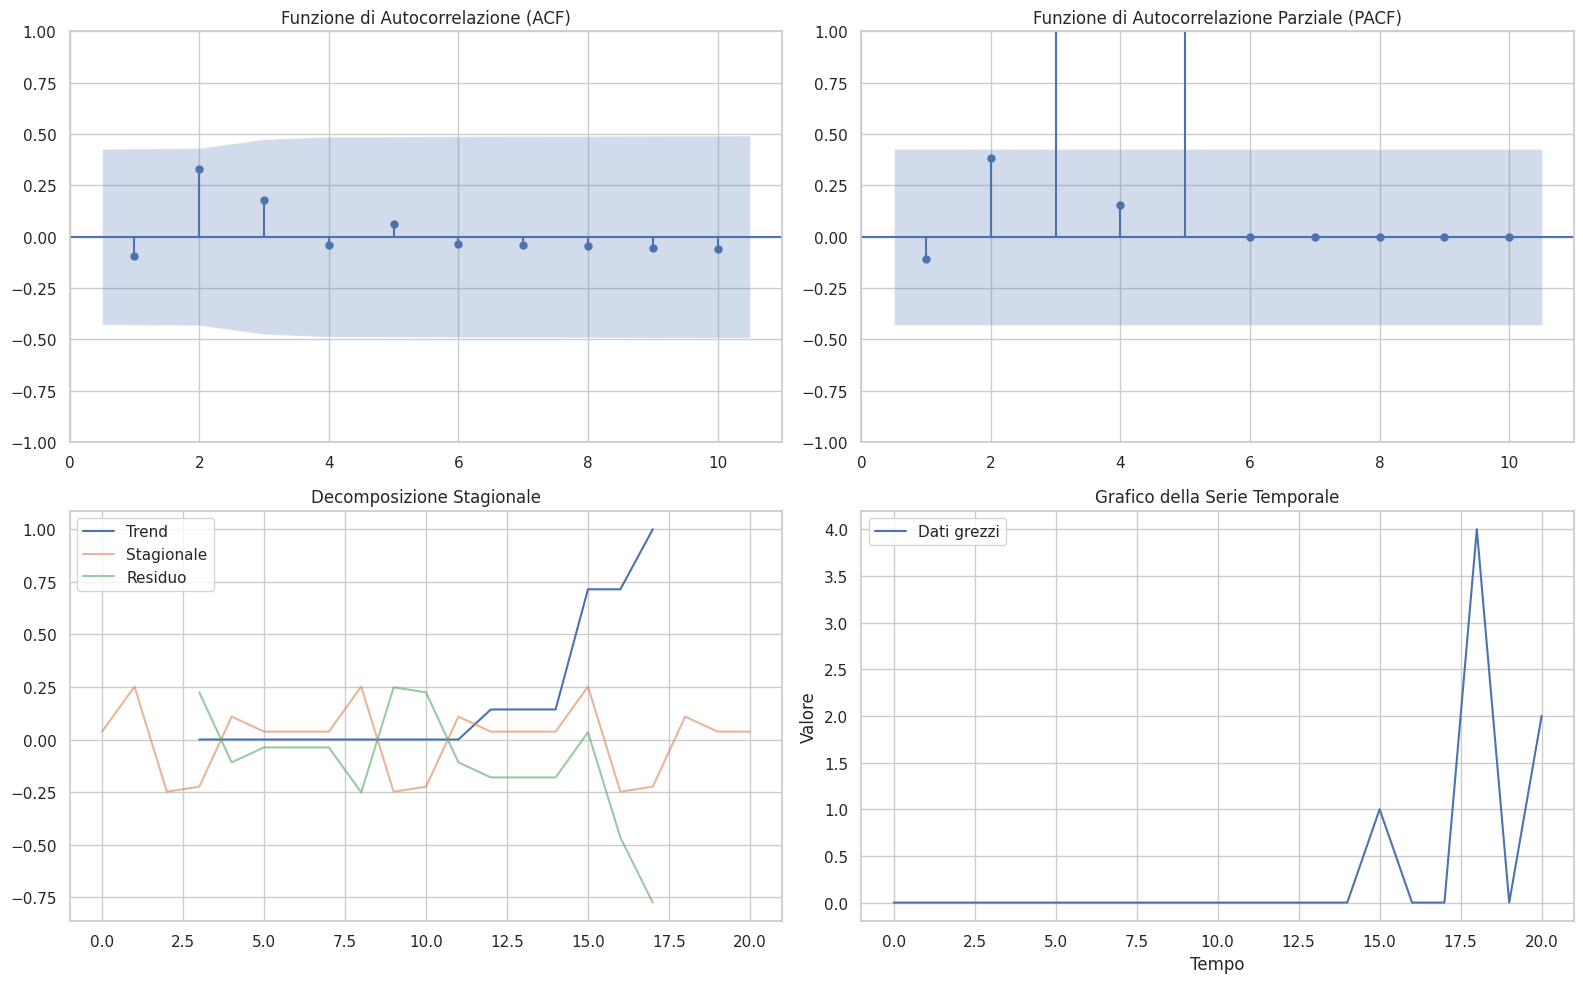

ADF Statistic: 10.166097497257233, p-value: 1.0



Generazione delle visualizzazioni per il file: joined_Imola 2.csv


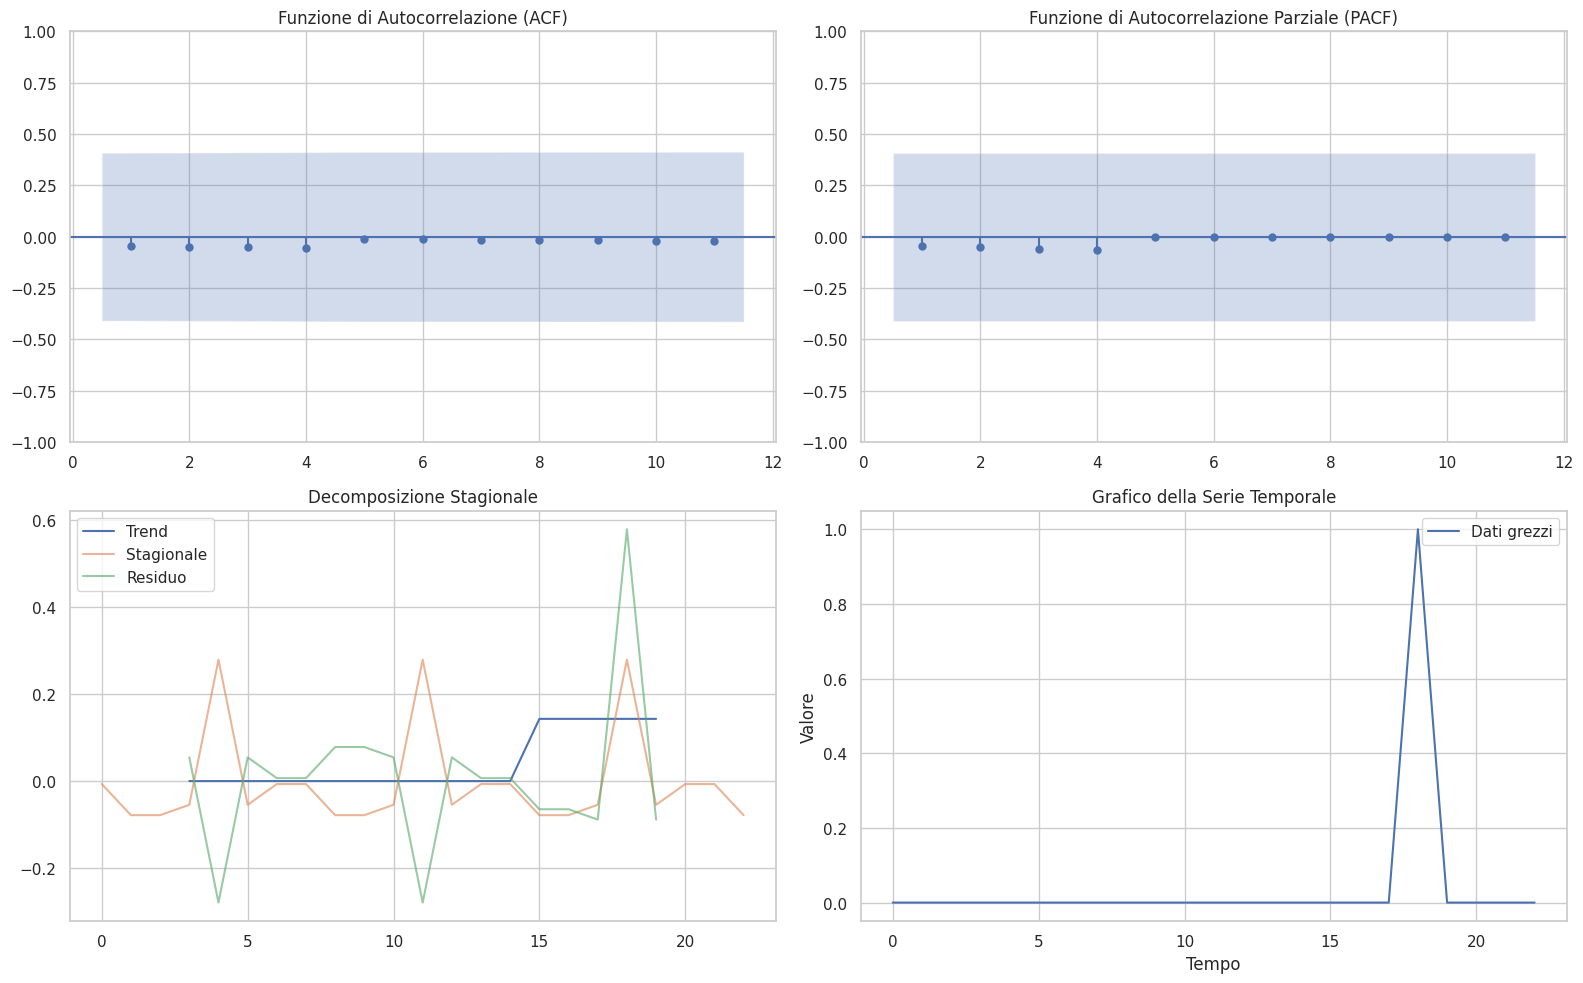

ADF Statistic: -4.69041575982343, p-value: 8.771151502171726e-05





In [ ]:
#@title ## Time Series Exploratory Data Analysis

def advanced_time_series_analysis(df, column, period=7):
    """
    Esegue un'analisi avanzata di una serie temporale, mostrando:
    - Funzione di autocorrelazione (ACF)
    - Funzione di autocorrelazione parziale (PACF)
    - Decomposizione stagionale
    - Grafico della serie temporale

    Parametri:
    df (pandas.DataFrame): DataFrame contenente la serie temporale
    column (string): Nome della colonna contenente la serie temporale da analizzare
    period (int): Periodo della stagionalità
    """
    # Assicurati che la serie temporale sia una Serie pandas e che abbia un indice datetime
    time_series = df[column]

    # Crea una figura con 2 righe e 2 colonne per i grafici
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Traccia la Funzione di Autocorrelazione (ACF)
    plot_acf(time_series, ax=axs[0, 0], zero=False)
    axs[0, 0].set_title('Funzione di Autocorrelazione (ACF)')

    # Traccia la Funzione di Autocorrelazione Parziale (PACF)
    plot_pacf(time_series, ax=axs[0, 1], zero=False, method='ols')
    axs[0, 1].set_title('Funzione di Autocorrelazione Parziale (PACF)')

    # Decomposizione Stagionale
    result = seasonal_decompose(time_series.dropna(), model='additive', period=period)
    axs[1, 0].plot(result.trend, label='Trend')
    axs[1, 0].plot(result.seasonal, label='Stagionale', alpha=0.6)
    axs[1, 0].plot(result.resid, label='Residuo', alpha=0.6)
    axs[1, 0].legend()
    axs[1, 0].set_title('Decomposizione Stagionale')

    # Grafico della serie temporale
    axs[1, 1].plot(time_series.index, time_series, label='Dati grezzi')
    axs[1, 1].set_title('Grafico della Serie Temporale')
    axs[1, 1].set_xlabel('Tempo')
    axs[1, 1].set_ylabel('Valore')
    axs[1, 1].legend()

    # Ottimizza la disposizione dei grafici e mostra la figura
    plt.tight_layout()
    plt.show()

csv_files = [f for f in os.listdir(JOINED_DATA) if f.endswith('.csv') and "Imola 3" not in f]
csv_files.sort()

for filename in csv_files:
    file_path = os.path.join(JOINED_DATA, filename)
    df = pd.read_csv(file_path)

    print(f"Generazione delle visualizzazioni per il file: {filename}")
    advanced_time_series_analysis(df, 'Nuove catture (per evento)')
    result = adfuller(df['Nuove catture (per evento)'].dropna())
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    print("\n\n")

# Statistical Learning Techniques
Sulla base degli studi condotti e delle decisioni prese durante il progetto, si è ritenuto opportuno adottare un approccio modellistico che fosse adatto a lavorare con la ridotta quantità di dati disponibili per ciascun sito di studio, trattati singolarmente. In questa prospettiva, è stata individuata una soluzione ottimale nei modelli statistici.

Dai risultati del test ADF, Imola 1 è risultano non stazionario, pertanto i dati di Imola 1 sono stati esclusi dallo studio statistico per evitare potenziali problematiche.

Tra i modelli disponibili, si è scelto di impiegare l'ARIMA, con particolare attenzione alla sua variante ARIMAX, per sfruttare le potenzialità predittive derivanti dall'integrazione di variabili ambientali.

Il modello è stato addestrato sull'80% del dataset e testato sul 20%, seguendo una pratica comune. Tuttavia, per il sito Imola 2, con un picco anomalo alla fine della serie, si è usata una suddivisione 85% training e 15% test, per evitare che l'assenza di fluttuazioni significative penalizzasse l'apprendimento del modello.

I risultati ottenuti sono stati estremamente soddisfacenti. Le previsioni del modello hanno mostrato valori di errore relativamente bassi, sia in termini di RMSE (Root Mean Square Error) che di MAE (Mean Absolute Error). Inoltre, i valori previsti rientrano negli intervalli di confidenza calcolati, confermando l'affidabilità del modello.

In [ ]:
#@title ## Definition
def arimax_model_prediction(csv_file, arima_order, train_ratio=0.8):
    """
    Funzione per costruire un modello ARIMAX, addestrarlo, effettuare previsioni e calcolare le metriche.

    Parametri:
    - csv_file (str): percorso del file CSV contenente i dati.
    - arima_order (tuple): ordini dell'ARIMA (p, d, q).
    - train_ratio (float): frazione di dati da usare per l'addestramento (default 0.8).

    Returns:
    - tuple: (RMSE e MAE di addestramento, RMSE e MAE di test)
    """

    # Carica i dati dal CSV
    df = pd.read_csv(csv_file)

    # Separazione delle variabili dipendenti e indipendenti
    y = df['Nuove catture (per evento)']
    X = df[['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']]

    # Suddivisione dei dati in training e test (80% addestramento - 20% test)
    train_size = int(len(df) * train_ratio)
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

    # Definisce e addestra il modello ARIMAX sui dati di addestramento
    arimax_model = sm.tsa.ARIMA(endog=y_train, exog=X_train, order=arima_order).fit()

    # Previsioni sui dati di addestramento
    fitted_values_train = arimax_model.fittedvalues.clip(lower=0).round()

    # Previsioni sui dati di test
    arimax_forecast = arimax_model.get_forecast(steps=len(y_test), exog=X_test)
    forecasted_values_test = arimax_forecast.predicted_mean.clip(lower=0).round()
    confidence_intervals_test = arimax_forecast.conf_int()
    confidence_intervals_test[confidence_intervals_test < 0] = 0  # Garantisce intervalli non negativi
    confidence_intervals_test = confidence_intervals_test.round()

    # Calcola i residui
    residuals_train_arimax = y_train - fitted_values_train
    residuals_test_arimax = y_test - forecasted_values_test

    # Calcola le metriche
    # Metriche di addestramento
    rmse_train = np.sqrt(mean_squared_error(y_train, fitted_values_train))
    mae_train = mean_absolute_error(y_train, fitted_values_train)

    # Metriche di test
    rmse_test = np.sqrt(mean_squared_error(y_test, forecasted_values_test))
    mae_test = mean_absolute_error(y_test, forecasted_values_test)

    # Plot dei risultati
    fig, ax = plt.subplots(figsize=(12, 6))

    # Grafico dei valori reali, adattati e previsti
    ax.plot(y.index, y, label='Reale', color='blue')
    ax.plot(fitted_values_train.index, fitted_values_train, color='red', linestyle='--', label='Adattato (Training)')
    ax.plot(forecasted_values_test.index, forecasted_values_test, label='Previsione (Test)', color='green')
    ax.fill_between(confidence_intervals_test.index, confidence_intervals_test.iloc[:, 0], confidence_intervals_test.iloc[:, 1], color='green', alpha=0.2)

    # Titolo e legenda
    ax.set_title(f'Modello ARIMAX: Addestramento e Previsione\nRMSE Training: {rmse_train:.2f}, MAE: {mae_train:.2f} | RMSE Test: {rmse_test:.2f}, MAE: {mae_test:.2f}')
    ax.legend()

    plt.show()

    return rmse_train, mae_train, rmse_test, mae_test

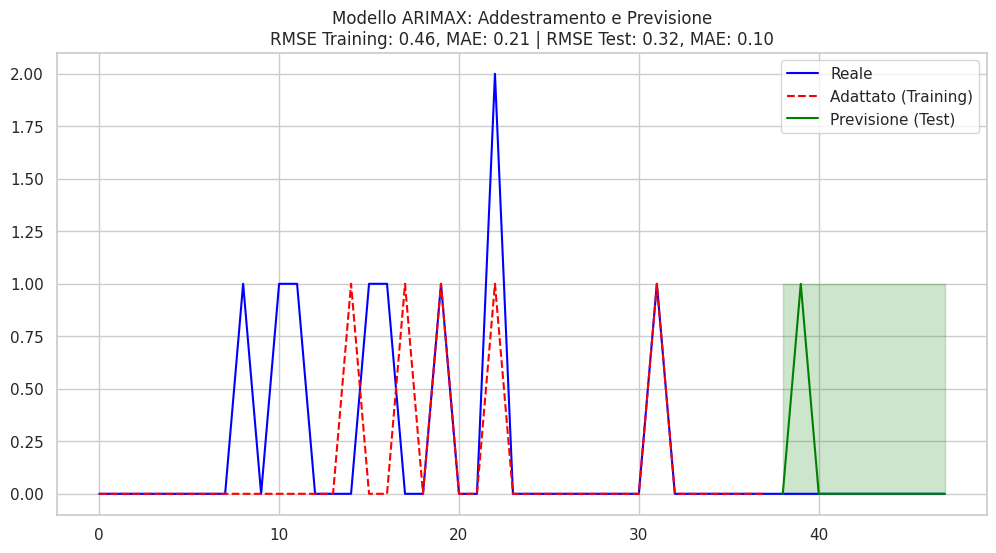

In [ ]:
#@title ARIMAX - Cicalino 1

rmse_train, mae_train, rmse_test, mae_test = arimax_model_prediction(
    csv_file=JOINED_DATA + "/joined_Cicalino 1.csv",
    arima_order=(10, 0, 11),
    train_ratio=0.8
)

rmse_ARMAX_trainC1 = rmse_train
mae_ARMAX_trainC1 = mae_train
rmse_ARMAX_testC1 = rmse_test
mae_ARMAX_testC1 = mae_test

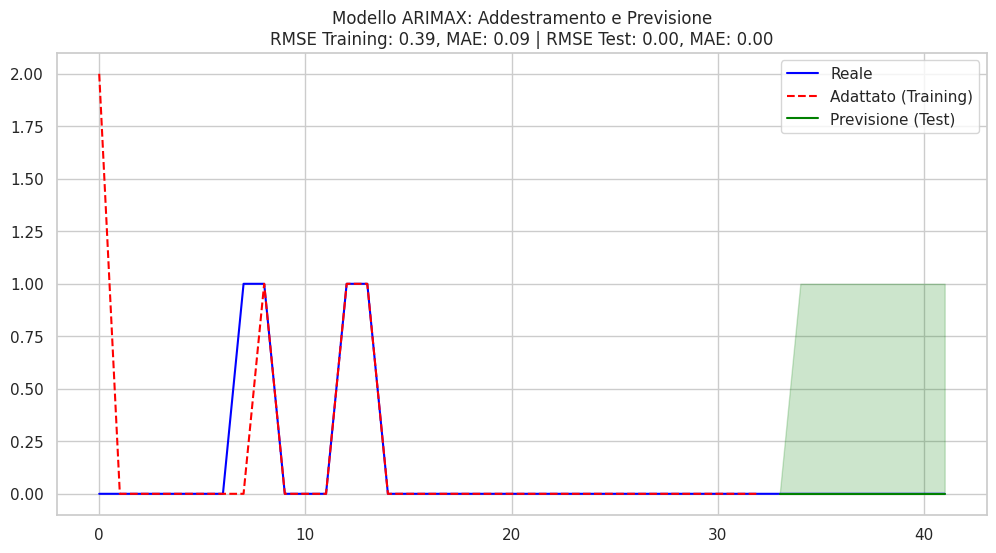

In [ ]:
#@title ARIMAX - Cicalino 2

rmse_train, mae_train, rmse_test, mae_test = arimax_model_prediction(
    csv_file=JOINED_DATA + "/joined_Cicalino 2.csv",
    arima_order=(4, 1, 5),
    train_ratio=0.8
)

rmse_ARMAX_trainC2 = rmse_train
mae_ARMAX_trainC2 = mae_train
rmse_ARMAX_testC2 = rmse_test
mae_ARMAX_testC2 = mae_test

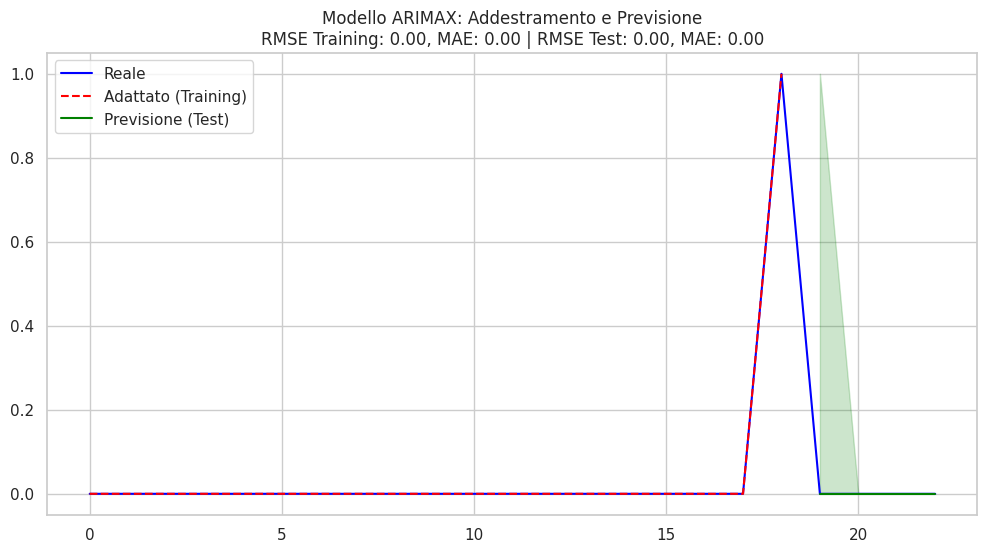

In [ ]:
#@title ARIMAX - Imola 2

rmse_train, mae_train, rmse_test, mae_test = arimax_model_prediction(
    csv_file=JOINED_DATA + "/joined_Imola 2.csv",
    arima_order=(10, 0, 11),
    train_ratio=0.85
)

rmse_ARMAX_trainI2 = rmse_train
mae_ARMAX_trainI2 = mae_train
rmse_ARMAX_testI2 = rmse_test
mae_ARMAX_testI2 = mae_test

# Machine Learning Techniques
Per ampliare lo studio, si è deciso di adottare un approccio basato sul machine learning, con l’obiettivo di analizzare anche i dati provenienti da siti le cui serie storiche non risultavano stazionarie. Questo ci consente di apprendere la complessità dei pattern presenti nei dati senza richiedere trasformazioni per la stazionarietà, sfruttando la capacità dei modelli di machine learning di catturare relazioni non lineari e interazioni tra variabili. Un ulteriore vantaggio di questa metodologia è la possibilità di analizzare l'importanza delle feature in un contesto multivariato. Attraverso tecniche di interpretazione dei modelli, si è cercato di identificare quali variabili ambientali (temperature, umidità, ecc.) abbiano avuto un impatto significativo sul forecasting delle catture di insetti.

## Decision Tree
I Decision Tree sono modelli predittivi che dividono iterativamente i dati in base a regole decisionali, fino a raggiungere foglie che rappresentano la previsione finale. I Decision Tree Regressor, in particolare, sono usati per problemi di regressione, dove le foglie contengono valori medi o somme ponderate dei dati. Questo modello è facilmente interpretabile, poiché permette di visualizzare il processo decisionale e le variabili più influenti.

Per migliorare la predizione, sono state create feature lagged, che rappresentano i valori passati delle variabili, considerando l'autocorrelazione e i pattern temporali nei dati. Questo approccio è particolarmente utile per i problemi di serie temporali.

Ogni albero decisionale è stato visualizzato per analizzare la struttura e comprendere le regole apprese. I risultati del Decision Tree Regressor sono stati soddisfacenti, con un miglioramento delle metriche di errore sul dataset di training. L'analisi dell'albero ha evidenziato che le feature più influenti sono state l’Umidità Media 1 per le ore diurne e la Temperature Media 2 per le ore notturne.

In [ ]:
#@title ###Definition

def create_lagged_features(df, target_col, n_lags, exog_cols=None):
    """
    Crea feature lag per il target e include variabili esogene come sono.

    Args:
        df (pd.DataFrame): Il dataframe di input.
        target_col (str): Nome della colonna target.
        n_lags (int): Numero di lag da creare per il target.
        exog_cols (list): Lista di colonne esogene da includere (default None).

    Returns:
        pd.DataFrame: DataFrame con lag e variabili esogene incluse.
    """
    # Creare le lag del target
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Eliminare righe con valori NaN generati dalle lag
    df.dropna(inplace=True)

    # Se esistono variabili esogene, aggiungile
    if exog_cols:
        feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    else:
        feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)]

    return df, feature_cols

def decision_tree_time_series(df, target_col, n_lags=3, exog_cols=None, test_size=0.2, max_depth=None, random_state=42):
    """
    Applica un Decision Tree per il forecasting di una serie storica con variabili esogene opzionali.
    Visualizza un grafico della regressione (Actual, Fitted, Forecast) e l'albero decisionale fianco a fianco.

    Args:
        df (pd.DataFrame): Il dataset con dati temporali.
        target_col (str): Nome della colonna target da prevedere.
        n_lags (int): Numero di lag da creare per il target.
        exog_cols (list): Colonne esogene da considerare (default None).
        test_size (float): Percentuale di dati per il test set (default 0.2).
        max_depth (int): Profondità massima dell'albero (default None).
        random_state (int): Seme per la riproducibilità (default 42).

    Returns:
        model (DecisionTreeRegressor): Il modello addestrato.
        df (pd.DataFrame): DataFrame con lag e previsioni.
    """
    # Creare le feature lag e ottenere le feature selezionate
    df, feature_cols = create_lagged_features(df, target_col, n_lags, exog_cols)

    # Separare X e y
    X = df[feature_cols]
    y = df[target_col]

    # Split cronologico dei dati
    train_size = int(len(df) * (1 - test_size))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Standardizzazione dei dati
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Creazione del modello Decision Tree
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    model.fit(X_train_scaled, y_train)

    # Previsioni
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calcolo delle metriche
    metrics = {
        "RMSE Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "RMSE Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "MAE Train": mean_absolute_error(y_train, y_train_pred),
        "MAE Test": mean_absolute_error(y_test, y_test_pred)
    }

    # Creazione di una figura con due subplot
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))


    # Subplot 1: Albero decisionale
    plot_tree(model, feature_names=feature_cols, filled=True, rounded=True, ax=axs[1])

    # Subplot 2: Regressione (Actual, Fitted, Forecast)
    axs[0].plot(y.index, y, label='Actual', color='blue', marker='o', linestyle='-', alpha=0.6)
    axs[0].plot(y_train.index, y_train_pred, label='Fitted (Train)', color='green', marker='x', linestyle='--', alpha=0.8)
    axs[0].plot(y_test.index, y_test_pred, label='Forecast (Test)', color='red', marker='s', linestyle='-.', alpha=0.8)
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel(target_col)
    axs[0].set_title(f'Decision Tree: Training and Forecasting\nTraining RMSE: {metrics["RMSE Train"]:.2f}, MAE: {metrics["MAE Train"]:.2f} | Test RMSE: {metrics["RMSE Test"]:.2f}, MAE: {metrics["MAE Test"]:.2f}')
    axs[0].legend()
    axs[0].grid(True)

    # Mostrare la figura
    plt.tight_layout()
    plt.show()

    return model, metrics

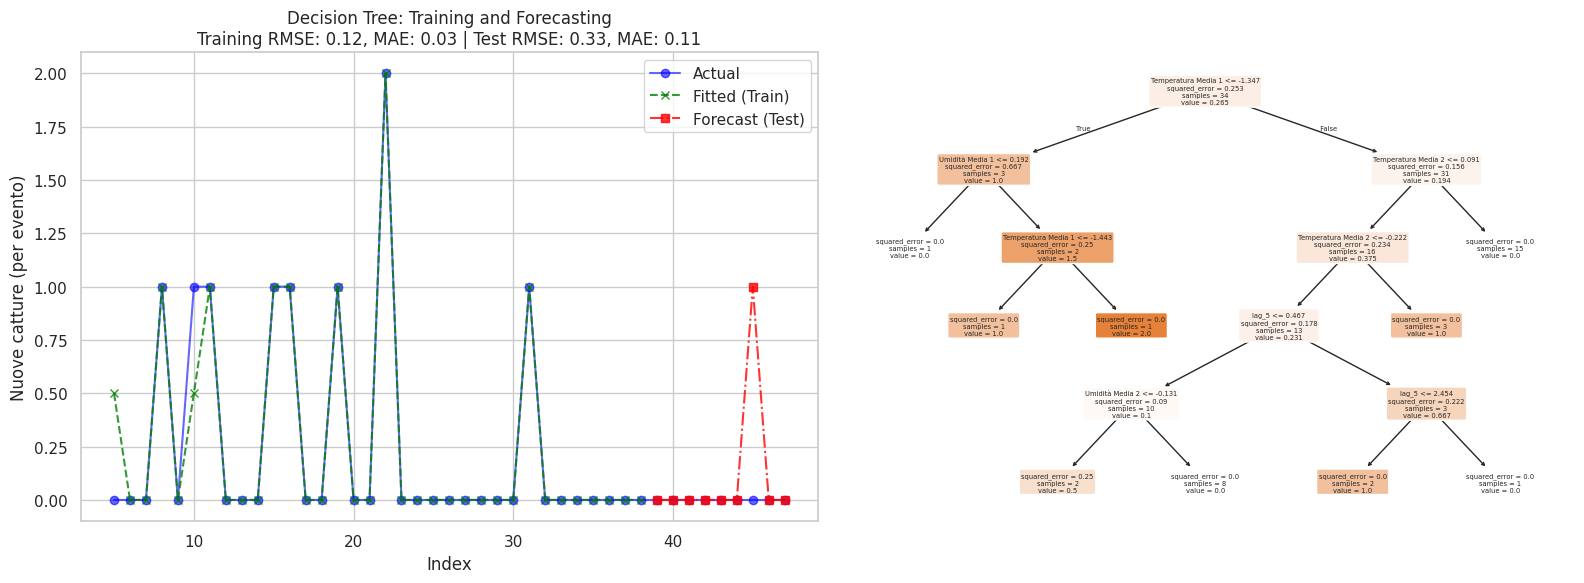

In [ ]:
#@title Forecasting - Cicalino 1

df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

model, metrics = decision_tree_time_series(df, target_col="Nuove catture (per evento)", n_lags=5, exog_cols=exog_cols, test_size=0.2, max_depth=5)

rmse_DT_trainC1 = metrics["RMSE Train"]
mae_DT_trainC1 = metrics["MAE Train"]
rmse_DT_testC1 = metrics["RMSE Test"]
mae_DT_testC1 = metrics["MAE Test"]

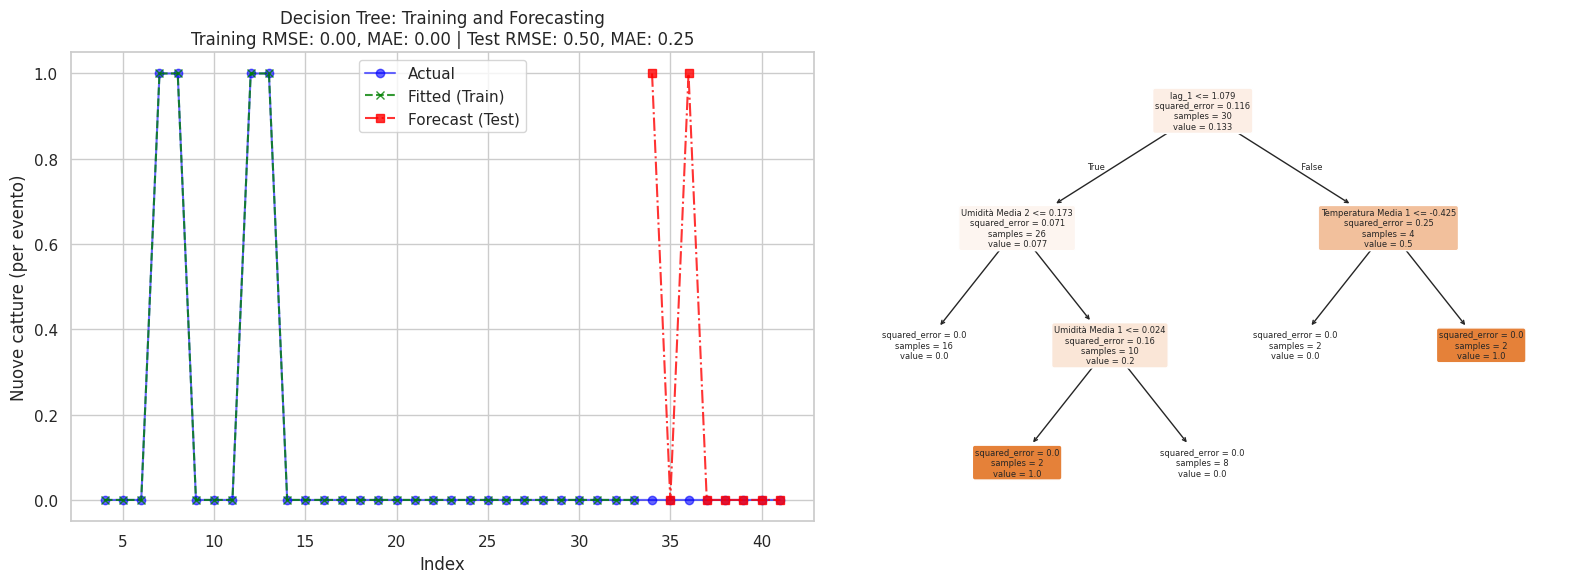

In [ ]:
#@title Forecasting - Cicalino 2

df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

model, metrics = decision_tree_time_series(df, target_col="Nuove catture (per evento)", n_lags=4, exog_cols=exog_cols, test_size=0.2, max_depth=5)

rmse_DT_trainC2 = metrics["RMSE Train"]
mae_DT_trainC2 = metrics["MAE Train"]
rmse_DT_testC2 = metrics["RMSE Test"]
mae_DT_testC2 = metrics["MAE Test"]

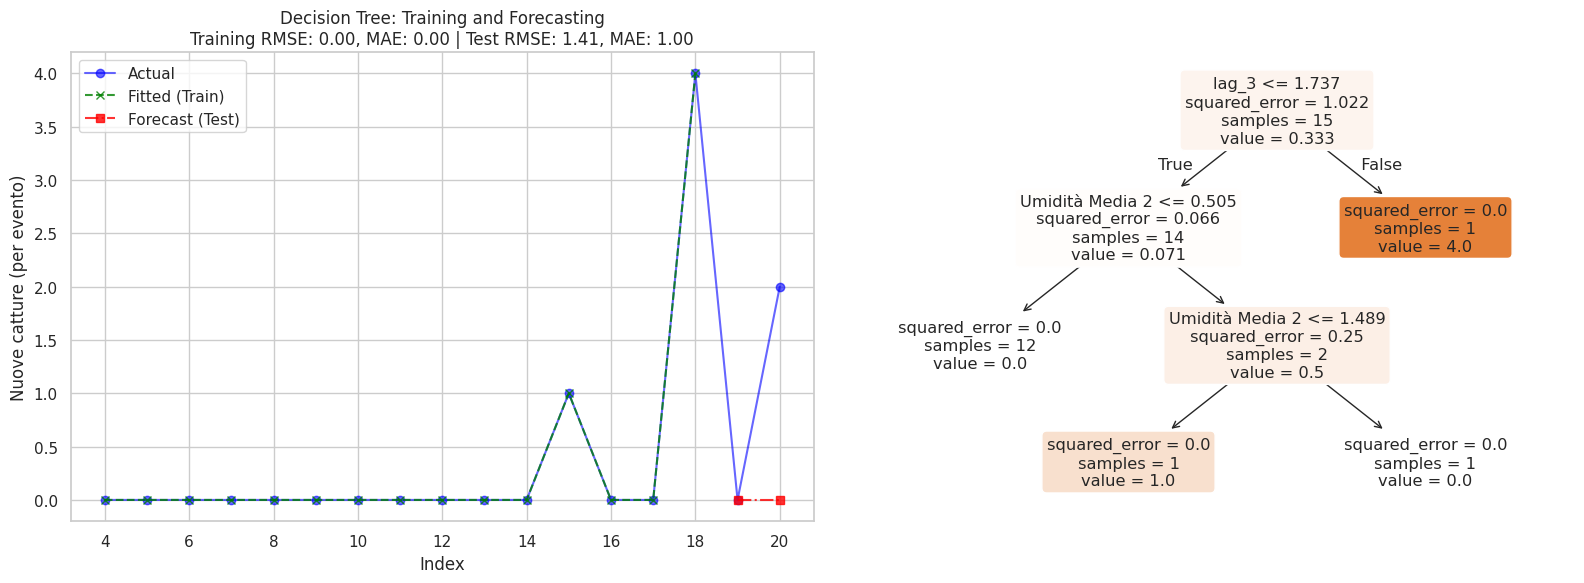

In [ ]:
#@title Forecasting - Imola 1

df = pd.read_csv(JOINED_DATA + "/joined_Imola 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

model, metrics = decision_tree_time_series(df, target_col="Nuove catture (per evento)", n_lags=4, exog_cols=exog_cols, test_size=0.1, max_depth=5)

rmse_DT_trainI1 = metrics["RMSE Train"]
mae_DT_trainI1 = metrics["MAE Train"]
rmse_DT_testI1 = metrics["RMSE Test"]
mae_DT_testI1 = metrics["MAE Test"]

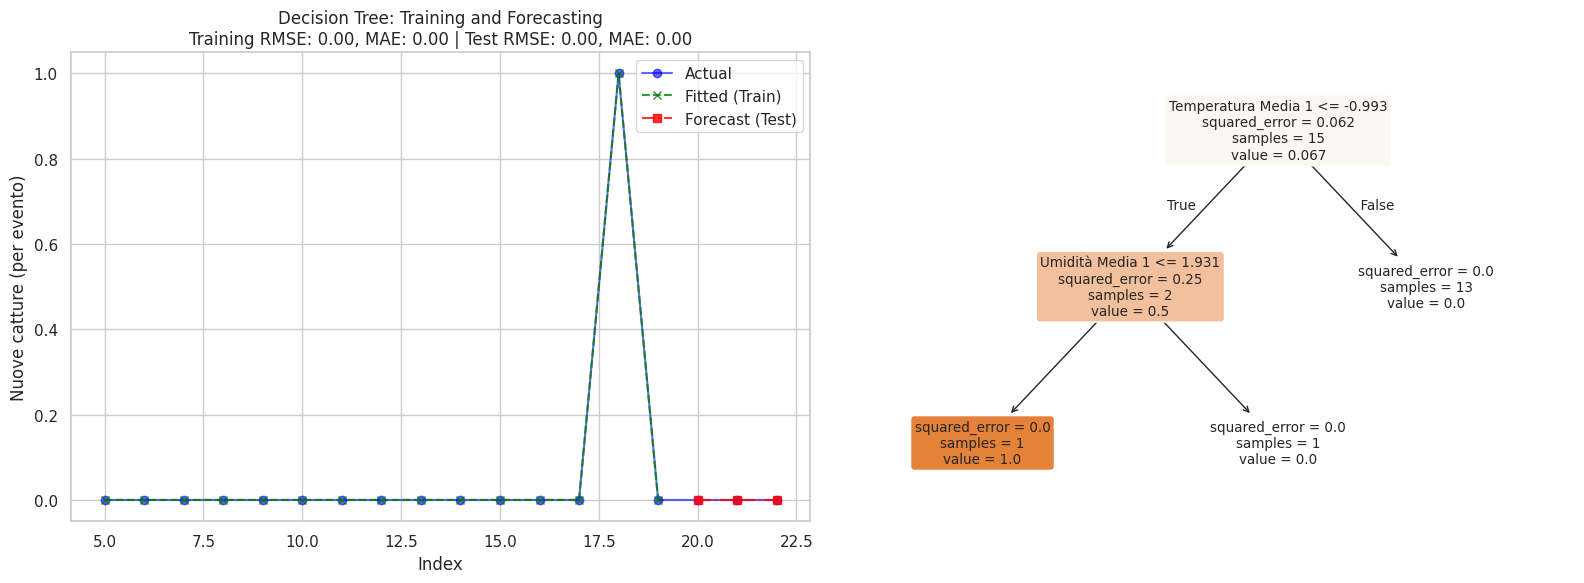

In [ ]:
#@title Forecasting - Imola 2

df = pd.read_csv(JOINED_DATA + "/joined_Imola 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

model, metrics = decision_tree_time_series(df, target_col="Nuove catture (per evento)", n_lags=5, exog_cols=exog_cols, test_size=0.15, max_depth=5)

rmse_DT_trainI2 = metrics["RMSE Train"]
mae_DT_trainI2 = metrics["MAE Train"]
rmse_DT_testI2 = metrics["RMSE Test"]
mae_DT_testI2 = metrics["MAE Test"]

## Ensemble Learning
Le metodologie di ensemble learning combinano più modelli base per migliorare le performance predittive.
Gli esperimenti hanno confermato le caratteristiche tipiche di questi approcci:
- Con il Gradient Boosting, i risultati sul training sono eccellenti, con metriche di errore molto basse, grazie alla capacità del boosting di ridurre gli errori iterativamente. Tuttavia, in fase di test, le prestazioni non sono altrettanto soddisfacenti, evidenziando una certa difficoltà del modello nel generalizzare.
- Con il Random Forest, invece, si è osservato un compromesso: i risultati sul training non sono perfetti, in quanto il bagging sacrifica un fit ottimale per favorire la robustezza. Tuttavia, le prestazioni sul test sono migliorate, grazie alla capacità del modello di evitare l’overfitting e di generalizzare meglio su dati non visti.


In [ ]:
#@title Definition
def create_lagged_features(df, n_lags, target_col, exog_cols):
    """
    Crea le caratteristiche laggate per la colonna target e utilizza le colonne esogene così come sono.

    Parametri:
    - df (DataFrame): Il DataFrame contenente i dati originali.
    - n_lags (int): Il numero di lag da creare (ad esempio, 3 per creare 3 colonne laggate).
    - target_col (str): Il nome della colonna target per la quale creare le caratteristiche laggate.
    - exog_cols (list): Una lista di colonne esogene da mantenere così come sono (attualmente non usata nel corpo della funzione, ma inclusa per futura espansione).

    Restituisce:
    - df (DataFrame): Il DataFrame con le caratteristiche laggate aggiunte e le righe con valori NaN eliminati.
    """
    # Crea le caratteristiche laggate per la colonna target
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df[target_col].shift(i)

    # Rimuove le righe con valori NaN
    df.dropna(inplace=True)

    return df

def GBMRF_train_and_visualize(df, n_lags, exog_cols, target_col, test_size=0.2):
    """
    Allena i modelli Gradient Boosting e Random Forest, e visualizza i risultati.

    Parametri:
    - df (DataFrame): Il DataFrame contenente i dati.
    - n_lags (int): Il numero di lag da creare per la colonna target.
    - exog_cols (list): Lista delle colonne esogene da utilizzare senza lag.
    - target_col (str): Il nome della colonna target da prevedere.
    - test_size (float): La frazione di dati da usare per il test (default 0.2, cioè 20%).

    Restituisce:
    - models (dict): Il dizionario dei modelli allenati.
    - rmse_train (list): Lista dei valori RMSE per il training.
    - mae_train (list): Lista dei valori MAE per il training.
    - rmse_test (list): Lista dei valori RMSE per il test.
    - mae_test (list): Lista dei valori MAE per il test.
    """
    df = create_lagged_features(df, n_lags=n_lags, target_col=target_col, exog_cols=exog_cols)

    # Seleziona le colonne delle caratteristiche: lagged per la target e esogene senza modifiche
    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = df[feature_cols]
    y = df[target_col]

    # Split cronologico dei dati
    train_size = int(len(df) * (1-test_size))
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    # Standardizzazione dei dati
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Gradient Boosting Machine": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
        "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3)
    }

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    rmse_train, mae_train, rmse_test, mae_test = [], [], [], []

    # Allenamento e previsione per ogni modello
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Applica clipping e arrotonda le previsioni
        y_pred_train = np.clip(y_pred_train, 0, None).round()
        y_pred_test = np.clip(y_pred_test, 0, None).round()

        # Calcola le metriche di errore (RMSE e MAE)
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
        mae_train.append(mean_absolute_error(y_train, y_pred_train))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))

        # Plot per Training e Test
        axs[i].plot(y_train.index, y_train, label='Actual', marker='o', color='blue', alpha=0.6)
        axs[i].plot(y_train.index, y_pred_train, label='Fitted (Train)', linestyle='--', marker='x', color='green', alpha=0.8)
        axs[i].plot(y_test.index, y_test, label='Actual (Test)', marker='o', color='blue', alpha=0.6)
        axs[i].plot(y_test.index, y_pred_test, label='Forecast (Test)', linestyle='--', marker='s', color='red', alpha=0.8)

        axs[i].set_title(f'{name}\nTrain RMSE: {rmse_train[i]:.2f}, MAE: {mae_train[i]:.2f} | Test RMSE: {rmse_test[i]:.2f}, MAE: {mae_test[i]:.2f}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Number of Adult Males')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()
    return models, rmse_train, mae_train, rmse_test, mae_test

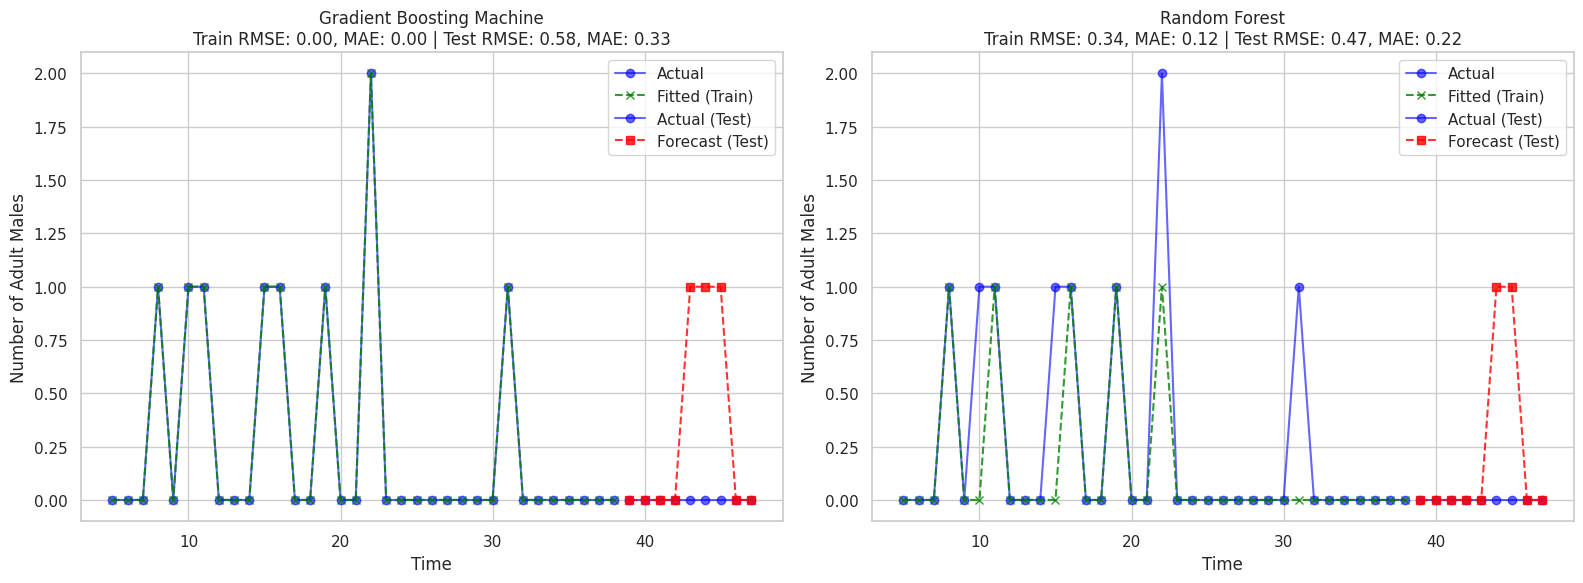

In [ ]:
# @title Forecasting Cicalino 1
df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

models, rmse_train, mae_train, rmse_test, mae_test = GBMRF_train_and_visualize(df, n_lags=5, exog_cols=exog_cols, target_col ='Nuove catture (per evento)')

rmse_GBM_trainC1 = rmse_train[0]
mae_GBM_trainC1 = mae_train[0]
rmse_GBM_testC1 = rmse_test[0]
mae_GBM_testC1 = mae_test[0]
rmse_RF_trainC1 = rmse_train[1]
mae_RF_trainC1 = mae_train[1]
rmse_RF_testC1 = rmse_test[1]
mae_RF_testC1 = mae_test[1]

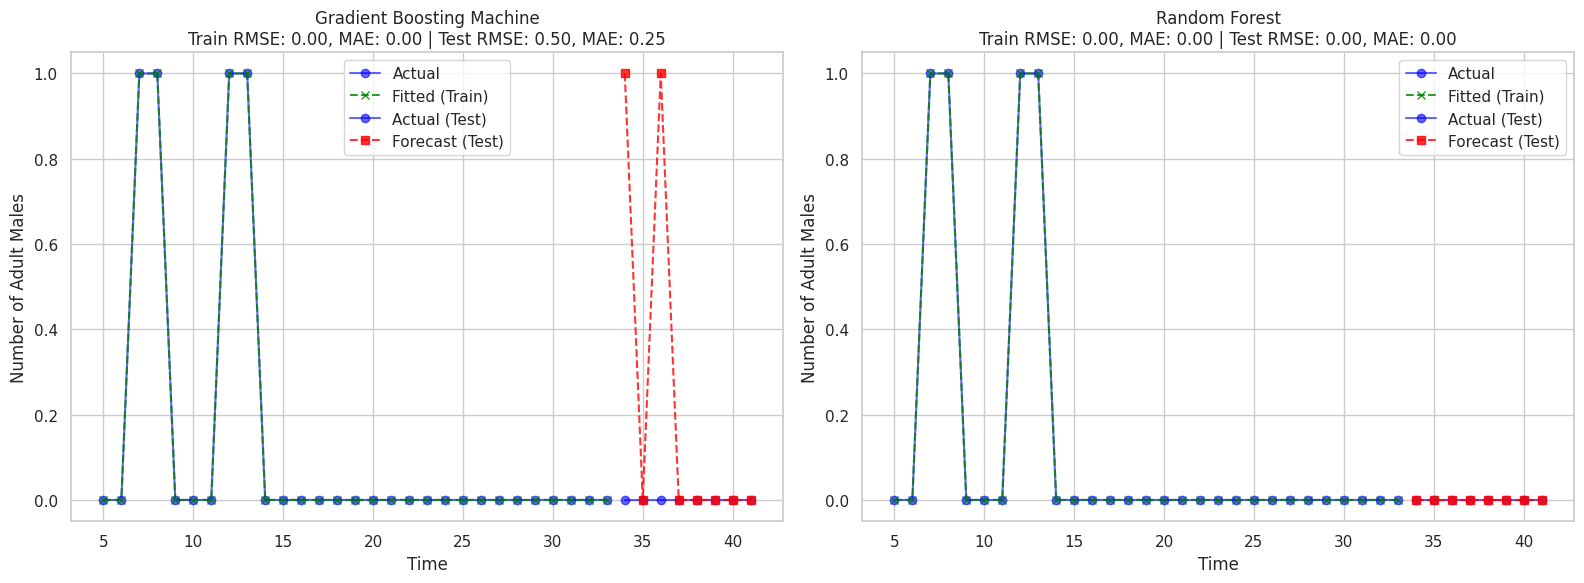

In [ ]:
# @title Forecasting Cicalino 2
df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

models, rmse_train, mae_train, rmse_test, mae_test = GBMRF_train_and_visualize(df, n_lags=5, exog_cols=exog_cols, target_col ='Nuove catture (per evento)')

rmse_GBM_trainC2 = rmse_train[0]
mae_GBM_trainC2 = mae_train[0]
rmse_GBM_testC2 = rmse_test[0]
mae_GBM_testC2 = mae_test[0]
rmse_RF_trainC2 = rmse_train[1]
mae_RF_trainC2 = mae_train[1]
rmse_RF_testC2 = rmse_test[1]
mae_RF_testC2 = mae_test[1]

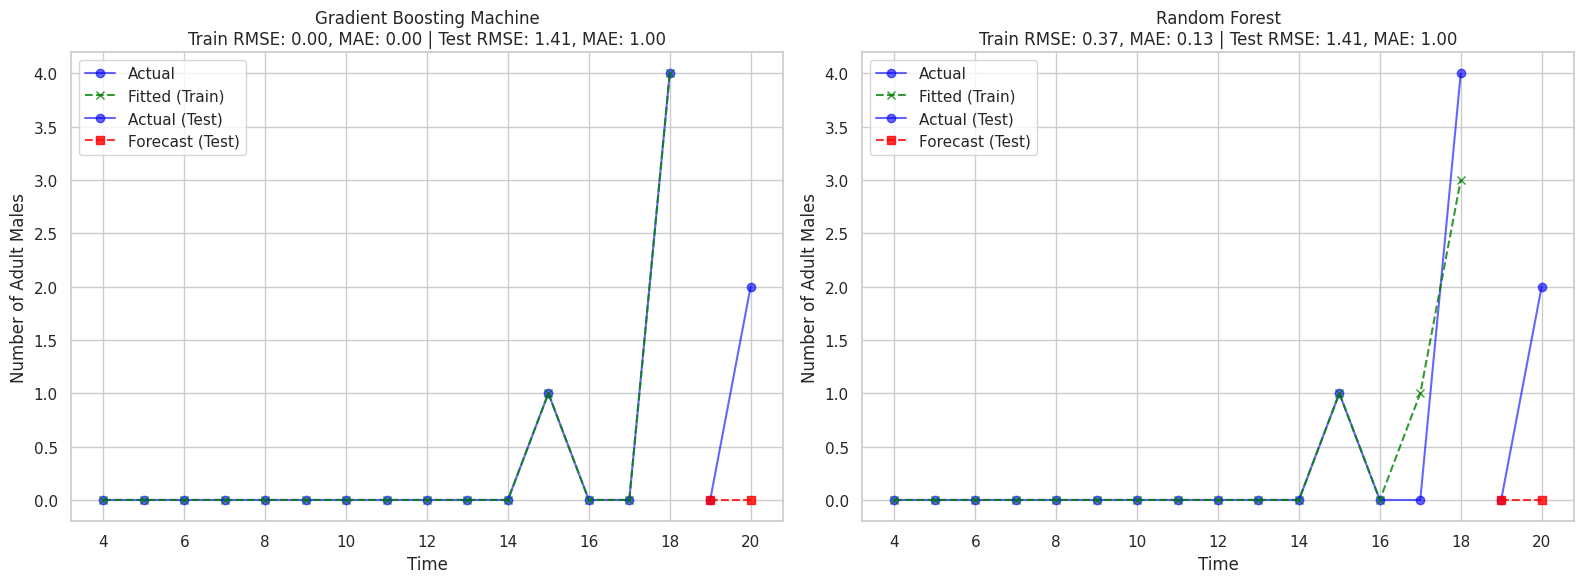

In [ ]:
# @title Forecasting Imola 1
df = pd.read_csv(JOINED_DATA + "/joined_Imola 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

models, rmse_train, mae_train, rmse_test, mae_test = GBMRF_train_and_visualize(df, n_lags=4, exog_cols=exog_cols, target_col ='Nuove catture (per evento)', test_size=0.1)

rmse_GBM_trainI1 = rmse_train[0]
mae_GBM_trainI1 = mae_train[0]
rmse_GBM_testI1 = rmse_test[0]
mae_GBM_testI1 = mae_test[0]
rmse_RF_trainI1 = rmse_train[1]
mae_RF_trainI1 = mae_train[1]
rmse_RF_testI1 = rmse_test[1]
mae_RF_testI1 = mae_test[1]

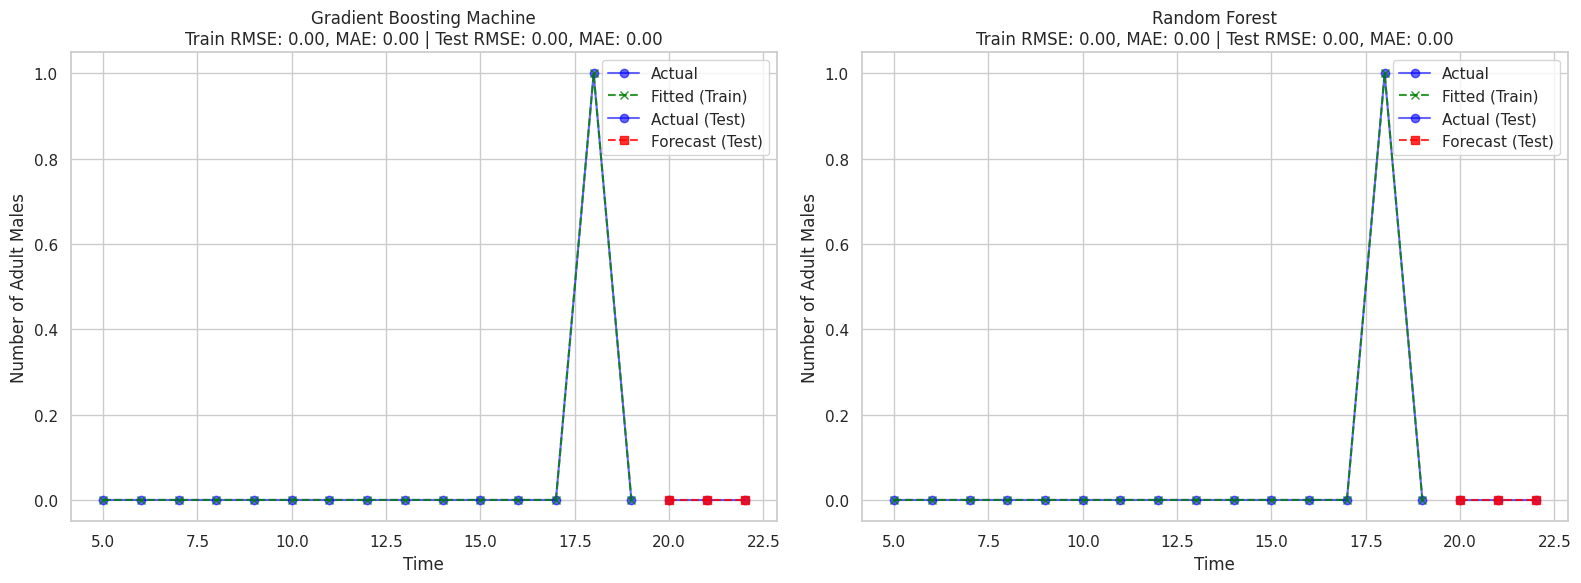

In [ ]:
# @title Forecasting Imola 2
df = pd.read_csv(JOINED_DATA + "/joined_Imola 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1','Umidità Media 2']

models, rmse_train, mae_train, rmse_test, mae_test = GBMRF_train_and_visualize(df, n_lags=5, exog_cols=exog_cols, target_col ='Nuove catture (per evento)', test_size=0.15)

rmse_GBM_trainI2 = rmse_train[0]
mae_GBM_trainI2 = mae_train[0]
rmse_GBM_testI2 = rmse_test[0]
mae_GBM_testI2 = mae_test[0]
rmse_RF_trainI2 = rmse_train[1]
mae_RF_trainI2 = mae_train[1]
rmse_RF_testI2 = rmse_test[1]
mae_RF_testI2 = mae_test[1]

# Deep Learning Techniques
Infine, per ampliare ulteriormente l’analisi e confrontare i modelli precedenti, è stato deciso di implementare anche dei modelli di deep learning. Questi modelli, caratterizzati da un numero maggiore di parametri rispetto ai metodi tradizionali, offrono la possibilità di apprendere rappresentazioni più complesse dei dati e di catturare pattern più sofisticati.

Tuttavia, consapevoli della natura complessa di questi modelli e del rischio di overfitting dovuto alla limitata quantità di dati disponibili, è stato necessario adottare strategie per evitare che il modello si adattasse eccessivamente ai dati di training. Nonostante queste sfide, è stato individuato un approccio interessante che ha permesso di esplorare e cercare di estrarre un pattern comune tra tutti i dataset, cercando di beneficiare della capacità del deep learning di generalizzare meglio, anche quando si lavora con dati relativamente ridotti.

## MLP - Lagged Regressor
Un primo approccio di deep learning considerato è stato l'MLP (Multilayer Perceptron), una rete neurale con input, hidden e output layer, adatta per problemi di regressione e classificazione. Per il progetto, sono stati utilizzati due hidden layer, con il numero di neuroni variato a seconda del dataset. L'addestramento è stato eseguito con Stochastic Gradient Descent (SGD) e l'ottimizzatore Adam, che ha migliorato la convergenza e l'efficienza computazionale. Si è utilizzata come loss di riferimento il Mean Square Error.

I risultati dell'MLP sono stati promettenti, ma c'è preoccupazione per il rischio di overfitting, poiché la mancanza di un set di validation ha impedito una valutazione accurata della generalizzazione del modello. Per questo, è stato deciso di esplorare nella fase successiva una LSTM, una rete neurale ricorrente più adatta per analizzare serie temporali, con l'obiettivo di migliorare la capacità di generalizzare su nuovi dati.

In [ ]:
#@title Definition
def mlp_lagged_regressor(df, target_col, n_lags=5, exog_cols=None, test_size=0.2,
                         dense_units=(64, 32), learning_rate=0.001,
                         epochs=200, batch_size=32):
    """
    Allena un modello MLP su dati di serie temporali con variabili esogene opzionali.

    Argomenti:
        df (pd.DataFrame): DataFrame di input.
        target_col (str): Nome della colonna target.
        n_lags (int): Numero di caratteristiche laggate da creare (default 5).
        exog_cols (list): Lista delle variabili esogene da includere (default None).
        test_size (float o int): Numero di osservazioni da usare come dati di test.
                                 - Se è un float, viene interpretato come una frazione del dataset.
                                 - Se è un int, viene interpretato come il numero di osservazioni.
        dense_units (tuple): Tupla di interi che specifica il numero di neuroni in ciascun layer Dense.
        learning_rate (float): Tasso di apprendimento per l'ottimizzatore.
        epochs (int): Numero di epoche per l'allenamento (default 200).
        batch_size (int): Dimensione del batch per l'allenamento (default 32).

    Returns:
        model: Modello MLP allenato.
        history: Storico dell'allenamento del modello.
        df_lagged: DataFrame con le caratteristiche laggate.
    """
    exog_cols = exog_cols or []

    # Creazione delle feature laggate
    def create_lagged_features(df, n_lags, target_col):
        lagged_df = df.copy()
        for i in range(1, n_lags + 1):
            lagged_df[f'lag_{i}'] = lagged_df[target_col].shift(i)
        lagged_df = lagged_df.dropna()
        return lagged_df

    lagged_df = create_lagged_features(df, n_lags=n_lags, target_col=target_col)

    # Definizione delle features e del target
    feature_cols = [f'lag_{i}' for i in range(1, n_lags + 1)] + exog_cols
    X = lagged_df[feature_cols]
    y = lagged_df[target_col]

    if test_size < 1:
      test_size = int(np.floor(len(lagged_df) * test_size))

    # Split dataset
    train_size = len(lagged_df) - test_size
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_test, y_test = X.iloc[train_size:], y.iloc[train_size:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Definizione del modello MLP
    inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
    x = inputs
    for units in dense_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Learning Rate e ottimizzatore
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Trainining
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test),
        verbose=0
    )

    # Predizioni
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Postprocessing delle predizioni con arrotondamento
    y_train_pred_processed = np.clip(y_train_pred.flatten(), 0, None).round()
    y_test_pred_processed = np.clip(y_test_pred.flatten(), 0, None).round()

    # Calcolo delle metriche
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_processed))
    mae_train = mean_absolute_error(y_train, y_train_pred_processed)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_processed))
    mae_test = mean_absolute_error(y_test, y_test_pred_processed)

    # Residui sul training
    residuals_train = y_train - y_train_pred_processed

    y_train_index = y_train.index
    y_test_index = y_test.index

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot 1: Actual vs Fitted Data su dati di training
    axs[0, 0].plot(y_train_index, y_train, label='Actual', color='blue', marker='o')
    axs[0, 0].plot(y_train_index, y_train_pred_processed, label='Fitted', color='red', linestyle='--', marker='x')
    axs[0, 0].set_title(f'Actual vs. Fitted Values on Training Data\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel(target_col)
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot 2: Residui su Training Data
    axs[0, 1].plot(y_train_index, residuals_train, label='Residuals', color='purple', marker='o')
    axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[0, 1].set_title('Residuals on Training Data')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Residuals')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot 3: Training & Validation Loss durante le epoche
    axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[1, 0].set_title('Model Loss Over Epochs')
    axs[1, 0].set_ylabel('Mean Squared Error')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot 4: Forecast vs Dati Reali sui dati di Test
    axs[1, 1].plot(y_test_index, y_test.values, label='Actual', marker='o', color='blue')
    axs[1, 1].plot(y_test_index, y_test_pred_processed, label='Forecasted', marker='x', linestyle='--', color='red')
    axs[1, 1].set_title(f'Forecast vs. Actual Values on Test Data\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel(target_col)
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, lagged_df, rmse_test, mae_test, rmse_train, mae_train

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


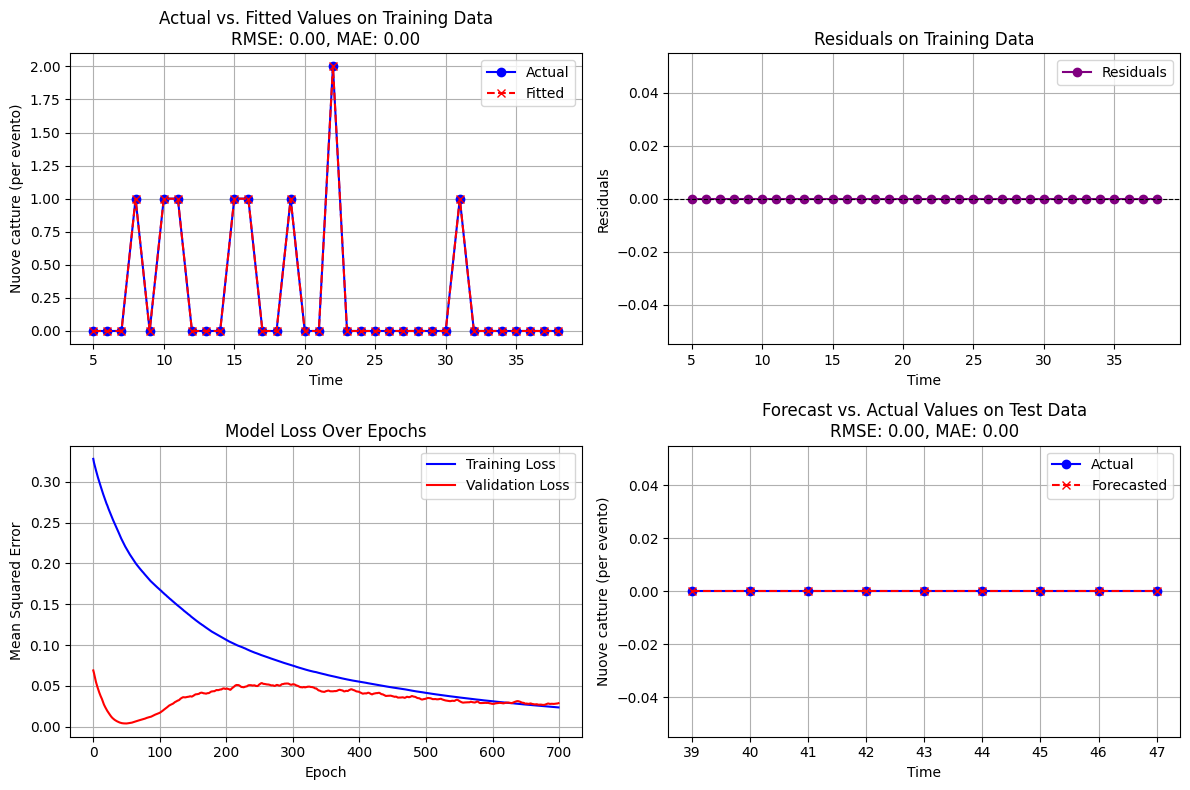

In [ ]:
#@title Forecast - Cicalino 1
df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']

final_model, final_history, final_lagged_df, rmse_test, mae_test, rmse_train, mae_train = mlp_lagged_regressor(
    df=df,
    target_col='Nuove catture (per evento)',
    n_lags=5,
    exog_cols=exog_cols,
    test_size=0.23,
    dense_units=[32,32],
    learning_rate=0.0001,
    epochs=700,
    batch_size=15
)

rmse_MLP_trainC1 = rmse_train
mae_MLP_trainC1 = mae_train
rmse_MLP_testC1 = rmse_test
mae_MLP_testC1 = mae_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


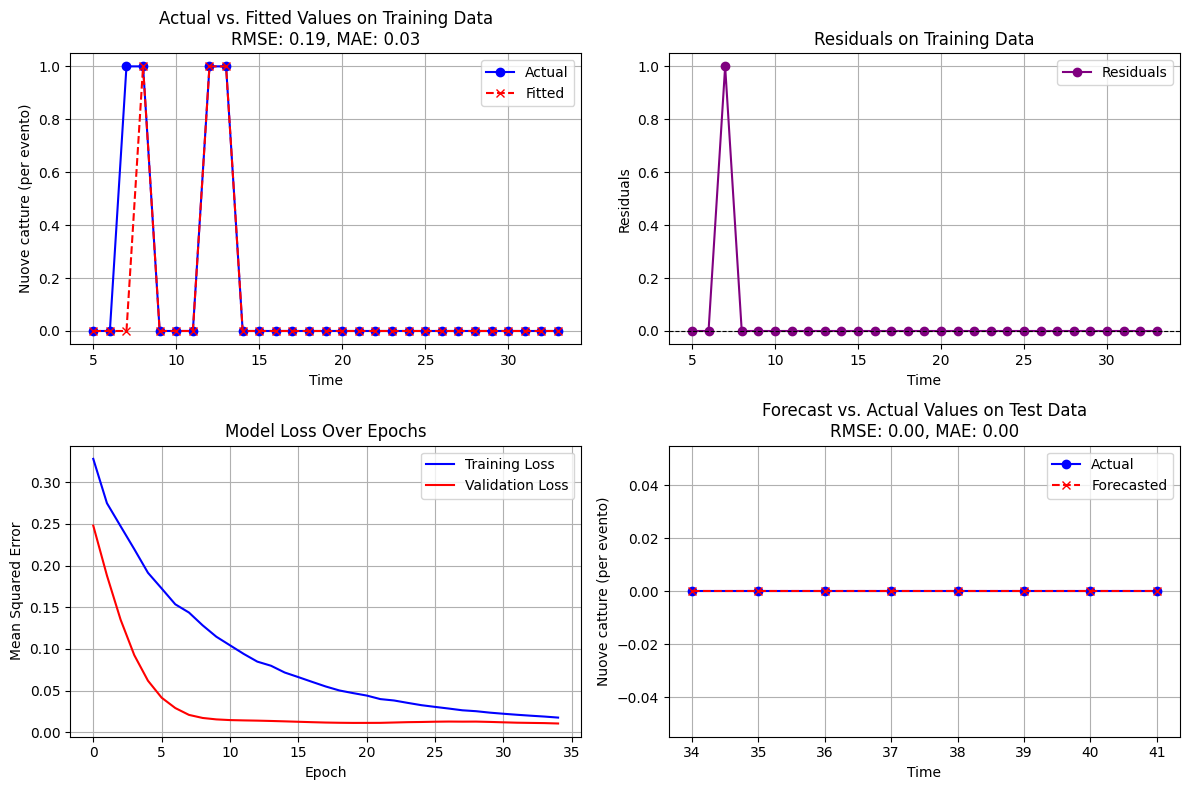

In [ ]:
#@title Forecast - Cicalino 2
df = pd.read_csv(JOINED_DATA + "/joined_Cicalino 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']

final_model, final_history, final_lagged_df, rmse_test, mae_test, rmse_train, mae_train = mlp_lagged_regressor(
    df=df,
    target_col='Nuove catture (per evento)',
    n_lags=5,
    exog_cols=exog_cols,
    test_size=0.23,
    dense_units=[32,32],
    learning_rate=0.001,
    epochs=35,
    batch_size=15
)

rmse_MLP_trainC2 = rmse_train
mae_MLP_trainC2 = mae_train
rmse_MLP_testC2 = rmse_test
mae_MLP_testC2 = mae_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


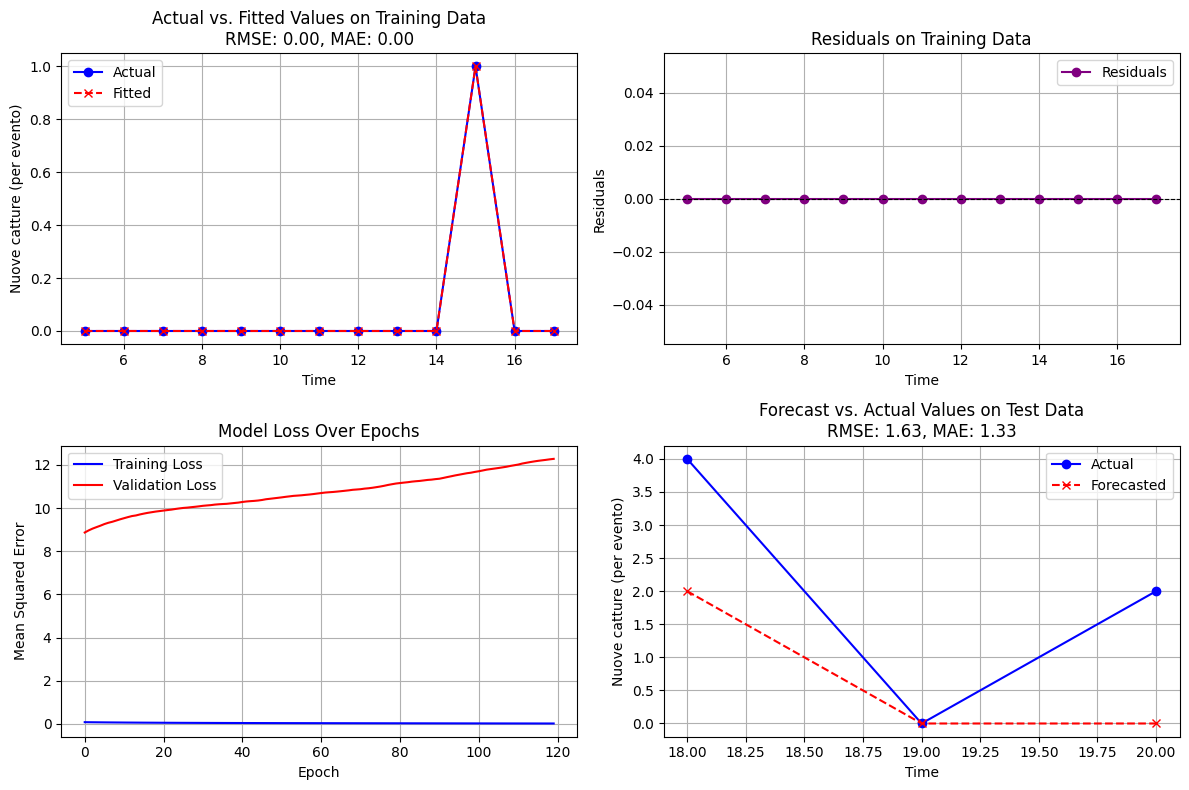

In [ ]:
#@title Forecast - Imola 1
df = pd.read_csv(JOINED_DATA + "/joined_Imola 1.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']

final_model, final_history, final_lagged_df, rmse_test, mae_test, rmse_train, mae_train = mlp_lagged_regressor(
    df=df,
    target_col='Nuove catture (per evento)',
    n_lags=5,
    exog_cols=exog_cols,
    test_size=0.20,
    dense_units=[32,32],
    learning_rate=0.0001,
    epochs=120,
    batch_size=5
)

rmse_MLP_trainI1 = rmse_train
mae_MLP_trainI1 = mae_train
rmse_MLP_testI1 = rmse_test
mae_MLP_testI1 = mae_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


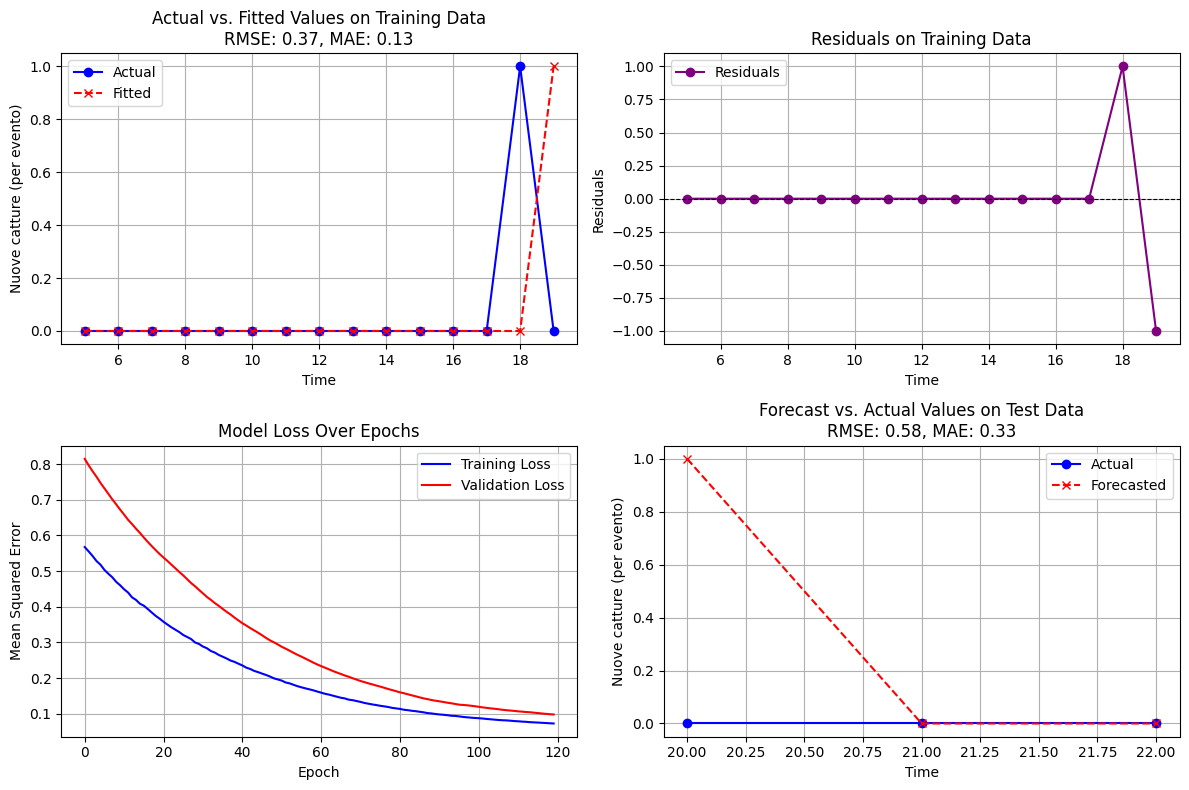

In [ ]:
#@title Forecast - Imola 2
df = pd.read_csv(JOINED_DATA + "/joined_Imola 2.csv")

exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']

final_model, final_history, final_lagged_df, rmse_test, mae_test, rmse_train, mae_train = mlp_lagged_regressor(
    df=df,
    target_col='Nuove catture (per evento)',
    n_lags=5,
    exog_cols=exog_cols,
    test_size=0.18,
    dense_units=[32,32],
    learning_rate=0.0001,
    epochs=120,
    batch_size=5
)

rmse_MLP_trainI2 = rmse_train
mae_MLP_trainI2 = mae_train
rmse_MLP_testI2 = rmse_test
mae_MLP_testI2 = mae_test

## LSTM
Le LSTM (Long Short-Term Memory) sono un tipo di rete neurale ricorrente (RNN) progettata per analizzare sequenze temporali, superando le limitazioni delle RNN tradizionali nella gestione delle dipendenze a lungo termine grazie a celle di memoria e porte di input, output e forget.

Nel progetto, il modello LSTM è stato addestrato utilizzando i dataset di Cicalino e Imola 2, con Imola 1 come dataset di test. Le variabili esogene (es. temperatura, umidità) e la data sono state incluse come feature per preservare la componente temporale.

Il modello ha appreso un pattern dai dati di training, e i risultati di test sono stati stabili. Tuttavia, si sospetta un leggero overfitting. Con i dati disponibili, sembra che il modello abbia raggiunto il massimo potenziale predittivo, indicando che ulteriori miglioramenti richiederebbero l'acquisizione di dati aggiuntivi o l'ottimizzazione del modello.

In [ ]:
#@title Definition

def preprocess_datetime_features(df, datetime_col):
    """
    Estrae caratteristiche temporali da una colonna datetime e le aggiunge al dataframe.

    Parametri:
        df (pd.DataFrame): Il dataframe di input contenente i dati.
        datetime_col (str): Nome della colonna datetime nel dataframe.

    Returns:
        pd.DataFrame: Il dataframe con le nuove colonne temporali aggiunte.
    """
    df['year'] = df[datetime_col].dt.year
    df['month'] = df[datetime_col].dt.month
    df['day'] = df[datetime_col].dt.day
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

def prepare_lstm_data(df, target_col, exog_cols, datetime_col, n_timesteps):
    """
    Prepara i dati per l'addestramento di un modello LSTM, includendo preprocessing, scaling e creazione di sequenze temporali.

    Parametri:
        df (pd.DataFrame): Il dataframe di input contenente i dati.
        target_col (str): Nome della colonna target da prevedere.
        exog_cols (list of str): Lista delle colonne di variabili esogene da includere come input.
        datetime_col (str): Nome della colonna datetime per estrarre caratteristiche temporali.
        n_timesteps (int): Numero di timestep da utilizzare per le sequenze temporali.

    Returns:
        tuple: Una tupla contenente:
            - X_seq (np.ndarray): Sequenze di input per il modello, di forma (n_samples, n_timesteps, n_features).
            - y_seq (np.ndarray): Valori target corrispondenti, di forma (n_samples,).
            - dates_seq (list): Date corrispondenti ai campioni, di lunghezza n_samples.
            - scaler_X (StandardScaler): Scaler utilizzato per scalare le feature di input.
            - scaler_y (StandardScaler): Scaler utilizzato per scalare la variabile target.
    """
    # Preprocessa la data
    df = preprocess_datetime_features(df, datetime_col)

    # Seleziona le feature di input
    feature_cols = exog_cols + ['year', 'month', 'day', 'day_of_week', 'is_weekend']
    X = df[feature_cols].values
    y = df[target_col].values

    # Scala le feature
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Converti i dati in sequenze temporali
    X_seq, y_seq, dates_seq = [], [], []
    for i in range(n_timesteps, len(df)):
        X_seq.append(X_scaled[i - n_timesteps:i])
        y_seq.append(y_scaled[i])
        dates_seq.append(df[datetime_col].iloc[i])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq, dates_seq, scaler_X, scaler_y

def build_lstm_model(n_timesteps, n_features, lstm_units, learning_rate):
    """
    Costruisce un modello LSTM per la previsione di serie temporali.

    Parametri:
        n_timesteps (int): Numero di timestep per ogni sequenza di input.
        n_features (int): Numero di feature per ogni timestep.
        lstm_units (int): Numero di unità nella layer LSTM.
        learning_rate (float): Tasso di apprendimento per l'ottimizzatore.

    Returns:
        tf.keras.Model: Modello LSTM compilato.
    """
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.LSTM(lstm_units, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def train_and_test_lstm(folder_path, test_csv, target_col, exog_cols, datetime_col,
                                n_timesteps=5, lstm_units=50, learning_rate=0.001, n_epochs=25, batch_size=8):
    """
    Addestra e testa un modello LSTM su dati di serie temporali.

    Args:
        folder_path (str): Percorso della cartella contenente i file CSV.
        test_csv (str): Nome del file CSV da usare come set di test.
        target_col (str): Nome della colonna target da prevedere.
        exog_cols (list of str): Lista delle colonne di variabili esogene da includere come input.
        datetime_col (str): Nome della colonna datetime per estrarre caratteristiche temporali.
        n_timesteps (int, optional): Numero di timestep da usare per le sequenze temporali. Default: 5.
        lstm_units (int, optional): Numero di unità nella layer LSTM. Default: 50.
        learning_rate (float, optional): Tasso di apprendimento per l'ottimizzatore. Default: 0.001.
        n_epochs (int, optional): Numero di epoche di addestramento. Default: 25.
        batch_size (int, optional): Dimensione del batch per l'addestramento. Default: 8.

    Returns:
        tf.keras.Model: Modello LSTM addestrato sull'ultimo file di training.
    """
    # Leggi tutti i file CSV nella cartella
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    test_file_path = os.path.join(folder_path, test_csv)

    # Escludi "joined_Imola 3.csv"
    all_files = [f for f in all_files if f != "joined_Imola 3.csv"]

    # Lista per raccogliere i dati di addestramento
    train_dfs = []

    for file in all_files:
        if file != test_csv:  # Usa tutti gli altri file per l'addestramento
            train_dfs.append((file, pd.read_csv(os.path.join(folder_path, file), parse_dates=[datetime_col])))

    # Leggi il file di test
    test_df = pd.read_csv(test_file_path, parse_dates=[datetime_col])

    # Plot del training per ogni file CSV (max 3 file)
    fig_train, axs_train = plt.subplots(1, 3, figsize=(18, 4))
    axs_train = axs_train.flatten()

    # Variabili per accumulare le metriche
    train_rmse_list = []
    train_mae_list = []

    # Controlla il numero massimo di subplot per i file di training
    max_train_plots = len(train_dfs) if len(train_dfs) < 3 else 3

    # Prepara il modello
    model = None  # Il modello sarà addestrato con l'ultimo training file
    scaler_X, scaler_y = None, None

    for idx, (file_name, df) in enumerate(train_dfs[:max_train_plots]):
        # Prepara i dati per il singolo file CSV
        X_train, y_train, dates_train, scaler_X, scaler_y = prepare_lstm_data(
            df, target_col, exog_cols, datetime_col, n_timesteps
        )

        # Costruisci il modello per il primo CSV o riutilizza lo stesso modello
        if model is None:
            model = build_lstm_model(X_train.shape[1], X_train.shape[2], lstm_units, learning_rate)

        # Addestra il modello per il file corrente
        model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

        # Predici sui dati di training
        y_train_pred = model.predict(X_train).flatten()
        y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_train_pred = np.round(y_train_pred)  # Arrotondamento
        y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

        # Calcola metriche per il training
        rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
        mae_train = mean_absolute_error(y_train_actual, y_train_pred)
        train_rmse_list.append(rmse_train)
        train_mae_list.append(mae_train)

        # Plot del fit per il file corrente
        axs_train[idx].plot(dates_train, y_train_actual, label='Actual', color='blue', marker='o')
        axs_train[idx].plot(dates_train, y_train_pred, label='Fitted', color='red', linestyle='--', marker='x')
        axs_train[idx].set_title(f"Fit for Training CSV: {file_name}\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
        axs_train[idx].set_xlabel('Date')
        axs_train[idx].set_ylabel(target_col)
        axs_train[idx].legend()
        axs_train[idx].grid(True)

        # Personalizza il formato dell'asse temporale per rimuovere l'anno
        date_format = DateFormatter("%m-%d")
        axs_train[idx].xaxis.set_major_formatter(date_format)

    # Aggrega le metriche di training
    train_rmse_avg = np.mean(train_rmse_list)
    train_mae_avg = np.mean(train_mae_list)

    # Stampa le metriche di training
    print(f"Aggregated Training Metrics:")
    print(f"- Average RMSE: {train_rmse_avg:.2f}")
    print(f"- Average MAE: {train_mae_avg:.2f}")

    # Prepara i dati per il file di test
    X_test, y_test, dates_test, _, scaler_y_test = prepare_lstm_data(
        test_df, target_col, exog_cols, datetime_col, n_timesteps
    )

    # Predici sui dati di test
    y_test_pred = model.predict(X_test).flatten()
    y_test_actual = scaler_y_test.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred = scaler_y_test.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    y_test_pred = np.round(y_test_pred)  # Arrotondamento

    # Calcola metriche per il test
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mae_test = mean_absolute_error(y_test_actual, y_test_pred)

    # Stampa le metriche di test
    print(f"\nTest Metrics for {test_csv}:")
    print(f"- RMSE: {rmse_test:.2f}")
    print(f"- MAE: {mae_test:.2f}")

    # Grafici inferiori: perdita e test
    fig_loss_test, axs_loss_test = plt.subplots(1, 2, figsize=(18, 6))

    # Grafico perdita del modello
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=n_epochs, batch_size=batch_size, verbose=0)
    axs_loss_test[0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs_loss_test[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs_loss_test[0].set_title('Model Loss Over Epochs')
    axs_loss_test[0].set_xlabel('Epoch')
    axs_loss_test[0].set_ylabel('Mean Squared Error')
    axs_loss_test[0].legend()
    axs_loss_test[0].grid(True)

    # Grafico test: predizioni vs. valori reali
    axs_loss_test[1].plot(dates_test, y_test_actual, label='Actual', color='blue', marker='o')
    axs_loss_test[1].plot(dates_test, y_test_pred, label='Predicted', color='red', linestyle='--', marker='x')
    axs_loss_test[1].set_title(f'Forecast vs. Actual for Test CSV: {test_csv}\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
    axs_loss_test[1].set_xlabel('Date')
    axs_loss_test[1].set_ylabel(target_col)
    axs_loss_test[1].legend()
    axs_loss_test[1].grid(True)

    # Personalizza il formato dell'asse temporale per rimuovere l'anno
    axs_loss_test[1].xaxis.set_major_formatter(date_format)

    plt.tight_layout()
    plt.show()

    return model

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Aggregated Training Metrics:
- Average RMSE: 0.05
- Average MAE: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Test Metrics for joined_Imola 1.csv:
- RMSE: 1.12
- MAE: 0.50


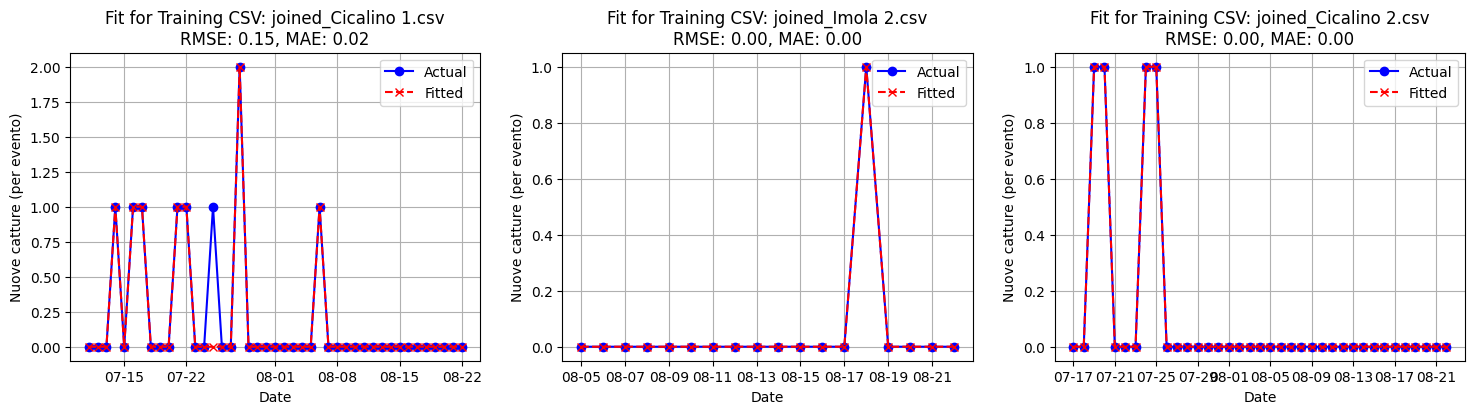

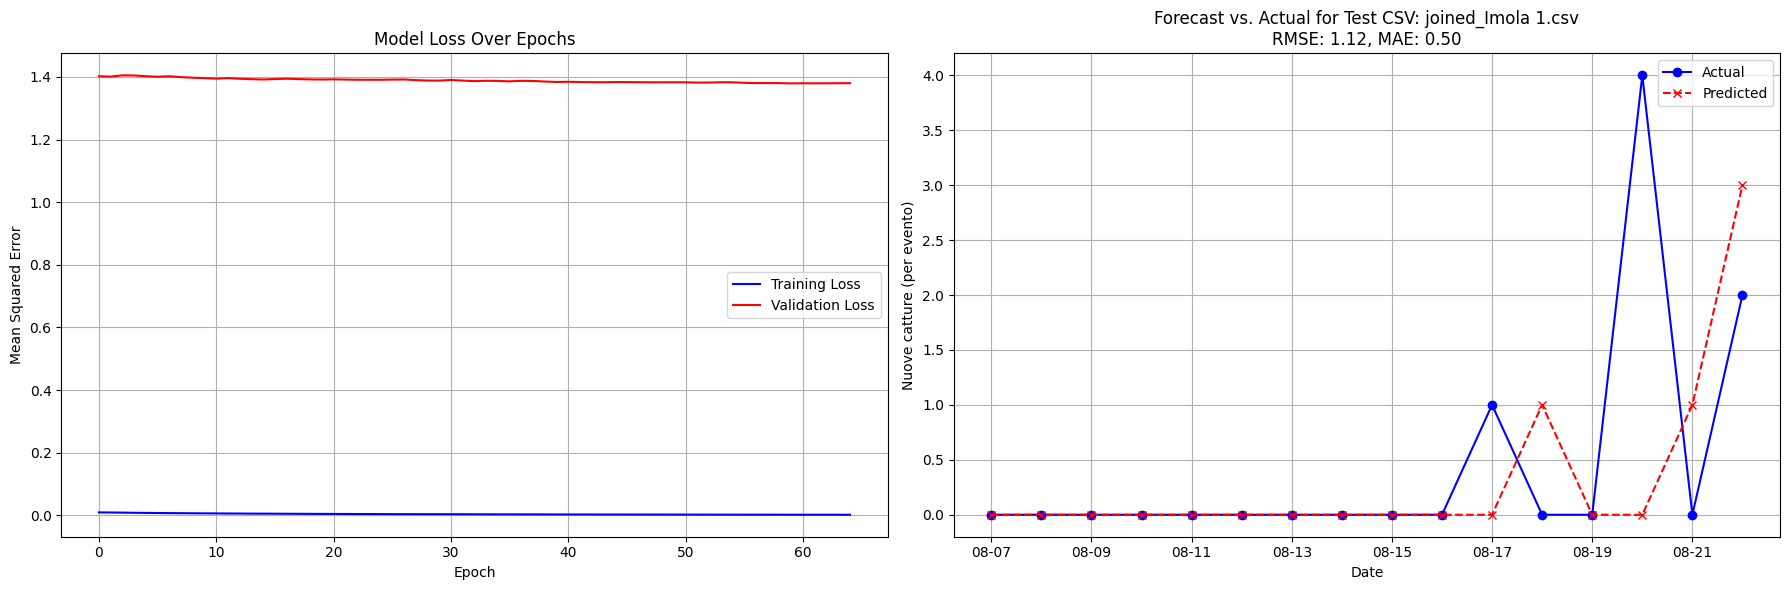

In [ ]:
#@title Forecasting

target_col = "Nuove catture (per evento)"
exog_cols = ['Temperatura Media 1', 'Temperatura Media 2', 'Umidità Media 1', 'Umidità Media 2']
datetime_col = "DateTime"
test_csv = "joined_Imola 1.csv"

model = train_and_test_lstm(
    folder_path=JOINED_DATA,
    test_csv=test_csv,
    target_col=target_col,
    exog_cols=exog_cols,
    datetime_col=datetime_col,
    n_timesteps=5,
    lstm_units=50,
    learning_rate=0.001,
    n_epochs=65,
    batch_size=10
)

# Final Results
In conclusione, i risultati dello studio indicano che modelli complessi, come l'MLP, tendono a comportarsi meglio su dataset più ampi, dove la capacità di apprendere rappresentazioni complesse risulta più efficace. Tuttavia, nel caso di dataset più piccoli, i metodi statistici e machine learning più semplici mostrano una precisione leggermente superiore, probabilmente grazie alla loro minore propensione all'overfitting e alla maggiore robustezza con dati limitati. Questi risultati suggeriscono che, per dataset ridotti, l'approccio migliore potrebbe essere quello di utilizzare modelli meno complessi che riescono a generalizzare meglio.

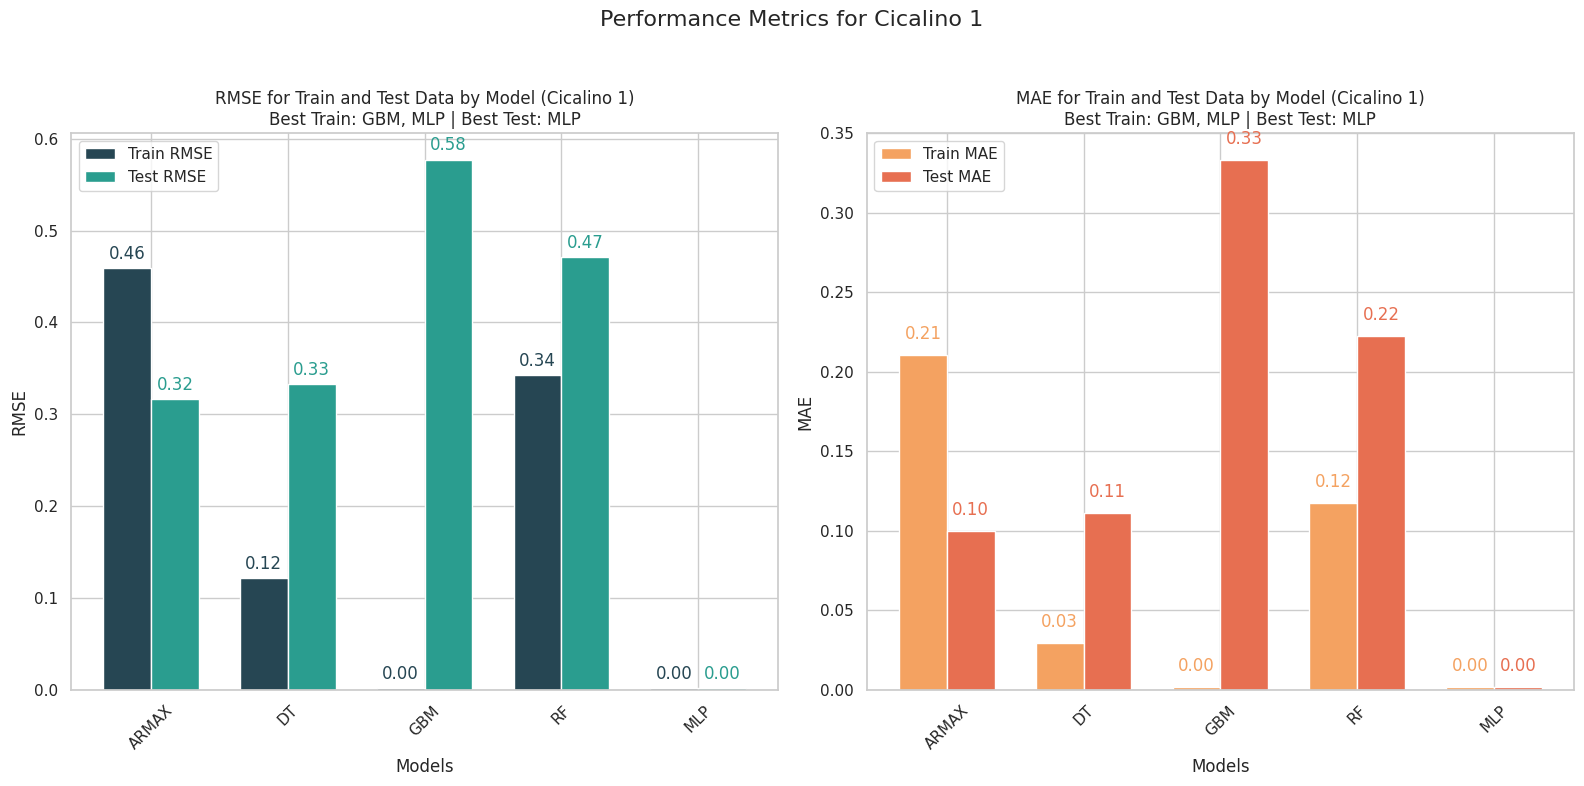

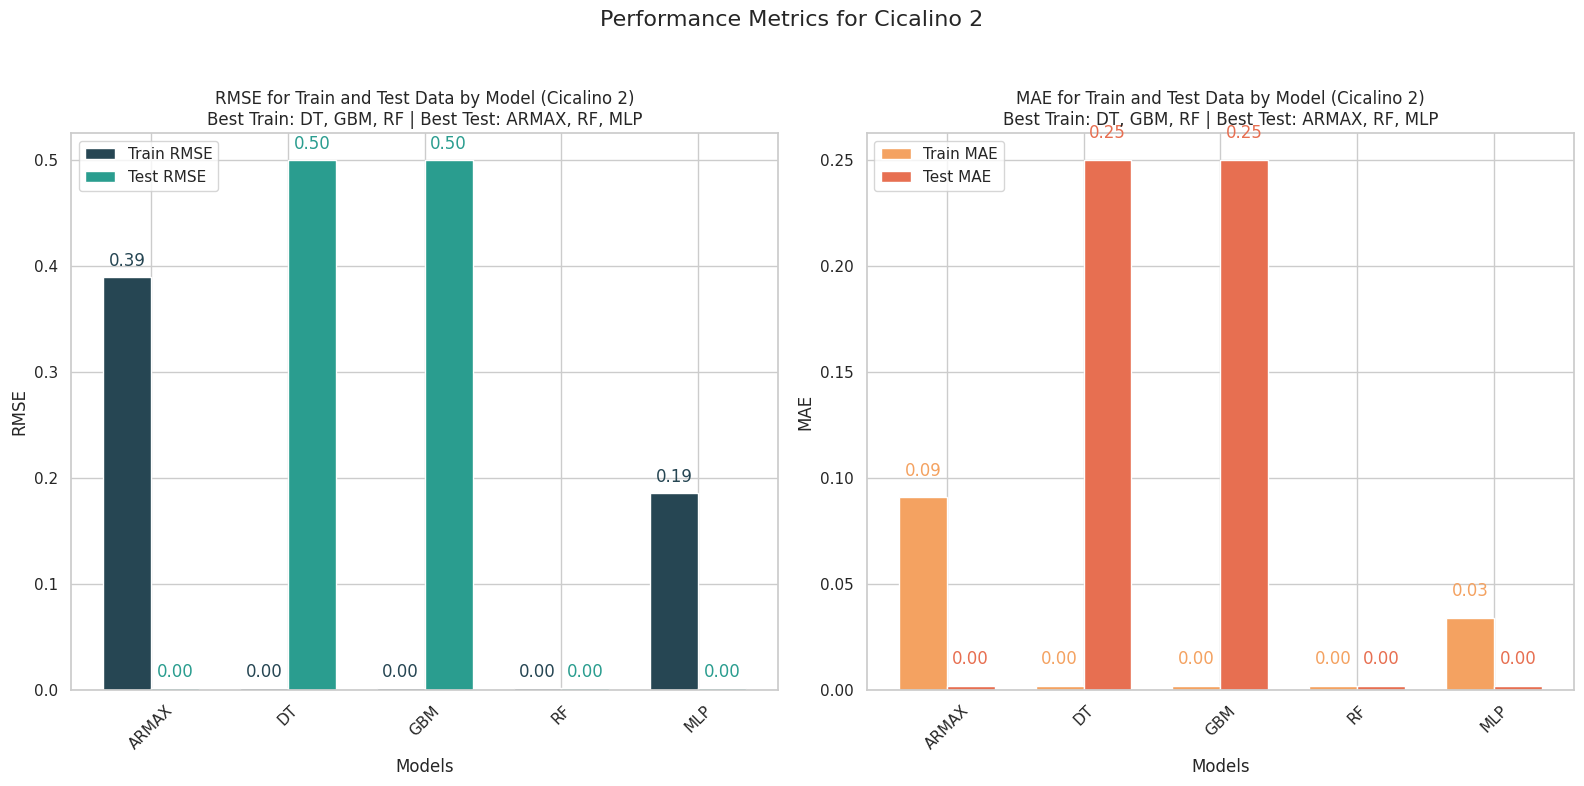

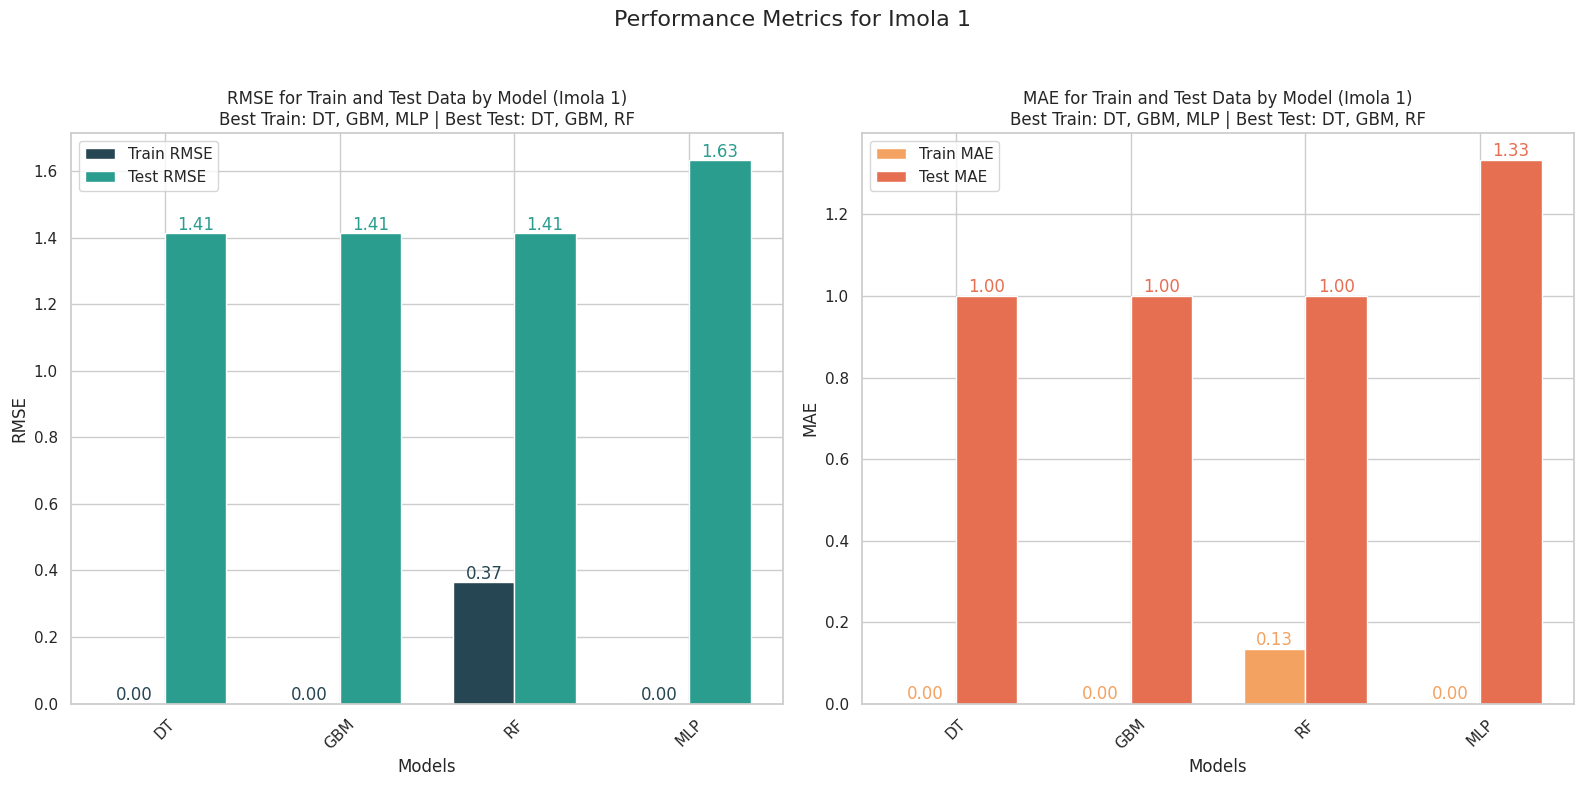

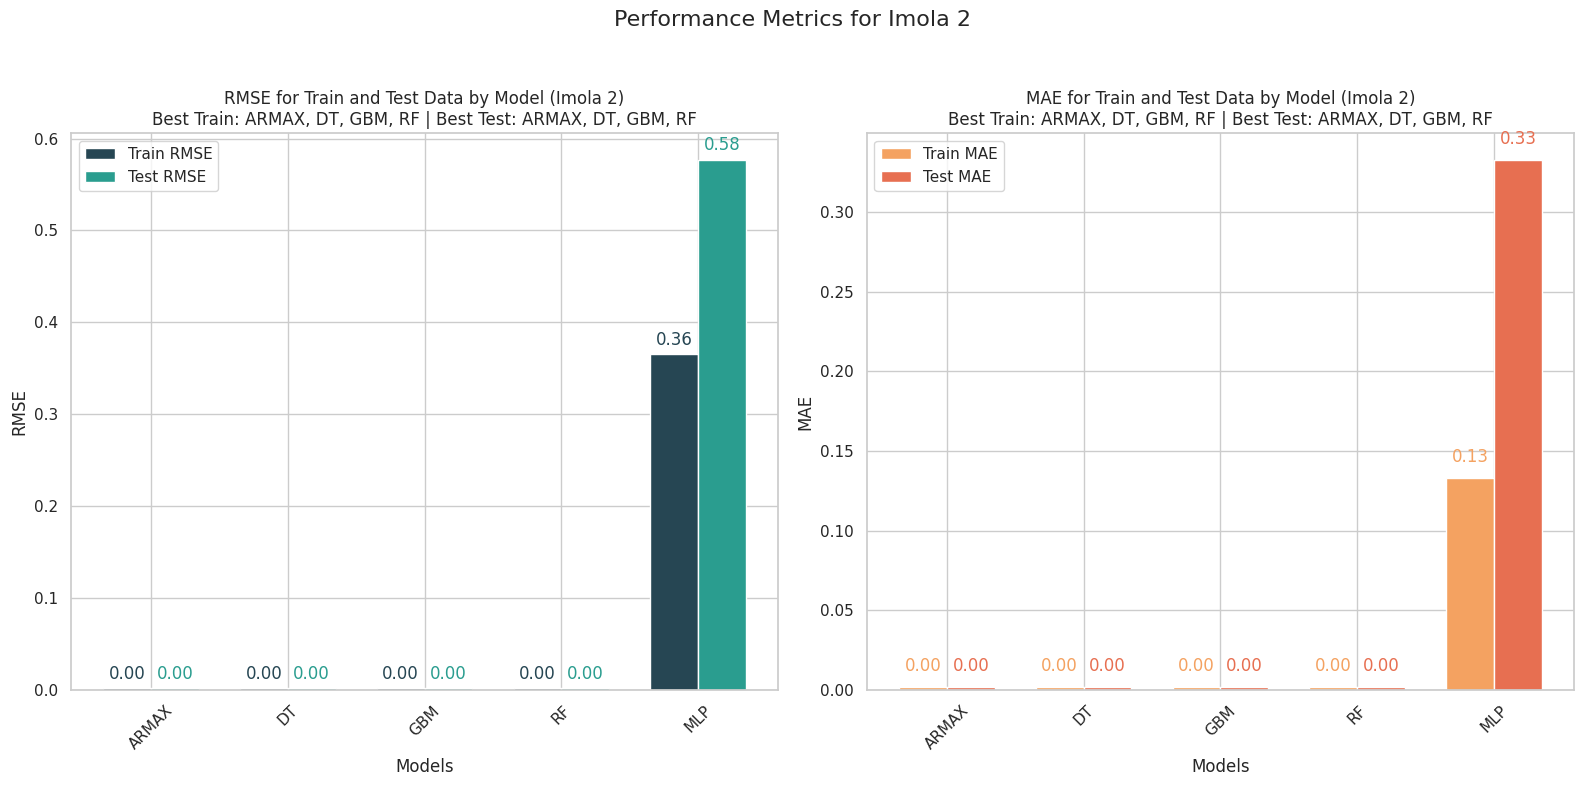

In [ ]:
#@title Plot
# Modelli disponibili
base_models = ["ARMAX", "DT", "GBM", "RF", "MLP"]

# Suffixes per iterazione
suffixes = ["C1", "C2", "I1", "I2"]

for suffix in suffixes:
    # Modifica i modelli se il suffisso è I1
    models = [model for model in base_models if not (suffix == "I1" and model == "ARMAX")]

    # Definizione delle metriche per ogni modello e suffisso
    train_rmse, test_rmse, train_mae, test_mae = [], [], [], []

    for model in models:
        # Creare il nome della variabile per ogni metrica in base al modello e suffisso
        train_rmse.append(eval(f"rmse_{model}_train{suffix}"))
        test_rmse.append(eval(f"rmse_{model}_test{suffix}"))
        train_mae.append(eval(f"mae_{model}_train{suffix}"))
        test_mae.append(eval(f"mae_{model}_test{suffix}"))

    # Titolo basato sul suffisso
    if suffix == "C1":
        title_suffix = "Cicalino 1"
    elif suffix == "C2":
        title_suffix = "Cicalino 2"
    elif suffix == "I1":
        title_suffix = "Imola 1"
    elif suffix == "I2":
        title_suffix = "Imola 2"

    # Plotting
    x = np.arange(len(models))  # Posizioni delle label
    width = 0.35  # Larghezza delle barre

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Trova i modelli migliori in base a RMSE e MAE (gestendo i pareggi)
    best_train_rmse_models = [models[i] for i in np.where(train_rmse == np.min(train_rmse))[0]]
    best_test_rmse_models = [models[i] for i in np.where(test_rmse == np.min(test_rmse))[0]]
    best_train_mae_models = [models[i] for i in np.where(train_mae == np.min(train_mae))[0]]
    best_test_mae_models = [models[i] for i in np.where(test_mae == np.min(test_mae))[0]]

    # RMSE
    for i, (train_r, test_r) in enumerate(zip(train_rmse, test_rmse)):
        # Modifica per valori di RMSE pari a zero
        if train_r == 0:
            axs[0].bar(x[i] - width / 2, 0.002, width, color='#264653')  # Rettangolo basso per 0
            axs[0].text(x[i] - width / 2, 0.002 + 0.01, f'{train_r:.2f}', ha='center', color='#264653')
        else:
            axs[0].bar(x[i] - width / 2, train_r, width, color='#264653')
            axs[0].text(x[i] - width / 2, train_r + 0.01, f'{train_r:.2f}', ha='center', color='#264653')

        if test_r == 0:
            axs[0].bar(x[i] + width / 2, 0.002, width, color='#2a9d8f')  # Rettangolo basso per 0
            axs[0].text(x[i] + width / 2, 0.002 + 0.01, f'{test_r:.2f}', ha='center', color='#2a9d8f')
        else:
            axs[0].bar(x[i] + width / 2, test_r, width, color='#2a9d8f')
            axs[0].text(x[i] + width / 2, test_r + 0.01, f'{test_r:.2f}', ha='center', color='#2a9d8f')

    axs[0].set_xlabel('Models')
    axs[0].set_ylabel('RMSE')
    axs[0].set_title(f'RMSE for Train and Test Data by Model ({title_suffix})\nBest Train: {", ".join(best_train_rmse_models)} | Best Test: {", ".join(best_test_rmse_models)}')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(models, rotation=45)
    axs[0].grid(True)

    # MAE
    for i, (train_m, test_m) in enumerate(zip(train_mae, test_mae)):
        # Modifica per valori di MAE pari a zero
        if train_m == 0:
            axs[1].bar(x[i] - width / 2, 0.002, width, color='#f4a261')  # Rettangolo basso per 0
            axs[1].text(x[i] - width / 2, 0.002 + 0.01, f'{train_m:.2f}', ha='center', color='#f4a261')
        else:
            axs[1].bar(x[i] - width / 2, train_m, width, color='#f4a261')
            axs[1].text(x[i] - width / 2, train_m + 0.01, f'{train_m:.2f}', ha='center', color='#f4a261')

        if test_m == 0:
            axs[1].bar(x[i] + width / 2, 0.002, width, color='#e76f51')  # Rettangolo basso per 0
            axs[1].text(x[i] + width / 2, 0.002 + 0.01, f'{test_m:.2f}', ha='center', color='#e76f51')
        else:
            axs[1].bar(x[i] + width / 2, test_m, width, color='#e76f51')
            axs[1].text(x[i] + width / 2, test_m + 0.01, f'{test_m:.2f}', ha='center', color='#e76f51')

    axs[1].set_xlabel('Models')
    axs[1].set_ylabel('MAE')
    axs[1].set_title(f'MAE for Train and Test Data by Model ({title_suffix})\nBest Train: {", ".join(best_train_mae_models)} | Best Test: {", ".join(best_test_mae_models)}')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(models, rotation=45)
    axs[1].grid(True)

    # Aggiungi una legenda globale per i colori di "Train" e "Test"
    axs[0].legend(['Train RMSE', 'Test RMSE'], loc='upper left')
    axs[1].legend(['Train MAE', 'Test MAE'], loc='upper left')

    # Titolo generale sopra il grafico
    fig.suptitle(f"Performance Metrics for {title_suffix}", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Lascia spazio per il titolo generale
    plt.show()
    print("\n\n")